In [1]:
import sys
from common import commons
home = commons.home
sys.path.append('/home/ec2-user/anaconda3/lib/python3.6/site-packages')
import pandas as pd
import numpy as np
from models import ModelSelection as MS
from models import Ensemble as es
from models import xgbooster
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import confusion_matrix,recall_score,precision_score,accuracy_score,f1_score,roc_curve,roc_auc_score,precision_recall_curve
import matplotlib.pyplot as plt
from sklearn import clone
from sklearn.externals import joblib
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from importlib import reload
from log import Logger
from models import deep_network_estimator as dne
from models import Ensemble_hyperopt as eh
from hyperopt import fmin,tpe,hp, STATUS_OK,Trials
from hyperopt_models import parallel_ensemble as pe
from functools import reduce
import itertools


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_curves_cv(probs,label,methods,types='roc_curve'):
    plt.figure(figsize=(7,5))
    plt.title(types)
    plt.axis([0,1,0,1])
    lw = 2
    colors = ['r','b','g','k','c','m','y']
    for method,color in zip(methods,colors[:len(methods)]):
        if types == 'precision_recall_curve':       
            precision,recall,threshold = precision_recall_curve(label,probs[method])
            plt.plot(recall,precision,color,linewidth=2,label=method)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
        if types == 'roc_curve':
            fpr,tpr, threshold = roc_curve(label,probs[method])
            plt.plot(fpr,tpr,color,linewidth=2,label=method)
            plt.xlabel('False Positive Rate')
            plt.ylabel('Recall')
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.legend(loc='best')


#----------------------------------------------------------------------------
def get_estimators(methods,params,train_x,train_label):
    ensemble = eh.Ensemble(methods,params)
    ensemble.fit(train_x,train_label,sample_weight=sample_weight_train,max_iter=100)
    return ensemble
#-----------------------------------------------------------------------------
def plot_curves(estimators,test_x,label,types='roc_curve'):
    plt.figure(figsize=(7,5))
    plt.title(types)
    plt.axis([0,1,0,1])
    lw = 2
    colors = ['r','b','g','k','c','m','y']
    for color,estimator in zip(colors[:len(estimators)],estimators):
        name = type(estimator).__name__
        probs = np.array(estimator.predict_proba(test_x))[:,1]
        if types == 'precision_recall_curve':       
            precision,recall,threshold = precision_recall_curve(label,probs)
            plt.plot(recall,precision,color,linewidth=2,label=name)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
        if types == 'roc_curve':
            fpr,tpr, threshold = roc_curve(label,probs)
            plt.plot(fpr,tpr,color,linewidth=2,label=name)
            plt.xlabel('False Positive Rate')
            plt.ylabel('Recall')
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.legend(loc='best')
#-----------------------------------------------------------------------------
def learn_curve(model,train_x,train_label,cv=3,scoring='neg_log_loss'):
    model_c = clone(model)
    N,train_score,test_score = learning_curve(model_c, 
                                            train_x,train_label,cv=cv,train_sizes=np.linspace(0.5,1,5),
                                            scoring=scoring)
    
    plt.figure(figsize=(7,4))
    plt.title('{}'.format(type(model).__name__))
    plt.plot(N,np.mean(train_score,1),color='blue', label='training score')
    plt.plot(N,np.mean(test_score,1),color='red',label='validation score')
    plt.xlabel('training sample')
    plt.ylabel(scoring)
    plt.legend(loc=0)
    plt.show()
#-----------------------------------------------------------------------------    
def error_analysis(estimator,test_x,label,types=['confusion_matrix']):
    print('Error analysis of ',type(estimator).__name__)
    predict = estimator.predict(test_x)
    probs = np.array(estimator.predict_proba(test_x))[:,1]
    class_num = len(label.unique())
    if 'confusion_matrix' in types:
        conf_mat = confusion_matrix(label,predict)
        row_sums = conf_mat.sum(axis=1,keepdims=True)
        norm_conf_mat = conf_mat/row_sums
        np.fill_diagonal(norm_conf_mat,0)
        plt.matshow(norm_conf_mat,cmap=plt.cm.gray)        
    if 'precision_recall_curve' in types and class_num<=2:
        precision,recall,threshold = precision_recall_curve(label,probs)
        plot_curve(recall,precision,type(estimator).__name__,'precision_recall_curve')
    if 'roc_curve' in types and class_num<=2:
        fpr,tpr, threshold = roc_curve(label,probs)
        plot_curve(fpr,tpr,type(estimator).__name__,'roc_curve')    
    plt.show()
#---------------------------------------------------------------------------    
def plot_curve(score1,score2,label,types):
    plt.figure(figsize=(7,5))
    plt.title(types)
    plt.plot(score1,score2,linewidth=2,label=label)
    plt.plot([0,1],[1,1],'k--')
    plt.axis([0,1,0,1])
    lw = 2
    if types == 'precision_recall_curve':        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
    if types == 'roc_curve':
        plt.xlabel('False Positive Rate')
        plt.ylabel('Recall')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#--------------------------------------------------------------------------
def scores(y,predicts,pred_probs,average='macro'):
    class_num = len(y.unique())
    score_map = {}

    if class_num <=2:
        recall = recall_score(y,predicts)      
        precision = precision_score(y,predicts)      
        accuracy = accuracy_score(y,predicts)
        f1 = f1_score(y,predicts)
        auc = roc_auc_score(y,pred_probs)
        score_map['auc'] = auc
    else:
        recall = recall_score(y,predicts,average=average)      
        precision = precision_score(y,predicts,average=average)      
        accuracy = accuracy_score(y,predicts)
        f1 = f1_score(y,predicts,average=average)
        
    score_map['recall'] = recall
    score_map['precision'] = precision
    score_map['accuracy'] = accuracy
    score_map['f1'] = f1
    return score_map

#---------------------------------------------------------------------------
def cross_val_ensemble(x,y,sample_weight,methods,params,fold=10, hyperopt=True,up_sampling=False):
    skfolds = StratifiedKFold(n_splits=10,random_state=43)
    results = []
    model_combine_scores_cv = []
    model_scores_cv = []
    best_params_cv = []
    cv_columns = ['label','ensemble']+methods
    pred_probs_cv = pd.DataFrame(columns=cv_columns)
    predicts_cv = pd.DataFrame(columns=cv_columns)
    pred_probs_all_fold = {}
    for method in methods:
        pred_probs_all_fold[method] = []
    pred_probs_all_fold['label'] = []    
    if not hyperopt:
        search_methods = get_train_models(models=methods)
    class_num = len(y.unique())
    for train_index,test_index in skfolds.split(x,y):
        train_fold = x.ix[train_index,:]
        train_label = y[train_index]
        sample_weight_train = sample_weight[train_index]
        test_fold = x.ix[test_index,:]
        test_label = y[test_index]
        sample_weight_test = sample_weight[test_index]
        if up_sampling:
            train_fold,train_label,sample_weight_train = upsampling(train_fold,train_label,sample_weight_train,fold=9)
            test_fold,test_label,sample_weight_test = downsampling(test_fold,test_label,sample_weight_test)
        if not hyperopt:            
            for param_l in params.values():
                param = param_l[0]
                if 'sample_weight' in param:
                    param['sample_weight'] = [sample_weight_train,]
            ensemble = es.Ensemble(methods=search_methods,params=params)
            ensemble.fit(train_fold,train_label)            
        else:
            ensemble = eh.Ensemble(methods,params)
            ensemble.fit(train_fold,train_label,sample_weight=sample_weight_train,max_iter=100)
        score = ensemble.score(test_fold,test_label)
        results.extend([score])
        model_prob = ensemble.model_probs()
        model_preds = ensemble.model_predicts() 
        ensemble_prob = ensemble.predict_proba(test_fold)
        ensemble_pred = ensemble.predict(test_fold)
        
        temp_df = pd.DataFrame(columns=pred_probs_cv.columns)
        for method,prob in model_prob.items():
            pred_probs_all_fold[method].extend(prob.tolist())
            temp_df[method] = prob[:,1]
            temp_df[method] = temp_df[method].astype('f')
        temp_df['ensemble'] = ensemble_prob[:,1]
        temp_df['ensemble'] = temp_df['ensemble'].astype('f')
        temp_df['label'] = test_label
        temp_df['label'] = temp_df['label'].astype('i8')
        pred_probs_all_fold['label'].extend(test_label.astype('i8').values)
        pred_probs_cv = pred_probs_cv.append(temp_df,ignore_index=True)
        
        
        temp_df = pd.DataFrame(columns=predicts_cv.columns)
        for method,pred in model_preds.items():
            temp_df[method] = pred
            temp_df[method] = temp_df[method].astype('i8')
        temp_df['ensemble'] = ensemble_pred
        temp_df['ensemble'] = temp_df['ensemble'].astype('i8')
        temp_df['label'] = test_label
        temp_df['label'] = temp_df['label'].astype('i8')
        predicts_cv = predicts_cv.append(temp_df,ignore_index=True)
        
        comb_results,_ = methods_combination_results(methods,model_prob,test_label)
        model_combine_scores_cv.extend([comb_results])
        model_score = ensemble.get_model_scores()
        model_scores_cv.extend([model_score.copy()])
        best_params = ensemble.best_params()
        best_params_cv.extend([best_params.copy()])
        all_estimators = list(ensemble.best_estimators_.values())
        all_estimators.extend([ensemble])
        plot_curves(all_estimators,test_fold,test_label,types='roc_curve')
        plot_curves(all_estimators,test_fold,test_label,types='precision_recall_curve')
        del ensemble
    if class_num == 2:
        result_df = pd.DataFrame(results,columns=['logloss','f1','recall','precision','auc_score'])
    else:
        result_df = pd.DataFrame(results,columns=['logloss','f1','recall','precision'])
    for key in pred_probs_all_fold.keys():
        pred_probs_all_fold[key] = np.array(pred_probs_all_fold[key])
    return result_df,model_combine_scores_cv,model_scores_cv,best_params_cv,pred_probs_cv,predicts_cv,pred_probs_all_fold


#--------------------------------------------------------------------------------------------------------------------
def soft_voting(model_probs):
    pred_probs = reduce(lambda x,y: np.add(x,y), model_probs.values())/len(model_probs)
    #print('pred_probs')
    #print(model_probs)
    #print(pred_probs)
    predicts = np.argmax(pred_probs,axis=1)
    return pred_probs,predicts    

#------------------------------------------------------------------------------
def get_search_params(methods=['LogisticRegression','RandomForestClassifier','SVC','MLPClassifier','xgbooster','tensor_DNN']):
    params={}
    feature_num = train_x.shape[1]
    #class_weight = {0:1,1:30}
    class_weight = None
    l_param=[{'C':np.linspace(0.01, 20,20),'class_weight':[class_weight],'sample_weight':[sample_weights_train]}]
    rf_param = [{'n_estimators':np.linspace(10,500,5,dtype='i8'),'max_depth':np.linspace(5,30,6,dtype='i8'),'min_samples_split': np.linspace(3,30,5,dtype='i8'),'min_samples_leaf': np.linspace(1,10,10,dtype='i8'),'class_weight':[class_weight],'sample_weight':[sample_weights_train]}]
    svc_param = [{'C':np.linspace(0.01,0.2,5),'gamma':np.linspace(0.001,0.5,5),'class_weight':[class_weight],'sample_weight':[sample_weights_train]}]
    mlp_param = [{'alpha':np.linspace(0.001,5,10),'max_iter':[3000],'hidden_layer_sizes':[(100,80,50,25,10),(200,120,80,40),(300,200,100),(400,200)]}]
    xgb_param = [{'learning_rate':[0.1],'max_depth': np.linspace(3,21,6,dtype='i8'),'n_estimators':np.linspace(500,2000,5,dtype='i8'),'reg_lambda': np.linspace(1,50,10),'gamma':np.linspace(0.1,20,10),'class_weight':[class_weight],'sample_weight':[sample_weights_train],'search':['random',],'n_iter':[20] }]
    dnn_param = [{'batch_normalization': [True],
                 'l2_reg': np.linspace(0.01,5,5),                            
                 'drop_out':np.linspace(0.1,0.8,4),
                 'n_classes': [len(train_label.unique())],
                 'hidden_layers': [[int(feature_num*5),int(feature_num*3),int(feature_num*1)],[int(feature_num*4),int(feature_num*3),int(feature_num*2),int(feature_num*1)],[int(feature_num*3),int(feature_num*2.5),int(feature_num*2),int(feature_num*1.5),int(feature_num*1)],[int(feature_num*6),int(feature_num*3)]],
                 #'weight_factor':np.linspace(1,2,3),
                 'steps':np.linspace(200,2000,10,dtype='i8'),
                 'batch_size':[30],
                 'scoring':['precision'],
                 'sample_weight':[sample_weights_train],
                 'search':['random',],
                 'n_iter':[50]
                 }]
    if 'LogisticRegression' in methods:
        params['LogisticRegression'] = l_param
    if 'RandomForestClassifier' in methods:
        params['RandomForestClassifier'] = rf_param
    if 'SVC' in methods:
        params['SVC'] = svc_param
    if 'MLPClassifier' in methods:
        params['MLPClassifier'] = mlp_param
    if 'xgbooster' in methods:
        params['xgbooster'] = xgb_param
    if 'tensor_DNN' in methods:
        params['tensor_DNN'] = dnn_param
    return params
#-----------------------------------------------------------------------------------
def get_train_models(models=['LogisticRegression','RandomForestClassifier','SVC','MLPClassifier','xgbooster','tensor_DNN']):
    methods = []
    l = LogisticRegression()
    rf = RandomForestClassifier()
    svc = SVC()
    xg = xgbooster.xgbooster()
    mlp = MLPClassifier()
    dnn = dne.tensor_DNN()
    lsvc = LinearSVC()
    if 'LogisticRegression' in models:
        methods.extend([l])
    if 'RandomForestClassifier' in models:
        methods.extend([rf])
    if 'SVC' in models:
        methods.extend([svc])
    if 'MLPClassifier' in models:
        methods.extend([mlp])
    if 'xgbooster' in models:
        methods.extend([xg])
    if 'tensor_DNN' in models:
        methods.extend([dnn])
    if 'LinearSVC' in models:
        methods.extend([lsvc])
    return methods
 #------------------------------------------------------------------------------

def get_hyperopt_params(methods=['LogisticRegression','RandomForestClassifier','LinearSVC','SVC','xgbooster','tensor_DNN','MLPClassifier'],wtf_lo=1,wtf_hi=1):
    weight_factor = hp.uniform('weight_factor',wtf_lo,wtf_hi)
    weight_factor = hp.uniform('weight_factor',wtf_lo,wtf_hi)
    params={}
    l_param = {'C': hp.uniform('C',0.05,20),'weight_factor':weight_factor}
    rf_param = {'n_estimators':100+hp.randint('n_estimators',900),'max_depth':5+hp.randint('max_depth',20), 'min_samples_split': 5+hp.randint('min_samples_split',15),'min_samples_leaf': 2+hp.randint('min_samples_leaf',4),'weight_factor':weight_factor}
    svc_param = {'C': hp.uniform('C',0.005,1),'gamma': hp.uniform('gamma',0.001,1),'probability':hp.choice('probability',[True]),'weight_factor':weight_factor}
    xgb_param = {'learning_rate':hp.choice('learning_rate',[0.1]),'max_depth': 5+hp.randint('max_depth',15),'n_estimators':500+hp.randint('n_estimators',2000),'reg_lambda': hp.uniform('reg_lambda',20,100),'gamma': hp.uniform('gamma',0.01,10),'weight_factor':weight_factor}
    dnn_param = {'batch_normalization': hp.choice('batch_normalization',[True]),
                 'l2_reg': hp.uniform('l2_reg',0.001,5),                            
                 'drop_out':hp.uniform('drop_out',0.1,0.8),
                 'weight_factor':weight_factor,
                 'steps':200+hp.randint('steps',1000),
                 'batch_size':hp.choice('batch_size',[30]),
                 'scoring':hp.choice('scoring',['precision']),
                 }
    mlp_param = {'alpha':hp.uniform('alpha',0.001,5),'max_iter':2000+hp.randint('max_iter',1000)}
    lsvc_param = {'C': hp.uniform('C',0.1,10),'weight_factor':weight_factor} 
    if 'LogisticRegression' in methods:
        params['LogisticRegression'] = l_param
    if 'RandomForestClassifier' in methods:
        params['RandomForestClassifier'] = rf_param
    if 'SVC' in methods:
        params['SVC'] = svc_param
    if 'xgbooster' in methods:
        params['xgbooster'] = xgb_param
    if 'tensor_DNN' in methods:
        params['tensor_DNN'] = dnn_param
    if 'MLPClassifier' in methods:
        params['MLPClassifier'] = mlp_param
    if 'LinearSVC' in methods:
        params['LinearSVC'] = lsvc_param
    return params    

#----------------------------------------------------------------------
def methods_combination_results(methods,model_probs,test_label):
    n = len(methods)
    results = {}
    all_probs = {}
    for i in range(1,n+1):
        iterator = itertools.combinations(methods,i)
        for combination in iterator:
            key = reduce(lambda x,y: x+'-'+y,combination)
            print(key)
            test_model_probs = {method:prob for method,prob in model_probs.items() if method in combination}
            pred_probs,pred = soft_voting(test_model_probs)
            all_probs[key] = pred_probs[:,1]
            print(pred_probs)
            #print(pred)
            test_score = scores(test_label,pred,pred_probs[:,1])
            results[key] = test_score.copy()
    return results,all_probs
#---------------------------------------------------------------------
def upsampling(train_x,train_label,sample_weights_train,fold=9):
    trainx = train_x.copy()
    trainx['label'] = train_label
    trainx['weight'] = sample_weights_train
    up_samples = commons.upSampling(trainx[trainx['label']==1],10)
    trainx = trainx.append(up_samples,ignore_index=True).sample(frac=1).reset_index(drop=True)
    train_label = trainx['label']
    sample_weights_train = trainx['weight']
    trainx = trainx.drop(['label','weight'],axis=1)
    return trainx,train_label,sample_weights_train

#------------------------------------------------------------------------
def downsampling(x,y,sample_weights):
    x = x.copy()
    x['label'] = y
    x['weight'] = sample_weights
    pos = x[x['label']==1]
    negs = x[x['label']==0].sample(pos.shape[0])
    alls = pos.append(negs,ignore_index=True)
    label = alls['label']
    weights = alls['weight']
    return alls.drop(['label','weight'],axis=1),label,weights
    

In [3]:
##features selecetd by traditional methods
dataset = 'AD_CpG'
up_sampling = True;
if up_sampling:
    wtf_lo = 0.05 if dataset=="RICHS" else 0.2
    wtf_hi = 0.1 if dataset=="RICHS" else 0.3
else:
    wtf_lo = 1.0/3 if dataset=="RICHS" else 1 
    wtf_hi = 0.5 if dataset=="RICHS" else 1.5
    
log_dir = home+'logs/'
logger = Logger.Logger(log_dir,False).get_logger()
with pd.HDFStore(home+'data/'+dataset+'/selected_features','r') as h5s:
    train_x =h5s['train_x'] 
    train_label = h5s['train_label'] 
    test_x = h5s['test_x'] 
    test_label = h5s['test_label']
    sample_weights_train = h5s['sample_weights_train'] 
    sample_weights_test = h5s['sample_weights_test']
logger.info('Features used in training are from traditional feature selection')

In [4]:
######upsampling train_x and train_label and decreasing sample_weight to 2:1
train_x,train_label,sample_weights_train = upsampling(train_x,train_label,sample_weights_train,fold=9)

In [11]:
#Model hyperparameter tuning and evaluation with Hyperopt
methods = ['LogisticRegression','xgbooster','SVC','RandomForestClassifier']
params = get_hyperopt_params(methods,wtf_lo=wtf_lo,wtf_hi=wtf_hi)
ensemble_hyopt = eh.Ensemble(methods,params)
ensemble_hyopt.fit(train_x,train_label,sample_weight=sample_weights_train,max_iter=100)
pred = ensemble_hyopt.predict(test_x)
print("predicted number of positives: {}".format((pred==1).sum()))
pred_probs = ensemble_hyopt.predict_proba(test_x)
score = scores(test_label,pred,pred_probs[:,1])
logger.info('Hyperopt ensemble prediction scores: '+str(score))
logger.info('The number of positive sample in test dataset: %d, in prediction: %d',(test_label==1).sum(),(pred==1).sum())



0.28281896336664175
0.26292667802360487
0.21164631371622003
0.23788128135158784
0.26507723067230565
0.23326867755838715
0.2669495821149183
0.27774955244004845
0.2647728043733871
0.26773104420356064
0.2602045898788478
0.2850276019922536
0.23127797924542243
0.23586200687772035
0.27179243699170585
0.20103015389392803
0.21833765281678008
0.2637745575738063
0.24403886789069884
0.2980799753980655
0.2989929988965953
0.2868210785870348
0.28892432854770767


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/h

0.29004691761641627
0.282313602935459
0.252111356012842
0.29508126948356206
0.27559755426388066
0.2548870974610171
0.2807018298929184
0.2907383034295852


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.24619102934815984
0.2725722938850574
0.2942357977534693
0.2568374434393018
0.2252784226668461
0.2963974380657432
0.285562917154173
0.2790991458348424
0.2999667396580877
0.20030098657387702
0.2694797778028707
0.2604335751110869
0.24279089635548684
0.2775229636907914
0.2110140490779017
0.2808080361973785
0.27389633308602
0.2667995911677553
0.24960994076069015
0.2600533445424178
0.2939277850680182
0.24077021706927532
0.27648275542020717
0.26990812411186926
0.2925633159377135
0.2255510814368237
0.20539468935982336
0.2830382498423545
0.28716605684280133
0.2315249136305598
0.29133761364928457
0.29982024292346693
0.23629679315913932
0.26290766020842454
0.2631603700633853
0.24933094545445836
0.263576003078311
0.25711306355816466
0.25525603018446064
0.25212708721099497
0.2465709296091474
0.2589281951092392
0.25258788436768176
0.26671790352888297
0.24134389873178103
0.23842616454220456
0.26655407972778405
0.2243957538168955
0.2730876328043944
0.27077228105875484
0.2615949100023337
0.2733879685

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2538266001289201
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.5133381917522675, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1459, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.43147205862893, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.5133381917522675, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1459, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.43147205862893, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.513338

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.22832521948601267
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1952348799640244, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1444, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.07596300957034, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1952348799640244, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1444, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.07596300957034, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.195

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.238683111054276
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.378000269693366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1772, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.28833545918454, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.378000269693366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1772, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.28833545918454, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.3780002

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2158984534377114
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.281883843870117, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 983, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.95048248177537, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.281883843870117, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 983, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.95048248177537, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.28188384

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.27442051401622486
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.71153587011295, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1332, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.73320330520163, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.71153587011295, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1332, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.73320330520163, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.7115358

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.20015130538543519
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.85130721605411, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1312, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.34504782864764, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.85130721605411, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1312, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.34504782864764, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.8513072

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2364120652525914
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.017589119749802, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2179, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.917467898586295, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.017589119749802, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2179, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.917467898586295, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.0175

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.25969502922289467
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1706455974176917, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1650, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.1294181708899, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1706455974176917, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1650, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.1294181708899, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.17064

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.29495081566139547
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4289129029347312, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 803, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.35875103099369, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4289129029347312, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 803, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.35875103099369, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4289129

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2021449867487185
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.227536139265601, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2311, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.524758615575497, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.227536139265601, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2311, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.524758615575497, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2275

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.20842161981108226
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0590112839861274, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 701, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.01557354255043, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0590112839861274, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 701, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.01557354255043, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0590112

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23175153667697118
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.591339026867193, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 882, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.66554343165812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.591339026867193, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 882, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.66554343165812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.591339026

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2204705742139497
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.467701566154592, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1421, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.73370517579374, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.467701566154592, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1421, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.73370517579374, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.46770156

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2271032436278743
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.676123779266932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 578, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.19355379632184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.676123779266932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 578, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.19355379632184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.67612377

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2226939732377228
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.987533815904284, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1331, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.929183275756884, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.987533815904284, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1331, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.929183275756884, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.9875

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2643928269735462
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8427531593970288, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2494, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.920779709107904, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8427531593970288, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2494, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.920779709107904, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.84

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2305127835352746
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.394319526613644, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1612, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.91272610136213, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.394319526613644, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1612, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.91272610136213, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.39431952

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2678931296315797
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.313604962261228, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2392, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.83493228471005, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.313604962261228, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2392, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.83493228471005, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.313604

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2655636392386823
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19572519077973238, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2154, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.400892154959124, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19572519077973238, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2154, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.400892154959124, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2886310681927449
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3624564183628878, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 621, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.463346841625665, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3624564183628878, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 621, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.463346841625665, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.362456

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2918086173141836
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07683232551893523, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1996, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.116690999756454, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07683232551893523, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1996, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.116690999756454, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28235160943146753
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6339025897434938, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2171, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.010282914161756, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6339025897434938, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2171, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.010282914161756, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.633

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28327903248384323
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.042201810549224616, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 583, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.14263082075435, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.042201810549224616, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 583, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.14263082075435, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.042

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24643573423082082
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.279809868625407, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1972, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.59204519293892, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.279809868625407, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1972, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.59204519293892, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2798098

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2776734159834833
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0791956475500175, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2154, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.99324579253655, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0791956475500175, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2154, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.99324579253655, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.079195

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2984545048507729
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.10666325639670585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 610, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.42772002582084, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.10666325639670585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 610, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.42772002582084, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1066

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.284693890962617
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.98176739337489, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1299, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.096049684576837, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.98176739337489, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1299, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.096049684576837, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.981767393

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.27048375178348816
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5631868577761105, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1015, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.527330339919516, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5631868577761105, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1015, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.527330339919516, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2507346970296791
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9234768137239575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2263, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.488818985733744, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9234768137239575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2263, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.488818985733744, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.92

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25860076904085044
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8933123473059688, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2097, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.23335308914731, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8933123473059688, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2097, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.23335308914731, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.89331

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2991670818089996
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5788317519559996, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2441, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.731346244978155, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5788317519559996, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2441, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.731346244978155, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.57

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24630516268414415
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.815428057954849, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2126, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.77039070148955, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.815428057954849, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2126, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.77039070148955, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.81542

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.27997773305264445
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6268367090666973, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2350, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.5905697687491, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6268367090666973, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2350, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.5905697687491, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.62683

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.26108617183946103
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.017512586993813556, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1783, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.42870713280729, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.017512586993813556, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1783, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.42870713280729, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2736586142780755
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.970247082845744, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1594, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.43575733182665, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.970247082845744, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1594, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.43575733182665, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.97024708

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2601184749595812
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2434216758767969, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1799, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.028028126851012, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2434216758767969, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1799, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.028028126851012, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2434

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24234020020422947
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.861870503024242, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1511, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.202697512867324, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.861870503024242, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1511, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.202697512867324, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.861

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2542414638215309
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.944752091981929, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1363, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.014062581621552, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.944752091981929, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1363, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.014062581621552, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.9447

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2878186316981313
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.080247982207741, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1226, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.99382877419081, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.080247982207741, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1226, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.99382877419081, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.08024798

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.274942584794095
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.568964081202762, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1466, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.30531557851819, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.568964081202762, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1466, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.30531557851819, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.568964081

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25353075215634596
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.467149600011268, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2034, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.684059028315346, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.467149600011268, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2034, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.684059028315346, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.467

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2939625811272481
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8269099024765154, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 730, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.18324111401886, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8269099024765154, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 730, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.18324111401886, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.82690990

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.23687003773903814
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.170684278099503, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1627, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.54457330887277, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.170684278099503, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1627, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.54457330887277, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.17068

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.27050008313022333
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9498480286034774, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 767, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.58151038111289, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9498480286034774, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 767, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.58151038111289, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.94984

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2640948012057326
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.244627140512435, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1501, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.50064801214308, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.244627140512435, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1501, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.50064801214308, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.244627

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.24073866769418087
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6909060825449471, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1783, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.561120744510966, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6909060825449471, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1783, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.561120744510966, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21429244336334655
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.63704257082751, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1795, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.88306879030402, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.63704257082751, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1795, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.88306879030402, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.637042570

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.25943363962770544
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.436368079997045, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 685, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.5222958302703, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.436368079997045, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 685, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.5222958302703, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.436368079

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.28426433966025383
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.472919205286562, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2342, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.84485571310466, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.472919205286562, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2342, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.84485571310466, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.47291

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2777790663208138
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.010641772639073, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1060, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.19726977781629, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.010641772639073, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1060, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.19726977781629, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.010641

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2898170085212658
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9718957027855284, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1942, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.83871125915082, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9718957027855284, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1942, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.83871125915082, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9718

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2320700607031401
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5851594988531317, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1218, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.92914342196923, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5851594988531317, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1218, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.92914342196923, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.585159

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2965788925115889
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08325387832141455, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2471, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.674055148321344, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08325387832141455, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2471, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.674055148321344, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24663155226520606
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2955785072390738, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1714, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.51843249499635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2955785072390738, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1714, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.51843249499635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.295

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2549585910584621
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.27050828234888, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1747, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.6334908974122, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.27050828234888, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1747, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.6334908974122, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.2705082823

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.26912386253973913
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.236215948395132, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2354, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.55326385204827, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.236215948395132, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2354, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.55326385204827, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.2362159

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20563354578688672
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.907488064048438, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2033, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.00023029068524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.907488064048438, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2033, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.00023029068524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.9074880

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2647021703305598
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9246324973728173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1489, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.853416150663776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9246324973728173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1489, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.853416150663776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9246

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27421355284682936
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8000486264277678, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1018, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.547773893999736, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8000486264277678, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1018, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.547773893999736, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22044284819192242
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5923303418219192, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1128, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.15034110037955, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5923303418219192, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1128, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.15034110037955, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.592

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.28623703617126284
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3521295346553712, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 583, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.608952722494298, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3521295346553712, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 583, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.608952722494298, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.352

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.226386241153382
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.632705957238832, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 526, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.42444615944622, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.632705957238832, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 526, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.42444615944622, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.632705957

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2915843208342556
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.579092509384929, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 819, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.146128286043606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.579092509384929, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 819, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.146128286043606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.57909250

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.280572194913764
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8445639762677737, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1104, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.1787620852242, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8445639762677737, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1104, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.1787620852242, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8445639

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2659710924042383
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.29120454800406026, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1886, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.97789694281047, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.29120454800406026, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1886, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.97789694281047, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2912

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26262722946366096
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.36756725085480135, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1608, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.44519340424278, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.36756725085480135, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1608, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.44519340424278, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.367

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2572756698835603
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3844302215001858, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1249, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.52710883866138, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3844302215001858, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1249, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.52710883866138, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.384430

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25179608886123994
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.023376676645870908, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1514, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.652519227292174, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.023376676645870908, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1514, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.652519227292174, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25102043572948113
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7347050231996657, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1454, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.518170822443466, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7347050231996657, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1454, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.518170822443466, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.734

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.233632029543041
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.206329915459553, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1563, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.96686276160623, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.206329915459553, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1563, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.96686276160623, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.206329915

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24382567019318618
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06305120418861604, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 501, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.948664129774144, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06305120418861604, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 501, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.948664129774144, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.063

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24953573380116628
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.597392436547782, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2184, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.015477415647375, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.597392436547782, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2184, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.015477415647375, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.59739

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27235302446702137
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.702594284531446, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2247, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.89789095167432, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.702594284531446, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2247, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.89789095167432, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.70259

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23739878911618773
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014881942875169474, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2307, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.039160782066766, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014881942875169474, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2307, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.039160782066766, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma':

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26107701828644747
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43580928118365125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1825, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.421690088416472, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43580928118365125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1825, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.421690088416472, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23997484515523268
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3468020281782525, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1255, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.5622523549734, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3468020281782525, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1255, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.5622523549734, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.34680

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2775654195416979
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8576312967309891, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1863, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.272020448929123, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8576312967309891, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1863, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.272020448929123, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8576

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2564593098378392
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0953700290332613, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1300, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.624007865268474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0953700290332613, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1300, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.624007865268474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0953

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24391302502034223
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.771003202325291, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2072, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.615253810375506, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.771003202325291, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2072, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.615253810375506, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.77100

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.25170444766547667
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4983217315726924, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1811, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.817388506681425, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4983217315726924, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1811, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.817388506681425, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.498

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26786730327781205
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.692507694945418, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2222, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.974484873348466, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.692507694945418, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2222, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.974484873348466, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.692

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.24924977207719892
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1599471389195104, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1172, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.85253064788779, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1599471389195104, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1172, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.85253064788779, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.15994

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.23494758920769293
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.118578449046276, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1934, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.442743969606575, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.118578449046276, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1934, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.442743969606575, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.118

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.22977677752334072
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.16985654970388, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1735, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.208239562153185, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.16985654970388, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1735, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.208239562153185, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.16985

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.28287814453621823
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8218993321423147, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1956, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.61520160654702, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8218993321423147, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1956, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.61520160654702, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.821

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29969050371426154
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.741296604154971, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2349, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.542649403034495, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.741296604154971, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2349, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.542649403034495, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.74129

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2249436814330405
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0758851168966599, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1273, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.43956404303386, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0758851168966599, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1273, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.43956404303386, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0758

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2761448728988808
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.3309438654820545, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1170, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.08834245586363, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.3309438654820545, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1170, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.08834245586363, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.3309

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.21722987944451316
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.21465251413111192, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2219, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.525025918149197, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.21465251413111192, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2219, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.525025918149197, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2622154041238359
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5079251449134049, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 732, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.35219959329672, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5079251449134049, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 732, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.35219959329672, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.507925

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29475219714522527
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.925093130068651, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2499, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.519171190080236, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.925093130068651, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2499, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.519171190080236, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.92509

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.281398212182522
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.918334870357711, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 721, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.285119649250447, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.918334870357711, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 721, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.285119649250447, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.9183348

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.24679769192733964
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.574311793388666, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 911, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.90706626515577, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.574311793388666, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 911, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.90706626515577, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5743117

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.21150632936892683
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.47705462112167, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1955, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.41141827377743, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.47705462112167, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1955, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.41141827377743, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.477054621

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.25375748835703094
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01823605940370191, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 579, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.388228949162475, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01823605940370191, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 579, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.388228949162475, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.018

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2679500580924365
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7195191073379277, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1541, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.88160772287515, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7195191073379277, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1541, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.88160772287515, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7195

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2580798775220538
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.052327380366073, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1607, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.54230036882617, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.052327380366073, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1607, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.54230036882617, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.05232738

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.2724622418275489
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.193386740803448, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 937, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.58760723357868, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.193386740803448, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 937, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.58760723357868, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.1933867408

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.27891026099600497
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3081652576539498, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2025, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.455219949506215, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3081652576539498, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2025, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.455219949506215, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.023376676645870908, 'learning_rate': 0, 'max_depth': 3, 'n_estimators': 1014, 'reg_lambda': 38.652519227292174, 'weight_factor': 0.25179608886123994}
LogisticRegression,0.28281896336664175
xgbooster,0.25179608886123994
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.023376676645870908, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1514, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.652519227292174, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.25179608886123994}
predicted number of positives: 2


In [ ]:
score

In [10]:
methods = ['LogisticRegression','RandomForestClassifier','xgbooster']
hyperopt_model_probs = ensemble_hyopt.model_probs()
comb_results,_ = methods_combination_results(methods,hyperopt_model_probs,test_label)

NameError: name 'ensemble_hyopt' is not defined

In [11]:
comb_results

NameError: name 'comb_results' is not defined

In [9]:
for name,param in ensemble_hyopt.best_params().items():
    print (name)
    print(param)

LogisticRegression
{'C': 5.58817568098844, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False, 'weight_factor': 1.0000972411598452}
RandomForestClassifier
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 4, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 672, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False, 'weight_factor': 1.4234589342510204}
xgbooster
{'gamma': 0.12826719430831268, 'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 713, 'reg_lambda': 55.475064706325604, 'n_jobs': -1, 'weight_factor': 1.153443683118753, 'objective': 'binary:logistic'}


In [4]:
#10-fold test using the ensemble method
total_x = pd.concat([train_x,test_x],ignore_index=True)
total_label = pd.concat([train_label,test_label],ignore_index=True)
total_sample_weights = pd.concat([sample_weights_train,sample_weights_test],ignore_index=True)

In [14]:
total_x

Monocytes-CD14+_RO01746-H3K4me1  Left_Ventricle-H3K4me1  \
0                            0.000000                0.646552   
1                            0.198020                0.000000   
2                            0.594059                0.146552   
3                            0.000000                0.094828   
4                            0.009901                0.172414   
5                            0.178218                0.120690   
6                            0.000000                0.051724   
7                            0.029703                0.379310   
8                            0.000000                0.000000   
9                            0.000000                0.000000   
10                           0.000000                0.025862   
11                           0.000000                0.137931   
12                           0.118812                0.077586   
13                           0.000000                0.034483   
14                           0.000000                0.017241   
15                           0.000000                0.000000   
16                           0.009901                0.000000   
17                           0.009901                0.370690   
18                           0.000000                0.077586   
19                           0.000000                0.000000   
20                           0.009901                0.000000   
21                           0.000000                0.000000   
22                           0.415842                0.224138   
23                           0.019802                0.155172   
24                           0.000000                0.008621   
25                           0.000000                0.017241   
26                           0.118812                0.094828   
27                           0.009901                0.051724   
28                           0.000000                0.000000   
29                           0.009901                0.137931   
...                               ...                     ...   
1526                         0.029703                0.000000   
1527                         0.009901                0.000000   
1528                         0.019802                0.155172   
1529                         0.000000                0.000000   
1530                         0.000000                0.051724   
1531                         0.326733                0.146552   
1532                         0.009901                0.086207   
1533                         0.029703                0.137931   
1534                         0.000000                0.034483   
1535                         0.029703                0.784483   
1536                         0.000000                0.008621   
1537                         0.000000                0.000000   
1538                         0.663366                0.241379   
1539                         0.000000                0.043103   
1540                         0.000000                0.000000   
1541                         0.000000                0.034483   
1542                         0.000000                0.000000   
1543                         0.009901                0.000000   
1544                         0.029703                0.198276   
1545                         0.000000                0.034483   
1546                         0.000000                0.086207   
1547                         0.000000                0.172414   
1548                         0.099010                0.034483   
1549                         0.079208                0.129310   
1550                         0.000000                0.008621   
1551                         0.009901                0.353448   
1552                         0.346535                0.155172   
1553                         0.000000                0.008621   
1554                         0.000000                0.146552   
1555                         0.039604    

0.22688140043815994


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel/__main__.py:143: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0.25029591211376884
0.21684602757835184
0.2843099464059634
0.23654066930447556
0.2271376512983334
0.23903028166188683
0.29862751471420657
0.21055923553911582
0.24498185660054658
0.2586380361179241
0.23061905635592886
0.2838834871007572
0.22926115601523575
0.2666180591531321
0.26436964158509113
0.20597623287883943
0.22515733855701286
0.228421197296556
0.27428243595703106
0.29871829508040004
0.29642090141883365
0.2980995007910033
0.28646445046680796
0.2913229009556407
0.29062780047160425
0.2755174126267871
0.2760547770598748
0.2786058978755081
0.26853057473160064
0.256018774985459
0.2520180091996234
0.29499427538360035
0.28962795131268615
0.280700600754427
0.2726911189751888
0.2915526355064802
0.26066665385695015
0.24490526540540636
0.26926511707466466
0.28020247812851273
0.2997775649457009
0.2851633264399369
0.2625026606935482
0.2426163025600366
0.2547282645936097
0.2174549858796929
0.2493303172015869
0.27248819925960005
0.2825917354096397
0.23402649555525684
0.2939710865003788
0.201619

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2631978811806057
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.999139561746619, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1699, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.06854478659702, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.999139561746619, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1699, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.06854478659702, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.999139

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2358093432273742
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.873614276953416, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 555, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.50975452745251, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.873614276953416, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 555, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.50975452745251, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.8736142769

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.219682433740988
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0858129453020657, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1654, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.500062818964786, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0858129453020657, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1654, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.500062818964786, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.085

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2888089695448996
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.53855995017266, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1768, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.68500587225799, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.53855995017266, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1768, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.68500587225799, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.53855995

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21140514826010956
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6600787170911593, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 963, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.505626913107804, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6600787170911593, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 963, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.505626913107804, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.660

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2256463665232905
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.834482300187545, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1775, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.74787286722771, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.834482300187545, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1775, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.74787286722771, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.834482

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2365034000137169
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.606465508059937, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 990, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.336973607284946, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.606465508059937, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 990, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.336973607284946, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.606465

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.252104837947255
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.66783383865437, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2118, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.63883683951609, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.66783383865437, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2118, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.63883683951609, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.66783383865

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2708155504112691
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.408280970715561, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1037, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.88454369352398, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.408280970715561, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1037, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.88454369352398, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.408280

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28881543297616774
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.633463417743229, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2098, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.76361634857224, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.633463417743229, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2098, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.76361634857224, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6334634

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2772756325267791
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.970253997785354, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 796, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.03455613472935, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.970253997785354, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 796, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.03455613472935, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.97025399

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2839312652695891
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.499232295200295, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 862, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.36684954667228, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.499232295200295, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 862, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.36684954667228, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.49923229

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2903322818377696
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.4753127684652885, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1714, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.87678750761128, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.4753127684652885, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1714, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.87678750761128, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.4753

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23506923298210575
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.287515179316371, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1386, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.55767365430058, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.287515179316371, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1386, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.55767365430058, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.28751

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26930129049528445
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.300149526077819, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2332, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.21367520758868, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.300149526077819, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2332, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.21367520758868, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.30014

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2106166385590863
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.218748726962334, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2339, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.119335751118285, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.218748726962334, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2339, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.119335751118285, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2187

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28120661139307884
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.42492029213086, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2484, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.08034848263712, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.42492029213086, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2484, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.08034848263712, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.424920292

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21781566685138987
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6322548681362801, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1716, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.58339940552028, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6322548681362801, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1716, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.58339940552028, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.632

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29344207886066614
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.1583564261161925, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1668, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.88692760722259, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.1583564261161925, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1668, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.88692760722259, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.158

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20015311872617036
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19007246215806517, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 844, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.47493212685249, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19007246215806517, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 844, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.47493212685249, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.190

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20265596684814022
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2635910441217974, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1076, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.17184153895439, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2635910441217974, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1076, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.17184153895439, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.263

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20009076350021154
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.054764991167193106, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 844, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.085374186679985, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.054764991167193106, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 844, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.085374186679985, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20149489063263162
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.021281405929495456, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1984, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.028367440681095, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.021281405929495456, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1984, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.028367440681095, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2034636992099831
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2125379607754216, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1891, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.152322015520866, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2125379607754216, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1891, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.152322015520866, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.21

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22755682187966308
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8807971846766358, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2495, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.851656943687736, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8807971846766358, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2495, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.851656943687736, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2473434027841069
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5032621435817267, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1165, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.39424507084549, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5032621435817267, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1165, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.39424507084549, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5032

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20973835231550014
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0316576152631605, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 908, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.55577136853998, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0316576152631605, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 908, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.55577136853998, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.03165

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24441615734503414
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6431982957919047, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2260, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.14136934102264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6431982957919047, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2260, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.14136934102264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.643

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20006474305876654
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.12270571338089473, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1510, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.736915415495, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.12270571338089473, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1510, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.736915415495, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.12270

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21765267748620565
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.003995751887147, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1337, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.008655637059626, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.003995751887147, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1337, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.008655637059626, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.003

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2617047078075378
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.617449945010613, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 588, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.56515180991011, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.617449945010613, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 588, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.56515180991011, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.6174499450

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22447250818002618
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.344761378839654, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 993, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.74280274323078, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.344761378839654, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 993, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.74280274323078, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.344761378

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20599024444717343
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5783506217362253, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1364, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.24291583688677, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5783506217362253, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1364, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.24291583688677, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.57835

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23128477572037606
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7010103379265877, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 626, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.316886195136544, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7010103379265877, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 626, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.316886195136544, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.70101

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2996623478476097
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7834524449579211, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1629, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.34566406983136, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7834524449579211, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1629, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.34566406983136, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.783452

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21512126721719876
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.232079878902748, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 567, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.72356169140595, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.232079878902748, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 567, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.72356169140595, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.2320798

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2389652354645207
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4179220547075784, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2005, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.171686921433412, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4179220547075784, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2005, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.171686921433412, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.41

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25517647643411506
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2116868406704326, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2404, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.93696608077672, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2116868406704326, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2404, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.93696608077672, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.211

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22371324958898475
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.9291518896706545, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1788, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.249242462629795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.9291518896706545, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1788, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.249242462629795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.9

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20890139156536613
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.344311662193037, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1719, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.3707366887123, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.344311662193037, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1719, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.3707366887123, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.344311662

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24276895428106654
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.973015031626964, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 679, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.92433751039808, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.973015031626964, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 679, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.92433751039808, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.9730150

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21384982382714668
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6647113849361155, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2271, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.51129379894017, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6647113849361155, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2271, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.51129379894017, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.664

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25803108135834446
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.273734849270953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1299, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.211322391545075, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.273734849270953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1299, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.211322391545075, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.273

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2216677449071966
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.46850550139462, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1670, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.71237583332494, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.46850550139462, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1670, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.71237583332494, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.46850550

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23169697773183995
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2426696959486687, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1098, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.68052231690492, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2426696959486687, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1098, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.68052231690492, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.24266

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20787029676597088
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.858855561150239, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1624, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.70684036887809, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.858855561150239, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1624, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.70684036887809, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.8588555

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22869220592894648
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8677670624736553, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2060, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.06641952803425, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8677670624736553, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2060, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.06641952803425, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.867

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27390593314851264
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04322883412837973, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2256, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.97834411216846, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04322883412837973, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2256, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.97834411216846, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21421847880419662
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.277124835752619, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1039, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.129339308099546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.277124835752619, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1039, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.129339308099546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.277

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26600217050200997
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.768042992985575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1455, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.540558617315185, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.768042992985575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1455, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.540558617315185, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.768

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2514626437971292
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.601533424952186, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1482, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.34578236577539, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.601533424952186, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1482, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.34578236577539, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.601533

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2058014288023904
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.921433954878056, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1803, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.5189491231965, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.921433954878056, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1803, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.5189491231965, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.92143395

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23821412434074374
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4115460301772398, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2245, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.89873107846408, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4115460301772398, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2245, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.89873107846408, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.41154

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2000748942625256
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9402722846139984, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1890, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.9269160303532, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9402722846139984, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1890, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.9269160303532, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.940272

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21997541114556
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.876998068417697, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2464, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.14387321775249, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.876998068417697, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2464, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.14387321775249, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.8769980684

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23318008208900592
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0811341401313512, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 853, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.09428665492452, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0811341401313512, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 853, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.09428665492452, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.08113

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29755814282411974
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.677657562426907, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2229, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.665953710648537, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.677657562426907, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2229, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.665953710648537, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.677

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2043396698723723
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8197948603656673, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1054, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.390805750916435, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8197948603656673, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1054, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.390805750916435, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.81

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21174602262243397
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.8072436904247455, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1382, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.19083977306904, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.8072436904247455, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1382, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.19083977306904, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.807

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24252928694811512
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2882452748899056, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1407, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.941201728562135, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2882452748899056, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1407, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.941201728562135, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.288

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2804020567274779
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.95611703992758, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2343, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.641405212470445, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.95611703992758, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2343, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.641405212470445, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.956117

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28557599305662007
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4792076370234593, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1026, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.52344503494473, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4792076370234593, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1026, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.52344503494473, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.479

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20002204569578305
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2986699354250653, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1325, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.57954678869681, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2986699354250653, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1325, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.57954678869681, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.298

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21698310395103287
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9496550589735654, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1085, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.437217398985894, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9496550589735654, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1085, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.437217398985894, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.949

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2010275497863587
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24690170094150954, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1650, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.08819130474314, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24690170094150954, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1650, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.08819130474314, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2469

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.227324643021915
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6901210309908867, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 657, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.90508547745923, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6901210309908867, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 657, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.90508547745923, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6901210

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21272114937876427
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.958046859747704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 991, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.71467068938613, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.958046859747704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 991, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.71467068938613, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.958046859

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2072940900312017
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.621960054369571, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1449, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.12908851998417, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.621960054369571, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1449, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.12908851998417, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.62196005

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.202791855490708
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2315482109843843, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1590, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.066935986794377, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2315482109843843, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1590, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.066935986794377, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.23154

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2216726972284565
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07394242752360372, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1277, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.965597860443545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07394242752360372, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1277, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.965597860443545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22143761687098207
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.49782156233610936, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1293, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.484360757903943, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.49782156233610936, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1293, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.484360757903943, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24748074279142449
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.053350908182794, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1953, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.56802438910549, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.053350908182794, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1953, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.56802438910549, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.05335

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21740024598161414
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.027500584915860316, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1065, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.86715054055526, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.027500584915860316, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1065, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.86715054055526, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.236281063769229
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0490005110774698, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2022, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.15050024200315, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0490005110774698, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2022, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.15050024200315, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04900

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2362563065503121
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.060570238118649, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2105, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.279935785894654, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.060570238118649, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2105, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.279935785894654, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.0605

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23976770247101387
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.476924415227341, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1525, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.63917203048828, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.476924415227341, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1525, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.63917203048828, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.47692

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24828341971056123
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6903436173207576, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 986, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.97900897589955, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6903436173207576, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 986, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.97900897589955, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.69034

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22974805958285383
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.016412822997261073, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1426, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.94759433168723, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.016412822997261073, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1426, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.94759433168723, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22978156992524376
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.99281402637071, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1163, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.83095712676713, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.99281402637071, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1163, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.83095712676713, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.9928140

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25677359864682603
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8635283634418469, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1089, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.85951141487221, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8635283634418469, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1089, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.85951141487221, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.863

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22569163890916116
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.141578502833527, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 647, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.612491110179896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.141578502833527, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 647, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.612491110179896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.14157

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2535877906113088
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3646040974691829, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2025, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.14913012144689, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3646040974691829, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2025, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.14913012144689, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.364604

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23385155873915478
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5952705606599977, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.17825440389986, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5952705606599977, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.17825440389986, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.595

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24113557989342715
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.648423941205827, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 584, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.090338733890295, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.648423941205827, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 584, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.090338733890295, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.6484239

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26119706639723295
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.336704056125267, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 834, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.042556168489206, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.336704056125267, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 834, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.042556168489206, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.33670

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21614309864007755
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.456116435562401, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1065, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.755189092289758, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.456116435562401, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1065, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.755189092289758, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.456

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25021500630297183
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.598524818009886, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2281, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.40740788008113, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.598524818009886, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2281, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.40740788008113, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.59852

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2441827102402777
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0564167787525813, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1853, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.91998312681587, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0564167787525813, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1853, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.91998312681587, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0564

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24549905280535672
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.569923551177294, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1471, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.386752436424565, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.569923551177294, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1471, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.386752436424565, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.569

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21934508012231105
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01623679847857773, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2285, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.259257913738697, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01623679847857773, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2285, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.259257913738697, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2245158013102003
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.732898541187641, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1701, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.702445338894083, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.732898541187641, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1701, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.702445338894083, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.7328

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23097667210640835
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.274985455479788, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 547, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.560988836207166, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.274985455479788, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 547, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.560988836207166, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.2749854

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23704354978938258
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.820283425808957, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2348, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.125730455916184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.820283425808957, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2348, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.125730455916184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.820

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2686802012434589
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4015846267909295, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1426, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.0741796046968, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4015846267909295, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1426, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.0741796046968, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.401584

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23303435665769634
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9177802741947583, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1288, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.25808809348864, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9177802741947583, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1288, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.25808809348864, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.91778

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22822510648402158
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5597558364174213, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2289, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.55957340035223, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5597558364174213, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2289, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.55957340035223, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.559

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23462922529356225
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.155650421149761, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 641, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.436733839776934, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.155650421149761, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 641, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.436733839776934, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.1556504

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21115119326971848
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8284107362623689, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1774, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.74416976800612, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8284107362623689, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1774, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.74416976800612, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.828

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25834030278293085
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4184215715048505, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 948, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.144423162260637, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4184215715048505, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 948, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.144423162260637, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.41842

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.027500584915860316, 'learning_rate': 0, 'max_depth': 5, 'n_estimators': 565, 'reg_lambda': 22.86715054055526, 'weight_factor': 0.21740024598161414}
0.21128697938241725
0.21622642838729245
0.27966280799825816
0.26047717872757914
0.23390040734584594
0.2294825699805639
0.26916126361183557
0.21364771576055777
0.2912713332955519
0.2187088627961281
0.22586752717952582
0.27505430080615556
0.2652484220758338
0.21699097853302451
0.2616150530739715
0.2136199465652943
0.2696520923363771
0.21350393289556435
0.23542094552835946
0.2657249171022844
0.20005582324080545
0.24804443006688867
0.2487083979590055
0.24493228926776406
0.2019295036734368
0.2893116988299231
0.2412550348333903
0.2519662739572931
0.20426526565004982
0.25551171479025053
0.28368727305031005
0.22240509897848443
0.29934484393546706
0.2820682132619978
0.2995757338561274
0.2566932336660839
0.23866989703197683
0.2828226315201118
0.2760492083238746
0.2927489521641358
0.20843152099314283
0.24946831029955355
0.22667607045209487

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RandomForestClassifier,0.2547808397368843


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LogisticRegression
[[2.23825019e-04 9.99776175e-01]
 [2.32188652e-01 7.67811348e-01]
 [1.23577355e-03 9.98764226e-01]
 [1.63273820e-01 8.36726180e-01]
 [4.37568483e-04 9.99562432e-01]
 [5.58198316e-01 4.41801684e-01]
 [3.60153782e-02 9.63984622e-01]
 [5.73914019e-01 4.26085981e-01]
 [9.97804481e-01 2.19551936e-03]
 [9.99997189e-01 2.81074793e-06]
 [9.49671136e-01 5.03288645e-02]
 [9.90901507e-01 9.09849305e-03]
 [6.96171539e-01 3.03828461e-01]
 [9.91144853e-01 8.85514742e-03]
 [4.86787371e-01 5.13212629e-01]
 [9.99802626e-01 1.97374467e-04]]
SVC
[[9.99396097e-01 6.03902913e-04]
 [9.94556105e-01 5.44389476e-03]
 [9.99786078e-01 2.13921919e-04]
 [9.99948211e-01 5.17888595e-05]
 [9.80440367e-01 1.95596334e-02]
 [9.99980142e-01 1.98580004e-05]
 [7.79634426e-07 9.99999220e-01]
 [9.99992819e-01 7.18090425e-06]
 [9.99999118e-01 8.81579452e-07]
 [9.99999653e-01 3.46588192e-07]
 [9.99985860e-01 1.41404957e-05]
 [9.99999900e-01 1.00000010e-07]
 [9.99416596e-01 5.83403503e-04]
 [9.99999900e-01 1.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.2183830718370515
0.23039154576733084
0.23193722188989008
0.2908124484780675
0.26627961313583726
0.24716154956821318
0.2704493905670488
0.2896246153737517
0.26255996430379575
0.24237588542645666
0.2696530657725564
0.2713867156633549
0.28400929009645776
0.2989882586149614
0.23206311880862787
0.2592715581439733
0.2553917669904689
0.24975828608184858
0.25213199403740927
0.27525499985521346
0.2077122990285073
0.2017494479294947
0.20307205019887117
0.2148490956624547
0.2816991851021858
0.2798674682836836
0.29861099509586797
0.28197716961590874
0.28844080445741843
0.2824674089204521
0.29717148621114337
0.2931480687235934
0.23993820210799296
0.27786566924930717
0.26286800379574443
0.2857617998175864
0.2936407822543637
0.22261498807520225
0.2745199665236516
0.2656858546442658
0.2859840094574006
0.2405934039227498
0.25723057025389817
0.27206825470562335
0.26624039358815016
0.29455345254546633
0.2335328175427759
0.2999660166375411
0.24473180479851436
0.26105251611965125
0.2545254163715115
0.269

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24566988806060183
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.930996023259473, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1156, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.73447234885957, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.930996023259473, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1156, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.73447234885957, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.93099

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2914977249195425
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.5502684946202585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2424, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.05633067180503, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.5502684946202585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2424, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.05633067180503, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.5502

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2812179668924274
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7057859613148594, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 548, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.249474157650518, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7057859613148594, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 548, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.249474157650518, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7057

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2703584001724263
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0649704642248337, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1046, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.12020075827031, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0649704642248337, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1046, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.12020075827031, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0649

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21084097872585914
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.353194610567897, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1518, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.03547598730531, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.353194610567897, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1518, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.03547598730531, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.3531946

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24213341972538582
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24339421078833384, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1880, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.87222655959282, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24339421078833384, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1880, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.87222655959282, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20799744417017743
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.726010720856719, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 807, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.14481352349615, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.726010720856719, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 807, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.14481352349615, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.7260107

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25506021564278014
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.806349484107023, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1085, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.211756025640334, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.806349484107023, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1085, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.211756025640334, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.80634

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2271199010557079
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.985972303827529, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1748, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.19216955268928, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.985972303827529, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1748, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.19216955268928, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.98597230

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23700133544752414
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.86334633235398, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1416, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.79203966719179, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.86334633235398, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1416, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.79203966719179, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8633463

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2275325450565377
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2839403049629517, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1089, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.47926414135259, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2839403049629517, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1089, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.47926414135259, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.283940

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22608209898292414
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.797651517565875, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 953, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.21101875944597, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.797651517565875, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 953, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.21101875944597, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.797651517

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23769435202171377
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9939041920882162, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1140, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.12495732316965, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9939041920882162, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1140, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.12495732316965, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.993

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23987859562070551
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.347463016723923, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1250, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.4889526612363, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.347463016723923, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1250, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.4889526612363, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.347463016

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2836851777141128
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.0162615622661315, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 764, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.91795865357794, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.0162615622661315, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 764, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.91795865357794, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.016261

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20669816652665868
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.609720488276768, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 692, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.77795693473597, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.609720488276768, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 692, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.77795693473597, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.609720488

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28240453990005754
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.683488284639648, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2247, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.83066173829141, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.683488284639648, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2247, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.83066173829141, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.68348

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27518173641083277
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.096435653456153, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 917, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.26534386514902, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.096435653456153, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 917, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.26534386514902, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.096435653

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24668842610067337
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.3223227756758025, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1169, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.50203190542133, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.3223227756758025, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1169, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.50203190542133, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.32232

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26082938859804344
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19281042483232536, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2194, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.23672426241786, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19281042483232536, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2194, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.23672426241786, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.192

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2601782912156906
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.005033993977119, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1987, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.062030717482806, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.005033993977119, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1987, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.062030717482806, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0050

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2617761128660611
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.073005480837075, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2215, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.21789593831008, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.073005480837075, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2215, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.21789593831008, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.07300548

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26512539545312264
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19110634604424986, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2429, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.158908141682716, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19110634604424986, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2429, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.158908141682716, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2980507638505799
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5193774717409183, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1174, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.998413483611362, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5193774717409183, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1174, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.998413483611362, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5193

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26745864156525956
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.32272133885755877, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 775, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.780862342621536, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.32272133885755877, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 775, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.780862342621536, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.322

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2549073545271535
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.726262214199157, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1445, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.29216392415364, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.726262214199157, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1445, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.29216392415364, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.726262

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.269353107137678
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9313192065522335, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2093, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.4357885217272, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9313192065522335, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2093, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.4357885217272, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.931319206

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29343601957858534
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.67466001537764, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 960, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.74424429526934, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.67466001537764, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 960, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.74424429526934, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.67466001537

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25205684887943214
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.464259089378634, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2309, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.26286791284461, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.464259089378634, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2309, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.26286791284461, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.4642590

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2619691392432586
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07967959744767324, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1601, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.260725356028516, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07967959744767324, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1601, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.260725356028516, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2784386234452434
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7189289784295811, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 704, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.06452433258205, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7189289784295811, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 704, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.06452433258205, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.718928

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2870120959736269
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.436131247309776, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2036, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.79814355427427, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.436131247309776, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2036, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.79814355427427, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.436131

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27529271581266423
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.022158947625793, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1162, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.93701222933414, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.022158947625793, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1162, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.93701222933414, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.02215

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2655766755700089
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.218003835245497, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2321, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.85255753175358, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.218003835245497, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2321, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.85255753175358, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.218003

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20057858318568622
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01772328158408501, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1777, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.91924637461648, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01772328158408501, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1777, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.91924637461648, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2199683877410445
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.538787212751703, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1032, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.72823634235958, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.538787212751703, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1032, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.72823634235958, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.538787

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23329855442989333
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8726108607873194, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2049, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.22119859393385, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8726108607873194, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2049, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.22119859393385, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.872

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21588759794571907
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.838646013638842, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 696, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.44099307953329, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.838646013638842, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 696, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.44099307953329, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.8386460

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2181900920656778
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4234037885006225, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1601, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.768654869191, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4234037885006225, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1601, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.768654869191, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.42340378

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24772488086648384
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3343650443287696, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 872, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.9040184938791, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3343650443287696, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 872, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.9040184938791, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3343650

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2000948738603578
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0477166350218194, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1535, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.07513269720292, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0477166350218194, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1535, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.07513269720292, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.047716

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20162961297478213
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.532366928122479, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 593, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.79352704020178, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.532366928122479, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 593, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.79352704020178, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.532366928

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23224099790614372
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7144667789405702, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1837, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.95621698452375, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7144667789405702, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1837, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.95621698452375, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.714

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24460565612269283
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2487873461505927, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 691, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.66809073931964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2487873461505927, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 691, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.66809073931964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.24878

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25636366147311623
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.024545567608903043, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 794, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.284725969045304, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.024545567608903043, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 794, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.284725969045304, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2513719887965402
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.304133533818517, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 894, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.01918377196164, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.304133533818517, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 894, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.01918377196164, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.30413353

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22217745107731904
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.896936166125986, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2324, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.93067316028769, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.896936166125986, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2324, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.93067316028769, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.89693

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21006536438646106
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5908037607840991, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2085, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.55290463410471, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5908037607840991, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2085, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.55290463410471, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.590

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2421429031992422
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.776239668437784, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 870, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.99280218455834, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.776239668437784, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 870, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.99280218455834, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.77623966

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2568752105145093
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.204270515950122, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2206, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.490470752283265, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.204270515950122, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2206, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.490470752283265, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2042

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2725021576670613
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.514293238399631, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1192, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.678775155680256, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.514293238399631, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1192, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.678775155680256, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.5142

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21379308936033956
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.655077074184677, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2332, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.49742883468683, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.655077074184677, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2332, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.49742883468683, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.65507

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20542499229770875
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.232145501098024, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2261, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.82463964086689, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.232145501098024, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2261, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.82463964086689, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.23214

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23000742600915394
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8560502826865601, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1051, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.09468319570652, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8560502826865601, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1051, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.09468319570652, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.85605

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22397415747830862
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3704574094047, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1293, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.28326192975274, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3704574094047, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1293, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.28326192975274, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.370457409

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23554752000303614
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014367001354829288, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1011, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.89272263250692, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014367001354829288, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1011, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.89272263250692, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2965126816757586
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1539453720694284, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 900, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.76483038572667, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1539453720694284, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 900, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.76483038572667, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.15394537

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25825069283336544
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.954015298966763, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 916, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.30899324270484, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.954015298966763, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 916, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.30899324270484, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.9540152

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23883129431497982
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46299530748689877, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2023, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.33221612009228, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46299530748689877, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2023, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.33221612009228, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2898200024736388
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.891606492034882, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1297, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.209222768304173, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.891606492034882, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1297, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.209222768304173, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.891606

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24273923267776698
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.934258950836475, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1777, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.19600405893897, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.934258950836475, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1777, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.19600405893897, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9342589

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2794712177439348
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.622577211463276, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1317, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.472059754746546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.622577211463276, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1317, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.472059754746546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6225

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2482293700864345
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.959123317898636, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 893, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.11216810832146, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.959123317898636, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 893, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.11216810832146, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.95912331

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.203168057160733
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.5518940148658515, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1441, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.903183438813144, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.5518940148658515, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1441, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.903183438813144, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.551

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26330781825677724
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7082585287217622, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1751, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.28975796773743, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7082585287217622, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1751, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.28975796773743, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.708

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27120982322465287
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06299624608843349, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2087, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.56399605424397, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06299624608843349, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2087, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.56399605424397, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28453136963563613
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1066739472428353, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1186, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.72335652835819, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1066739472428353, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1186, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.72335652835819, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.106

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2529234878987513
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5486053954075811, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1515, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.027736901227584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5486053954075811, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1515, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.027736901227584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.54

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27441541287502813
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7572127068514725, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1695, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.90357713353015, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7572127068514725, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1695, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.90357713353015, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.757

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2679904150755793
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5476394649313754, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 573, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.94305888739183, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5476394649313754, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 573, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.94305888739183, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.547639

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2591782815151206
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02779257758350507, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2269, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.22917960419768, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02779257758350507, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2269, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.22917960419768, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2552320107001131
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.280317279729355, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2446, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.750228511154354, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.280317279729355, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2446, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.750228511154354, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2803

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2774528951724776
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4848960260539585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 744, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.61905325029182, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4848960260539585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 744, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.61905325029182, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.48489602

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2664376615271725
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0074419449244645, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1877, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.29442242778967, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0074419449244645, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1877, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.29442242778967, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.007441

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2487486603346877
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2822060325364002, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1911, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.271516782278404, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2822060325364002, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1911, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.271516782278404, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2822

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24523960353661198
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.41234185378850485, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 715, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.46922286333754, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.41234185378850485, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 715, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.46922286333754, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.412

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26208488584730477
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9257298947399778, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1696, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.33642580936444, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9257298947399778, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1696, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.33642580936444, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.925

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26402327480857074
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.55805165705834, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 601, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.84065335991911, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.55805165705834, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 601, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.84065335991911, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.558051657

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22804755330712456
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9549303759194276, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2191, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.05319359331624, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9549303759194276, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2191, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.05319359331624, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.954

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28647665906925673
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.471806173867322, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2052, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.46301442581071, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.471806173867322, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2052, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.46301442581071, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4718061

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23568597009181377
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6520755351087297, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1802, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.84985541386769, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6520755351087297, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1802, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.84985541386769, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.652

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2803740311034849
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.283551882920229, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2369, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.669042415575795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.283551882920229, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2369, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.669042415575795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2835

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25111134933068985
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7084317147314794, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 801, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.94898484642371, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7084317147314794, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 801, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.94898484642371, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.70843

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25354989996367416
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.166665672992555, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1769, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.611152658356886, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.166665672992555, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1769, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.611152658356886, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.166

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2701974806390954
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.021182679721196786, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 754, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.844640257837, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.021182679721196786, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 754, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.844640257837, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.021182

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2733422278277876
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0275209252051787, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2463, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.22318870304797, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0275209252051787, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2463, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.22318870304797, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0275

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24085126174205737
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4324574860295325, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.66887827965087, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4324574860295325, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.66887827965087, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.432

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2562495008266259
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.883922475834995, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1687, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.40669628664034, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.883922475834995, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1687, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.40669628664034, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.883922

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2929215241314868
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.288027013049389, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2288, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.87160557611419, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.288027013049389, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2288, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.87160557611419, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.28802701

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24594960565106522
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.131049626249845, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2342, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.250623749968188, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.131049626249845, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2342, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.250623749968188, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.131

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2826514208080328
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.944879136729916, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 914, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.40528059200207, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.944879136729916, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 914, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.40528059200207, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.94487913

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27721908831729714
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.53821103780821, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 888, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.59424901653178, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.53821103780821, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 888, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.59424901653178, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.53821103780

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24960484032366767
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.216721876217515, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 618, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.33139839377636, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.216721876217515, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 618, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.33139839377636, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.216721876

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25991191244454265
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7202480507052615, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1313, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.12160436643546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7202480507052615, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1313, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.12160436643546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.720

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23166353677846488
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7378139849634069, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1366, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.002505649820506, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7378139849634069, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1366, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.002505649820506, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21265448910858178
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.348939232743167, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2358, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.54562708821268, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.348939232743167, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2358, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.54562708821268, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.34893

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22592187948187764
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.453365130209822, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1201, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.60296153282838, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.453365130209822, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1201, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.60296153282838, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.45336

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25798262760016516
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0389886958313683, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1666, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.99576219154446, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0389886958313683, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1666, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.99576219154446, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.038

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2685655515657751
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5180894312326165, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1683, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.11844984787803, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5180894312326165, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1683, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.11844984787803, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.518089

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.024545567608903043, 'learning_rate': 0, 'max_depth': 11, 'n_estimators': 294, 'reg_lambda': 50.284725969045304, 'weight_factor': 0.25636366147311623}
0.23527451114130732
0.23447013473849848
0.25321432845830355
0.2807695743062278
0.24380064128648204
0.2545496032805122
0.22355822305274647
0.25472737739517654
0.2168055095645795
0.26551504734294784
0.2529981083264125
0.2391660427463814
0.26635435083460945
0.2826759849808494
0.27839579936180253
0.2651945873325474
0.22561374761159694
0.24091837780279554
0.2821079479375153
0.2324474918769303
0.299539473509086
0.29168265734920285
0.29729755979757844
0.29930183723407927
0.29101314688628077
0.20194830080385825
0.20105296579489562
0.21169841334570466
0.20119434296285651
0.20877196201160528
0.2709677320205141
0.29292187469428116
0.24552624589590874
0.27466035244590864
0.2885197143289686
0.27162039814993133
0.25841951492098963
0.2746691845482125
0.2871014549851695
0.25798785268213714
0.29351629323582196
0.27738741122022503
0.24861455010

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RandomForestClassifier,0.2682052587076932


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LogisticRegression
[[3.45670491e-01 6.54329509e-01]
 [1.55339900e-03 9.98446601e-01]
 [9.86761460e-01 1.32385402e-02]
 [6.92586511e-01 3.07413489e-01]
 [9.81092113e-01 1.89078871e-02]
 [3.58073846e-03 9.96419262e-01]
 [4.21888748e-01 5.78111252e-01]
 [9.07472996e-01 9.25270036e-02]
 [9.80484115e-01 1.95158847e-02]
 [9.79140918e-01 2.08590815e-02]
 [9.99884318e-01 1.15681775e-04]
 [9.89865452e-01 1.01345482e-02]
 [8.57502920e-01 1.42497080e-01]
 [9.50691239e-01 4.93087611e-02]]
SVC
[[9.99918866e-01 8.11338752e-05]
 [9.99076587e-01 9.23412671e-04]
 [9.99694782e-01 3.05218026e-04]
 [9.99999900e-01 1.00000010e-07]
 [9.99989701e-01 1.02994515e-05]
 [3.17017620e-01 6.82982380e-01]
 [9.99624205e-01 3.75795002e-04]
 [9.99999450e-01 5.49612716e-07]
 [9.99999900e-01 1.00000010e-07]
 [9.99999900e-01 1.00000010e-07]
 [9.99999602e-01 3.98438323e-07]
 [9.99999900e-01 1.00000010e-07]
 [9.99999900e-01 1.00000010e-07]
 [9.99999900e-01 1.00000010e-07]]
xgbooster
[[9.8242545e-01 1.7574536e-02]
 [9.471287

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.2964915698518565
0.22610350758643327
0.27797538667187227
0.29456097235099965
0.20551566632091936
0.24244268866904498
0.22266699107440927
0.20122174710977894
0.2606031569748629
0.29640009601969414
0.2873678269570382
0.29301895131694256
0.20474971532818856
0.29818910620531897
0.29427986915437376
0.2665941456923989
0.2225910881920175
0.2571479003043187
0.20984977276960248
0.20946725196093297
0.24037085868715968
0.2413015995155339
0.2435802958276632
0.23339507167271364
0.24761870080577328
0.27268341406733854
0.25078019857119865
0.23065220758472096
0.21663646789917046
0.24033719497844674
0.23476299167539416
0.23366614837466568
0.2554891996732626
0.21642298754984327
0.2664532218508114
0.24841184350502704
0.2811198072764017
0.22646590422790333
0.24868597873318884
0.23567342035528033
0.26465070646157574
0.21649953903180338
0.22474140095792808
0.27469644800742776
0.25360469449694717
0.2384461161447884
0.2451144575044835
0.2295383998738027
0.2619139190561763
0.22050104250804153
0.2593241859825

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2774849219473378
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.650109096608742, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1039, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.6032313298682, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.650109096608742, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1039, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.6032313298682, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.6501090966

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29822907044643093
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.629622806537787, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2457, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.146986783229536, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.629622806537787, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2457, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.146986783229536, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.629

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22447608221928989
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.305481310114749, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 820, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.03224544644989, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.305481310114749, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 820, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.03224544644989, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.3054813

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2874717141459262
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46593625304910274, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2225, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.735197549696245, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46593625304910274, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2225, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.735197549696245, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2545298057917486
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.369880304044856, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1958, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.23348348441354, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.369880304044856, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1958, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.23348348441354, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.369880

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28324134638896026
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.548352534191949, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1598, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.030346909903244, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.548352534191949, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1598, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.030346909903244, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.54835

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27503580890441875
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.076518173693367, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2365, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.96782069649387, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.076518173693367, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2365, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.96782069649387, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.0765181

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2769670579968567
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7644118944521283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 899, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.56785012687423, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7644118944521283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 899, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.56785012687423, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.764411

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22184754441482296
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1160617998540876, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 801, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.92151185133676, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1160617998540876, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 801, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.92151185133676, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.11606

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2600376782414578
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0544942723727064, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 821, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.77310402502374, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0544942723727064, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 821, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.77310402502374, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.054494

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24588100224355497
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.118018388735806, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2095, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.221269408485625, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.118018388735806, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2095, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.221269408485625, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.118

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.273766907896137
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.184297781830352, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1828, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.148137263051474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.184297781830352, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1828, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.148137263051474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.18429

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29953829858485304
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2827081409239058, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 536, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.369402838632844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2827081409239058, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 536, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.369402838632844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.28270

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25562913727805003
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.78975773462864, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 752, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.94038158061774, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.78975773462864, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 752, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.94038158061774, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.78975773462

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27846811606023925
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.29642928171654, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1892, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.792266282956824, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.29642928171654, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1892, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.792266282956824, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.29642

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24828718379093123
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.662337896803199, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2070, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.91410896802067, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.662337896803199, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2070, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.91410896802067, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.66233

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28002697994170433
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.693136000130936, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1385, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.77153826333517, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.693136000130936, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1385, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.77153826333517, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.6931360

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22733516953030544
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.389662484048566, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2287, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.20381254683963, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.389662484048566, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2287, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.20381254683963, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.3896624

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26387459278936387
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.866868782070726, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 800, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.62957180298387, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.866868782070726, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 800, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.62957180298387, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.8668687

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20100652324222573
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5911493050122116, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.033914942592624, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5911493050122116, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.033914942592624, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.591

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.200221345026194
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08803232391701676, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1199, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.54583904716311, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08803232391701676, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1199, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.54583904716311, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.088

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20176268331104677
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.45774247374563687, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2400, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.33530965739112, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.45774247374563687, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2400, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.33530965739112, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20262872423745684
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.313807753213552, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 658, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.30139802025474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.313807753213552, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 658, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.30139802025474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3138077

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21189769723053511
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06247969340059001, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1434, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.551009830204322, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06247969340059001, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1434, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.551009830204322, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2148007857582575
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7734185232808681, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1320, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.97559520963176, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7734185232808681, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1320, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.97559520963176, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7734

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23642734732777693
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.298815153166377, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1036, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.722205186841975, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.298815153166377, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1036, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.722205186841975, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.298

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20816329860497415
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5323172837620866, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 636, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.000189730624776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5323172837620866, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 636, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.000189730624776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.532

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21136879807913356
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19618943376006276, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1936, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.34361175302016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19618943376006276, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1936, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.34361175302016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23656663599595756
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.899188589841745, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 515, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.782756008752507, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.899188589841745, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 515, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.782756008752507, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.89918

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21610767336454453
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6161222256105487, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2305, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.29405087251432, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6161222256105487, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2305, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.29405087251432, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.616

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23487388156135253
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.118115112362421, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2096, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.776753280531672, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.118115112362421, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2096, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.776753280531672, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.118

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20936738049734396
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.860055889144004, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2465, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.04897281697838, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.860055889144004, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2465, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.04897281697838, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.86005

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21938956672024312
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05836737904656068, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1488, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.11833513737406, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05836737904656068, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1488, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.11833513737406, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22939621674351682
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.96462122988428, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 878, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.92239011662251, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.96462122988428, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 878, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.92239011662251, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.964621229

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2072785427225644
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9247419292362153, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1667, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.1692820281152, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9247419292362153, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1667, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.1692820281152, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.92474192

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24454795569316723
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.188533148131827, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2080, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.964627453355945, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.188533148131827, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2080, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.964627453355945, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.188

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2301429224635403
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.720449014168095, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1331, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.61893219990526, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.720449014168095, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1331, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.61893219990526, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.72044901

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20006379009718425
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.055152572825159, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1856, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.65193589258281, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.055152572825159, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1856, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.65193589258281, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.05515

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26806866326474765
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.644896036546102, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2333, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.76723051135608, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.644896036546102, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2333, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.76723051135608, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6448960

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24042882660674622
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.9755773957375995, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2275, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.70249540273388, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.9755773957375995, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2275, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.70249540273388, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.97557

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2904943444084177
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7823577874328901, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1619, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.99126187573076, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7823577874328901, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1619, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.99126187573076, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7823

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20561195167484048
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3256527650751555, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1434, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.38957262707188, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3256527650751555, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1434, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.38957262707188, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.325

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22294489828340816
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9303836678882855, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1833, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.03888474624665, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9303836678882855, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1833, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.03888474624665, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.930

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21538541375215686
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07191527323140598, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 674, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.688756729685586, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07191527323140598, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 674, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.688756729685586, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.071

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25365741181104107
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.043813785416929, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1969, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.302427425074477, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.043813785416929, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1969, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.302427425074477, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.043

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22641446163964077
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.912866372294203, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2079, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.77341064510611, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.912866372294203, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2079, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.77341064510611, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.91286

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2191197857603906
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.262860972232103, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1148, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.20212021704677, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.262860972232103, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1148, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.20212021704677, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.26286097

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29474888147687583
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1771486979046881, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1789, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.8594926860238, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1771486979046881, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1789, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.8594926860238, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.17714

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21207313284120105
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.011283254444325978, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1515, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.031678218668944, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.011283254444325978, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1515, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.031678218668944, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma':

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20412345836416046
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.316352255965838, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1878, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.27694609646165, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.316352255965838, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1878, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.27694609646165, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.3163522

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23234881419217898
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.375700472497984, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 900, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.529100231128865, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.375700472497984, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 900, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.529100231128865, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.3757004

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23977463108977093
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5330657347423196, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2073, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.37930462404687, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5330657347423196, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2073, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.37930462404687, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.53306

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27156641895592903
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.848766624659849, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1265, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.46833983263957, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.848766624659849, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1265, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.46833983263957, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.84876

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28423195986901395
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.554040048347515, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1786, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.99109046441622, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.554040048347515, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1786, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.99109046441622, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.55404

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2590348856533089
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.50313765569355, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1588, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.57266255203012, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.50313765569355, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1588, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.57266255203012, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.50313765

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25073558384551464
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.490233646861393, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2445, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.69318806324895, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.490233646861393, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2445, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.69318806324895, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.49023

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21988191647607003
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.944921200549071, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2029, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.472186137590164, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.944921200549071, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2029, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.472186137590164, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.944

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22420926816082576
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5309288590668786, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1869, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.28713091065351, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5309288590668786, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1869, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.28713091065351, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.530

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21304305016305003
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9982789584859835, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 630, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.35890007829866, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9982789584859835, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 630, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.35890007829866, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.99827

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2036190585333591
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0111077902575087, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 750, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.83982975437064, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0111077902575087, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 750, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.83982975437064, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.01110779

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24609755977001094
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.45907165835022373, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1722, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.933710454811877, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.45907165835022373, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1722, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.933710454811877, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20967228729209572
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.454469949822032, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1592, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.7342443833129, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.454469949822032, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1592, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.7342443833129, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.4544699

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20033400866159704
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.187297879365317, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1580, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.06704765114394, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.187297879365317, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1580, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.06704765114394, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.18729

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26379882091380097
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9654571856590729, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1425, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.93383814277237, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9654571856590729, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1425, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.93383814277237, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.965

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21297083604395114
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.15248313791941578, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1375, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.33872178508366, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.15248313791941578, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1375, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.33872178508366, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2173810034787765
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.28092466463975707, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 971, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.14238800435497, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.28092466463975707, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 971, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.14238800435497, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2809

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20571287753838083
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6443673814696442, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1034, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.31591903334393, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6443673814696442, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1034, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.31591903334393, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.644

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22660895949164273
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2014149774138378, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1087, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.34225575329941, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2014149774138378, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1087, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.34225575329941, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.201

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2326257531693883
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.443345514306324, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1019, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.25088198194456, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.443345514306324, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1019, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.25088198194456, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.443345

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2212657377563865
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.428423172391723, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1200, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.01599245225285, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.428423172391723, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1200, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.01599245225285, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.428423

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2411768281740338
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9346114174756206, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2077, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.11710049427216, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9346114174756206, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2077, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.11710049427216, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9346

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21323867378973327
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8663510608742307, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 567, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.08040557503814, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8663510608742307, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 567, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.08040557503814, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8663510

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20133908274089485
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.23200507121723624, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1594, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.17639539878502, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.23200507121723624, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1594, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.17639539878502, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20963069303858678
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.369410132511847, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1324, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.147181219446296, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.369410132511847, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1324, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.147181219446296, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.36941

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21705839355572634
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.850308077345865, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 941, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.005438396916894, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.850308077345865, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 941, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.005438396916894, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.8503080

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20587456008375127
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.36170519850208827, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1316, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.32271662919, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.36170519850208827, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1316, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.32271662919, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.361705198

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.223954603322159
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.75947380736693, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2387, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.858862392777844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.75947380736693, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2387, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.858862392777844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7594738

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22928734746998777
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7318164217198486, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1681, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.63812407873371, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7318164217198486, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1681, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.63812407873371, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.731

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23560183855756492
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02997361623288467, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 564, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.654785032614182, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02997361623288467, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 564, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.654785032614182, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25164729534041114
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2536277632016843, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1238, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.993411128500078, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2536277632016843, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1238, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.993411128500078, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23757289410307864
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.699831248043105, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2012, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.472549862343616, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.699831248043105, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2012, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.472549862343616, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.699

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24369411771175586
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7031024765545308, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 955, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.585963820767898, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7031024765545308, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 955, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.585963820767898, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.703

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25722846630758234
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0752021434881711, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1199, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.20679483224764, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0752021434881711, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1199, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.20679483224764, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.075

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2321717409345725
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.200716431298263, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 920, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.54796486507467, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.200716431298263, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 920, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.54796486507467, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.20071643

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2490332650210989
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.487679343891958, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 918, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.33368684786211, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.487679343891958, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 918, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.33368684786211, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.48767934

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22775983906980446
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.018775191858419804, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1292, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.61130548159548, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.018775191858419804, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1292, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.61130548159548, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2420093697876351
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3396284571690615, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 796, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.042887202766245, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3396284571690615, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 796, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.042887202766245, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.339628

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2385885454223398
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.568841515714683, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 564, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.68479413103555, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.568841515714683, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 564, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.68479413103555, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5688415157

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24684589075918706
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.842095914909858, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 603, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.1532399941053, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.842095914909858, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 603, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.1532399941053, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.84209591490

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2524479006118873
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.912307808930198, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2434, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.3122316577772, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.912307808930198, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2434, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.3122316577772, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.9123078089

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23498792646652378
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.1461080120404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1221, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.52966443761606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.1461080120404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1221, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.52966443761606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.146108012

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2643814032393691
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8998690055342247, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1185, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.02291864324795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8998690055342247, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1185, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.02291864324795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8998

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25605076100714974
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1840070377336693, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1728, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.97138230171757, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1840070377336693, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1728, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.97138230171757, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.184

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2736472708523686
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.019905058473094216, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1074, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.634042893274184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.019905058473094216, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1074, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.634042893274184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2438366787673662
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.559229171526877, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2123, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.896036271649237, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.559229171526877, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2123, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.896036271649237, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.559229

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22913268172149268
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.622845380206969, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 706, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.3315831809607, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.622845380206969, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 706, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.3315831809607, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.622845380

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2617479831920093
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.788753363851602, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1998, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.59209561032456, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.788753363851602, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1998, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.59209561032456, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.78875336

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26771919542119615
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.522175172367947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 873, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.207075801714502, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.522175172367947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 873, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.207075801714502, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5221751

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22157204743206027
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5958796106275464, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 882, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.45259788140557, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5958796106275464, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 882, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.45259788140557, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.59587

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.02997361623288467, 'learning_rate': 0, 'max_depth': 6, 'n_estimators': 64, 'reg_lambda': 24.654785032614182, 'weight_factor': 0.23560183855756492}
0.22321007944940305
0.29166575766728614
0.2850933309546911
0.24845067994910222
0.21325695642128428
0.23306496239978342
0.2185704693531771
0.23889040823233426
0.21859251387259035
0.20821961765759572
0.21634197044263878
0.27599514854996504
0.21498163185414426
0.21672697933227592
0.25307244115757516
0.29867115903184394
0.2166208284829602
0.27784523018502266
0.2132426425827854
0.2919473467249455
0.20033554772425638
0.2011591588443557
0.23020950366717224
0.26195256709093284
0.20617304109809878
0.24209733415943485
0.24191783813759066
0.2610920049811057
0.2637566294051827
0.2678537069590352
0.24984268394533019
0.25618310614452827
0.24023834937141603
0.22838109713000093
0.22348872903086897
0.27683992900965054
0.2446194658821845
0.23585972546833006
0.2580173190237549
0.2444878681050283
0.2844833451320654
0.2691989256912248
0.2661937846325

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


xgbooster,0.23560183855756492
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02997361623288467, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 564, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.654785032614182, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.23560183855756492}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RandomForestClassifier,0.24209733415943485


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LogisticRegression
[[5.65316584e-03 9.94346834e-01]
 [8.15266522e-01 1.84733478e-01]
 [8.37151466e-01 1.62848534e-01]
 [1.50557689e-02 9.84944231e-01]
 [9.49114554e-01 5.08854464e-02]
 [8.19035101e-03 9.91809649e-01]
 [7.34684727e-02 9.26531527e-01]
 [1.06488792e-01 8.93511208e-01]
 [9.98502110e-01 1.49789040e-03]
 [9.98684765e-01 1.31523538e-03]
 [2.04997438e-01 7.95002562e-01]
 [9.92613589e-01 7.38641090e-03]
 [9.33155472e-01 6.68445284e-02]
 [9.99832284e-01 1.67715700e-04]]
SVC
[[9.54283119e-01 4.57168807e-02]
 [9.99999900e-01 1.00000010e-07]
 [9.99999410e-01 5.89998570e-07]
 [9.84328560e-01 1.56714405e-02]
 [9.99999866e-01 1.34074072e-07]
 [9.99912065e-01 8.79352813e-05]
 [9.99959081e-01 4.09188868e-05]
 [9.99994163e-01 5.83675673e-06]
 [9.99995124e-01 4.87606214e-06]
 [9.99999900e-01 1.00000010e-07]
 [9.99931832e-01 6.81681946e-05]
 [9.99996649e-01 3.35091052e-06]
 [9.99999631e-01 3.68659585e-07]
 [9.99999900e-01 1.00000010e-07]]
xgbooster
[[3.6478817e-02 9.6352118e-01]
 [9.527111

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this 

0.20899599144282172
0.20165897422273468
0.28851038285349795
0.24531418377214806
0.2167963635676925
0.2547229677249676
0.21484735849823497
0.23333516083684577
0.2685877774745671
0.2837891230470838
0.2956424678206624
0.25401351554906015
0.29455867391743706
0.2743067428758362
0.24827653881559997
0.22995618399068862
0.21255052648947226
0.25838457344806826
0.23084523663517748
0.24944711859623026
0.23039209275007738
0.23834101789746945
0.26531590064403926
0.24256916298038386
0.24046942971089033
0.22576902438751933
0.2225012424563144
0.20598182417066846
0.23907147154338143
0.22077225625411198
0.20288365433450328
0.23712835424909892
0.26164581404156917
0.2776026463676907
0.20007767317399916
0.2376856649523719
0.25429382716192833
0.20964643348994771
0.23549192592975912
0.2187952439937644
0.2253485336192102
0.24537859854949448
0.2589190929244197
0.28655880894947755
0.2703206737193999
0.21597319827262795
0.24555411779889116
0.25221966627974424
0.29937326324763497
0.2266772168483941
0.213481493430

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2828894951126394
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.141206127954037, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2071, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.953234473825113, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.141206127954037, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2071, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.953234473825113, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.1412

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23954404970226492
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.48193806224670177, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1415, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.45012377014386, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.48193806224670177, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1415, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.45012377014386, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2726628754750717
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.172316106598611, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2016, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.65243320036986, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.172316106598611, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2016, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.65243320036986, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.172316

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2903883125890313
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.972504002770649, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 524, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.15519965378999, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.972504002770649, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 524, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.15519965378999, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.97250400

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25499455003909804
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.927054212189416, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2297, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.077148355078336, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.927054212189416, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2297, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.077148355078336, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.92705

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29485403594503745
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.137235771940869, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 894, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.72192083556833, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.137235771940869, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 894, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.72192083556833, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.1372357

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2603588827070681
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.833752186959263, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2143, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.181593734079705, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.833752186959263, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2143, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.181593734079705, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.8337

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2899176531295362
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.653512389250813, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1251, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.93658740767602, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.653512389250813, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1251, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.93658740767602, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.65351238

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2456611042588752
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.068309875761835, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1402, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.74907077274358, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.068309875761835, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1402, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.74907077274358, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.06830987

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2813551088297325
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.790196378958387, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1035, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.91023435998969, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.790196378958387, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1035, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.91023435998969, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.790196

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2660966629609101
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.402434642352282, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 978, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.93970558015427, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.402434642352282, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 978, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.93970558015427, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.40243464

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22463587725837117
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6611102326178651, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1291, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.51987766926229, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6611102326178651, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1291, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.51987766926229, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.66111

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24471622510450655
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7484232774751414, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1317, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.45082606543787, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7484232774751414, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1317, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.45082606543787, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.748

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22486824234077218
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.621392028447792, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.372142995786504, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.621392028447792, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.372142995786504, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.621

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2901944320240588
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.539526083791953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1183, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.88204550870812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.539526083791953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1183, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.88204550870812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.539526

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21028560002035357
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.760325687087962, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1858, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.12563900300555, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.760325687087962, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1858, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.12563900300555, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.76032

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24701192025722724
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.069389584875684, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1751, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.31430717172232, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.069389584875684, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1751, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.31430717172232, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.06938

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.235844405592579
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.936933385257031, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1159, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.50168993471475, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.936933385257031, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1159, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.50168993471475, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.9369333

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23350789016340562
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.823176727782641, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 748, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.599769353094082, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.823176727782641, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 748, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.599769353094082, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.82317

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20606882283819472
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.10737562621938279, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1940, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.53214413126207, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.10737562621938279, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1940, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.53214413126207, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20502125402672602
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.907587446096112, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1866, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.89344098694253, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.907587446096112, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1866, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.89344098694253, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.90758

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.200790078124458
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.22003943613772636, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1481, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.38654477190487, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.22003943613772636, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1481, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.38654477190487, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.220

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2008720533851416
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.183245292761658, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1076, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.00324324291287, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.183245292761658, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1076, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.00324324291287, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.183245

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21502897639102764
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.09417640821555287, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1946, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.12186989527855, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.09417640821555287, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1946, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.12186989527855, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21825240791472394
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5547872241308784, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1773, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.94864619880147, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5547872241308784, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1773, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.94864619880147, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.554

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20010016102103456
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.002734975776497, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 771, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.6176867084483, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.002734975776497, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 771, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.6176867084483, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.00273497577

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20727277485394824
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06388159490830958, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 772, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.60007357228046, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06388159490830958, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 772, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.60007357228046, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06388

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22629554168947674
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6438574338162413, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 578, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.273768130164754, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6438574338162413, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 578, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.273768130164754, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.643

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21384935360834062
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2665041175396092, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 659, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.5452249422206, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2665041175396092, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 659, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.5452249422206, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2665041

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22009533365953102
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.046484589973931, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1573, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.996417552847824, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.046484589973931, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1573, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.996417552847824, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.046

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2001945747726657
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7119806087251715, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2357, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.866018575532557, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7119806087251715, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2357, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.866018575532557, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.71

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23059679907697817
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06016203712240395, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 942, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.89311765772991, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06016203712240395, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 942, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.89311765772991, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06016

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23338804916729664
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3625351139687596, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1456, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.00315213293699, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3625351139687596, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1456, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.00315213293699, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.36253

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2744270367905917
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5919198989510885, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 521, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.9068775957584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5919198989510885, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 521, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.9068775957584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5919198989

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2589767917041602
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0014810003374812, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2302, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.274727490200796, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0014810003374812, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2302, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.274727490200796, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.00

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25118966474891674
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9950896017266553, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2074, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.738550633079058, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9950896017266553, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2074, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.738550633079058, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24044511858841064
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7589561771777948, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1038, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.061484026626985, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7589561771777948, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1038, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.061484026626985, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.758

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22929156805859152
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.568932099839128, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1481, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.0491891288268, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.568932099839128, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1481, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.0491891288268, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.568932099

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26697453710700525
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4989416589969816, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2457, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.7437082712528, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4989416589969816, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2457, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.7437082712528, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.49894

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23881508366809312
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3477685486086957, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1607, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.588948534864, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3477685486086957, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1607, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.588948534864, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.347768548

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2976400035616791
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.643256923286372, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1718, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.15847511883341, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.643256923286372, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1718, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.15847511883341, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.643256

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21970351692646445
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2872970347828732, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1189, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.87990037346837, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2872970347828732, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1189, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.87990037346837, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.287

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25187999164712177
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.236046500638877, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 566, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.64311439339464, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.236046500638877, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 566, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.64311439339464, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.2360465

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2826937510126541
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.649989109235553, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1208, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.98791500172545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.649989109235553, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1208, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.98791500172545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.64998910

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.256644776632357
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.353412649560127, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1306, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.610702597527684, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.353412649560127, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1306, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.610702597527684, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.3534126

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2651653897164195
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9379132386742874, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1844, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.70883620352906, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9379132386742874, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1844, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.70883620352906, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.937913

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21153916748798005
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.39991539691926636, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 641, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.34614229384863, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.39991539691926636, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 641, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.34614229384863, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.399

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2291449453785265
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5875425794087947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1089, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.97071909632987, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5875425794087947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1089, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.97071909632987, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5875

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2775719769122435
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.112262368975042, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2025, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.66268289991099, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.112262368975042, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2025, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.66268289991099, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.11226236

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2419970825737643
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.144756379172431, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1303, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.196856854017724, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.144756379172431, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1303, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.196856854017724, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.1447

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2483907282759231
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.048059545814367, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 812, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.911068752362674, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.048059545814367, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 812, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.911068752362674, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.04805954

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20414860654828357
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.246498889131071, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2011, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.84470444841364, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.246498889131071, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2011, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.84470444841364, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.24649

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22236263985925575
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.424131041060793, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1311, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.42547578756761, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.424131041060793, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1311, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.42547578756761, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4241310

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2159957748348421
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.999235283371668, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1868, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.11168328325061, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.999235283371668, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1868, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.11168328325061, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.999235

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21016643258510886
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0722731560095351, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 942, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.21893706482744, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0722731560095351, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 942, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.21893706482744, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07227

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21012534738847344
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.046539234316146, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 997, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.13490675963817, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.046539234316146, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 997, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.13490675963817, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.0465392

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2355241427328794
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8123729724354215, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1884, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.95217377849006, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8123729724354215, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1884, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.95217377849006, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8123

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22965660582551828
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6817781522467845, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 703, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.51216552292247, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6817781522467845, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 703, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.51216552292247, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.68177

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2439921208719317
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4692933878594494, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 887, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.49023530756186, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4692933878594494, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 887, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.49023530756186, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.469293

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22415978098164166
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4890790017546323, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2086, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.09801224467702, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4890790017546323, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2086, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.09801224467702, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.489

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20890821544517163
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1699138279311248, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1126, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.8823948370643, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1699138279311248, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1126, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.8823948370643, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.16991

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20411765244418167
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.84375056569411, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 604, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.89268889562042, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.84375056569411, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 604, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.89268889562042, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.84375056569

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23750372393989275
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0974145895375447, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2289, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.62550922358861, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0974145895375447, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2289, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.62550922358861, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.09741

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23300396858197236
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3377438827672622, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1344, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.70844559646176, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3377438827672622, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1344, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.70844559646176, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.337

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21354567419359494
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1154085093641228, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1783, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.789704133998285, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1154085093641228, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1783, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.789704133998285, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20178288608381698
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.024088348799647552, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1781, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.7420090214099, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.024088348799647552, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1781, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.7420090214099, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21863228954422192
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01633461344810378, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1440, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.23275558808825, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01633461344810378, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1440, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.23275558808825, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20258450057059713
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5962089871099983, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1894, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.05743521644068, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5962089871099983, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1894, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.05743521644068, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.596

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21716644372703728
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5651079691562808, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 755, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.810993844121505, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5651079691562808, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 755, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.810993844121505, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.565

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20743132776487427
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.14919897672651072, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1820, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.0002565269781, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.14919897672651072, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1820, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.0002565269781, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.149

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21178795810191786
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.741377516100677, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2194, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.34886954517066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.741377516100677, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2194, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.34886954517066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.74137

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22087877581456972
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7543981944944526, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2438, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.550995840958365, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7543981944944526, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2438, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.550995840958365, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2250725432839178
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.847743898155121, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 508, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.8773767343023, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.847743898155121, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 508, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.8773767343023, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8477438981

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2022742207296673
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.047905687303615226, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 942, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.33091732367441, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.047905687303615226, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 942, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.33091732367441, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22718213559882594
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.30425106610736, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1014, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.548405641757164, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.30425106610736, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1014, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.548405641757164, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.30425

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20613295126704337
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6999689375609535, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2328, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.71045639656023, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6999689375609535, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2328, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.71045639656023, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.69996

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2874802143079561
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1183586801079457, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 907, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.8441067737142, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1183586801079457, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 907, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.8441067737142, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.11835868

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21803638746781076
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.793319832844801, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 930, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.61247605810379, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.793319832844801, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 930, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.61247605810379, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.7933198

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22298681315695254
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.42003610528284385, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 651, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.145708440828066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.42003610528284385, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 651, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.145708440828066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21392974250976804
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.845360439776718, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2329, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.84555162772543, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.845360439776718, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2329, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.84555162772543, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.84536

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20794426711258773
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4119310712794872, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1703, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.39525065841541, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4119310712794872, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1703, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.39525065841541, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.411

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2624636545858743
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5625235832324575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1840, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.44149289160599, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5625235832324575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1840, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.44149289160599, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5625

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2537913882108091
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8438817506851783, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 632, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.95108163720147, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8438817506851783, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 632, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.95108163720147, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.84388175

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.269758140232509
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.873014778743712, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1450, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.19186814285106, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.873014778743712, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1450, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.19186814285106, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.873014778

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20070737867002703
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.904968747907991, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.51891012352871, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.904968747907991, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.51891012352871, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.9049687

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2319882686709835
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.694850757994116, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1792, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.38171000574117, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.694850757994116, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1792, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.38171000574117, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.694850

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21247712980650538
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.29220758994694906, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1622, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.81322472890382, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.29220758994694906, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1622, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.81322472890382, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.215943331276522
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5894122709577025, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 529, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.80652824305119, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5894122709577025, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 529, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.80652824305119, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5894122

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2206308620547041
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.474692023527173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1841, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.06451798998799, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.474692023527173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1841, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.06451798998799, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.474692

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23540508012330524
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.203120437071569, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 624, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.40265293784398, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.203120437071569, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 624, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.40265293784398, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2031204

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20933018996552238
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3420155392832052, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 883, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.634137626147265, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3420155392832052, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 883, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.634137626147265, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.342

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2432333598960656
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.536892881133404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2272, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.19228996579097, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.536892881133404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2272, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.19228996579097, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.53689288

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20201356363371412
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9633231756079381, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2177, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.956362798785264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9633231756079381, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2177, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.956362798785264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22640957994358138
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.227432085553308, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 520, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.50757562418137, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.227432085553308, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 520, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.50757562418137, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.2274320

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24804367798325094
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3468845573511, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 801, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.912008895422844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3468845573511, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 801, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.912008895422844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.346884557

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23985954114498892
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6407390426894994, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1740, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.12451829145371, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6407390426894994, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1740, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.12451829145371, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.640

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21865156184741713
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.241234487642166, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1712, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.1158358951758, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.241234487642166, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1712, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.1158358951758, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.2412344

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29235692978078504
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.12578291201410138, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1897, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.06277644682042, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.12578291201410138, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1897, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.06277644682042, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.125

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20428233649874072
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0817302883103177, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1384, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.41278171387825, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0817302883103177, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1384, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.41278171387825, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.081

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.0722731560095351, 'learning_rate': 0, 'max_depth': 5, 'n_estimators': 442, 'reg_lambda': 86.21893706482744, 'weight_factor': 0.21016643258510886}
0.28383710000490076
0.2221336431860813
0.21786899354947475
0.2716490170446324
0.28184417335245315
0.27168159258116664
0.24810995594000418
0.23398369069243222
0.24094851612516716
0.260696223475427
0.20533607548705962
0.23881827994270566
0.29018161088830186
0.22463366485467304
0.25079625148831247
0.2293675284288897
0.24394238635819324
0.22277614357743736
0.25092015917615634
0.2774107374069444
0.29632899897538967
0.29998344535882837
0.2634804754160999
0.2682996523685255
0.2619907172859051
0.25953352878616787
0.2544948845054728
0.2699261472840881
0.2100943130736213
0.24179821817088598
0.28821585628627633
0.23118164818422354
0.2162899862675783
0.23175699040081196
0.2016776691800857
0.20419406419910605
0.2632622482773851
0.2172640209431055
0.29771122793709337
0.2796926799976745
0.23612849626320734
0.2984129972631779
0.2914530467026426
0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


xgbooster,0.21016643258510886
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0722731560095351, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 942, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.21893706482744, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.21016643258510886}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RandomForestClassifier,0.2716490170446324


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this 

LogisticRegression
[[8.88720313e-03 9.91112797e-01]
 [4.06197067e-02 9.59380293e-01]
 [1.36056234e-01 8.63943766e-01]
 [8.10591270e-01 1.89408730e-01]
 [6.39725387e-01 3.60274613e-01]
 [8.08146691e-01 1.91853309e-01]
 [8.96695824e-01 1.03304176e-01]
 [9.99693850e-01 3.06150259e-04]
 [9.93708940e-01 6.29105976e-03]
 [9.28985658e-01 7.10143424e-02]
 [7.60670808e-01 2.39329192e-01]
 [9.96350929e-01 3.64907150e-03]
 [5.33719764e-01 4.66280236e-01]
 [9.50026736e-01 4.99732636e-02]]
SVC
[[9.99941551e-01 5.84487939e-05]
 [8.63243139e-01 1.36756861e-01]
 [9.99816036e-01 1.83963936e-04]
 [9.99990306e-01 9.69381295e-06]
 [9.99999451e-01 5.48929927e-07]
 [9.99999805e-01 1.95286782e-07]
 [9.99998393e-01 1.60694136e-06]
 [9.99999290e-01 7.09892090e-07]
 [9.99999900e-01 1.00000010e-07]
 [9.99999765e-01 2.35129024e-07]
 [9.99999900e-01 1.00000010e-07]
 [9.99999855e-01 1.44979410e-07]
 [9.99985043e-01 1.49573126e-05]
 [9.99999900e-01 1.00000010e-07]]
xgbooster
[[9.42183733e-01 5.78162558e-02]
 [4.0388

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.20957617662483258
0.2895506927899199
0.20078031114827416
0.2194950922211059
0.2316722624862447
0.29471213817731323
0.2504063898911186
0.20826861555535373
0.29348108679825197
0.2505714626799224
0.280504358625135
0.2598352168874492
0.27079345804056176
0.2946361536614369
0.21210747223827947
0.2073265392471034
0.29301389239879805
0.2363319786197408
0.2867637340805843
0.27920907689310037
0.2809596538684019
0.26707106302240935
0.2643729698121936
0.266684578959944
0.25999742020139105
0.27134670831356034
0.24176267754593975
0.2585301866795524
0.24329193661427334
0.26650816546378026
0.2999727525051408
0.2264995059649568
0.27537319802628085
0.2548197613874956
0.24123732939100187
0.2646347905302167
0.28815875475917774
0.23063199800934886
0.24856188422464254
0.2843631986047354
0.2715984659423839
0.25374304955862875
0.22279828778540356
0.2459302412296689
0.23610171647503503
0.26299431548850233
0.27588532773233737
0.29841040985096445
0.21471384626000925
0.2545155299702383
0.26923686776729405
0.283

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22628165065095787
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4223008336134475, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 926, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.25260542893764, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4223008336134475, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 926, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.25260542893764, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.42230

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2232565496101562
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.928858217138213, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1209, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.65334270519575, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.928858217138213, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1209, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.65334270519575, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.928858

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2674908734137099
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.768361245663803, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 836, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.02532657255037, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.768361245663803, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 836, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.02532657255037, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.76836124

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22261501183237956
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.88814568941503, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1683, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.004854332777, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.88814568941503, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1683, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.004854332777, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.88814568941

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24851021091830025
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.888233949380171, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1098, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.29859811173742, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.888233949380171, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1098, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.29859811173742, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8882339

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24924907814257025
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.3706007936623115, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2482, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.24653117071782, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.3706007936623115, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2482, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.24653117071782, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.370

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24040994558095
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.727631901580473, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2157, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.93346677683369, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.727631901580473, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2157, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.93346677683369, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.72763190

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21124820967655178
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5103537372751115, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 501, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.33115437599557, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5103537372751115, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 501, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.33115437599557, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.51035

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21033393041787657
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24390961040421294, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1157, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.19827660415703, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24390961040421294, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1157, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.19827660415703, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25226037180159105
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8273339185391289, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1190, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.59510082013432, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8273339185391289, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1190, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.59510082013432, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.827

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2947296247091104
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.9111349292824, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1112, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.36229087292004, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.9111349292824, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1112, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.36229087292004, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.9111349292

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20464778270002118
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.344185420015933, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1616, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.137196407385844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.344185420015933, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1616, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.137196407385844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.344

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20996247811422375
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.311254965527763, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1914, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.964219256442647, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.311254965527763, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1914, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.964219256442647, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.31125

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2269499307538891
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.20459188503339, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1950, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.67259418535828, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.20459188503339, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1950, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.67259418535828, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2045918850

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27158657065955377
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.911551830067426, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2349, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.39856750242662, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.911551830067426, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2349, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.39856750242662, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.91155

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2555947624290501
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1245600469651567, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 739, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.39328116011129, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1245600469651567, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 739, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.39328116011129, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.124560

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2870799893848501
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.77099229933079, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1283, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.74311465509183, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.77099229933079, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1283, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.74311465509183, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.77099229

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24582092467120314
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5435406654817628, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1908, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.55088744954152, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5435406654817628, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1908, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.55088744954152, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.543

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24555226512663925
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.571942273340733, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1361, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.04013977739609, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.571942273340733, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1361, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.04013977739609, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.57194

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2718109052291338
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.22241988451952457, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2041, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.69045553100088, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.22241988451952457, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2041, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.69045553100088, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.22

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27809152131555337
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.13682218727144502, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2454, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.88204634202121, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.13682218727144502, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2454, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.88204634202121, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28702900787582064
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8554108790619566, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1912, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.19611165193934, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8554108790619566, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1912, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.19611165193934, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.855

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29943594149444297
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05387683468943863, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 518, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.859990068268104, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05387683468943863, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 518, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.859990068268104, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26183234460839216
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8393944910501678, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 647, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.63959971774199, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8393944910501678, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 647, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.63959971774199, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.83939

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2782096674046447
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1415291367388034, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1221, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.45428527725726, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1415291367388034, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1221, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.45428527725726, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1415

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2371143401671882
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.316593460455255, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1328, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.951047811017816, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.316593460455255, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1328, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.951047811017816, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.3165

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2834070526390726
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.538502102264313, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 799, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.999680043503005, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.538502102264313, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 799, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.999680043503005, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.53850210

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20079374710326625
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.999035751374855, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1606, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.42410946005037, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.999035751374855, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1606, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.42410946005037, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.99903

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2614404638695311
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8730893214003651, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1610, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.2661486544488, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8730893214003651, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1610, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.2661486544488, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.87308932

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23564270122675918
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.255139621297085, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1315, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.19943258511725, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.255139621297085, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1315, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.19943258511725, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.25513

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2942006136496632
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.454156949637704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1664, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.58827271958823, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.454156949637704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1664, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.58827271958823, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.454156

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21823454505981563
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.508869174659258, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 867, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.132324476216723, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.508869174659258, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 867, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.132324476216723, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.50886

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27898640839782957
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.010572201597089104, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1387, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.1937058421916, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.010572201597089104, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1387, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.1937058421916, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.010

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2757502522891952
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6383281649367367, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1567, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.30659428074702, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6383281649367367, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1567, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.30659428074702, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.638328

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29940143176099343
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.23905387906082, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2164, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.71836540202142, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.23905387906082, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2164, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.71836540202142, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.239053879

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2658557048256329
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2953752314225044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1962, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.02601171972696, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2953752314225044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1962, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.02601171972696, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2953

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28062977061533345
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014409666399065685, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1271, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.558579091227756, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014409666399065685, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1271, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.558579091227756, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2921083594221798
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.494202221427362, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1102, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.64346712581502, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.494202221427362, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1102, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.64346712581502, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.49420222

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2835314422750178
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.875422428982208, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1521, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.41931785281226, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.875422428982208, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1521, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.41931785281226, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.87542242

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26250525396889424
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6473564978103357, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1894, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.97367978326204, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6473564978103357, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1894, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.97367978326204, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.647

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2556815301794845
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5274285082315462, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 772, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.80297897480431, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5274285082315462, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 772, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.80297897480431, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.52742850

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2684259699215002
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9323404789248633, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2084, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.27516460910427, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9323404789248633, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2084, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.27516460910427, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.932340

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2889863781578512
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.17000448026192, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2034, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.13732472586608, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.17000448026192, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2034, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.13732472586608, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1700044802

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2823694708402338
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8734588261438874, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1387, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.98203678672061, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8734588261438874, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1387, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.98203678672061, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.873458

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2985312595606178
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.773064170371027, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 770, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.81146100717451, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.773064170371027, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 770, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.81146100717451, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.77306417

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27316542467726584
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5966424812594848, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1626, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.46048843392916, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5966424812594848, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1626, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.46048843392916, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.59664

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.257840869455109
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.41916739221931, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 920, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.563794488403836, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.41916739221931, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 920, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.563794488403836, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.41916739221

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2677918172029978
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.584042366591712, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1485, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.12710114035512, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.584042366591712, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1485, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.12710114035512, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.584042

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22950004121637646
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.906175426939607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2492, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.62521273563259, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.906175426939607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2492, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.62521273563259, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.90617

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2814215455959658
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.394187580299271, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1516, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.967235375205135, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.394187580299271, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1516, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.967235375205135, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3941

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2502846520147442
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03984381519477077, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1737, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.1722174531121, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03984381519477077, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1737, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.1722174531121, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0398

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21677432093983118
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.123807314857194, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1737, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.528326993839066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.123807314857194, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1737, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.528326993839066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.123

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2422653794688927
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.693857460599932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 650, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.27045016159339, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.693857460599932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 650, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.27045016159339, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.69385746

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24991312488648626
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5192552426682837, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 862, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.15430824007457, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5192552426682837, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 862, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.15430824007457, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.51925

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2533742777665537
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.956435164752254, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2373, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.007548618617, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.956435164752254, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2373, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.007548618617, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9564351647

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23398752324790925
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1224764609326456, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1750, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.03229088234586, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1224764609326456, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1750, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.03229088234586, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.122

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24601946637535832
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3923644779074093, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1183, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.926702851416685, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3923644779074093, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1183, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.926702851416685, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.392

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24076683710334792
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9992552887181345, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2255, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.843857760824864, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9992552887181345, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2255, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.843857760824864, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22646068536933892
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6970793929756463, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2319, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.07591730658973, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6970793929756463, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2319, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.07591730658973, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.697

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22207575312934394
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.416569530354536, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1949, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.3669994697807, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.416569530354536, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1949, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.3669994697807, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.416569530

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2328486766097659
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8219787910374325, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 653, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.51867104253685, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8219787910374325, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 653, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.51867104253685, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.82197879

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2640001237471463
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.566729195729751, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1541, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.84235004148051, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.566729195729751, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1541, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.84235004148051, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.566729

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2048001256422056
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5132418325470134, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1150, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.99062444782031, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5132418325470134, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1150, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.99062444782031, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.513241

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2305476516546431
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.203505137905492, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2460, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.394029082556, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.203505137905492, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2460, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.394029082556, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.2035051379

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27768664801680404
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.022074963769653615, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1628, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.88111742820315, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.022074963769653615, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1628, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.88111742820315, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25940667915948146
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3863814008277855, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2365, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.47545256472546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3863814008277855, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2365, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.47545256472546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.38638

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2772999748228117
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.121531547158014, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1338, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.968844250478725, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.121531547158014, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1338, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.968844250478725, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1215

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2739476434910484
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.14726990041738647, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1185, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.902522697246354, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.14726990041738647, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1185, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.902522697246354, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2893411043296033
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.190364540788024, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1795, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.93535514881992, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.190364540788024, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1795, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.93535514881992, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.190364

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2693875643192466
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.041333629835260996, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 521, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.68507395235919, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.041333629835260996, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 521, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.68507395235919, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0413

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28627337677219933
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6727920217545824, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1227, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.9009375058085, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6727920217545824, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1227, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.9009375058085, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.67279

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29350060382177995
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6838782126878492, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2192, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.230560137143016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6838782126878492, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2192, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.230560137143016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2528851828799704
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8660756581853315, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2408, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.83775700376766, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8660756581853315, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2408, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.83775700376766, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8660

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29685893779773176
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3171119832374316, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2371, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.9035892975048, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3171119832374316, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2371, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.9035892975048, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3171119

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24784838107000462
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2798365988026725, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1387, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.7878441359218, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2798365988026725, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1387, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.7878441359218, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.27983

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27135676646459195
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.31654714798172867, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1995, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.858080039972336, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.31654714798172867, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1995, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.858080039972336, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2652138313173064
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7999571966031482, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 646, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.16993110061161, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7999571966031482, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 646, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.16993110061161, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.79995719

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2581852132665113
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.713097774647029, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2059, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.99762628792335, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.713097774647029, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2059, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.99762628792335, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.71309777

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2379559876784775
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9733118537129601, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1153, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.57532415689738, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9733118537129601, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1153, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.57532415689738, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9733

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.290580919929082
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6259453056725843, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1193, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.32291554147025, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6259453056725843, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1193, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.32291554147025, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.62594

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28507241565029945
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2535854528169934, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 749, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.2255535633974, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2535854528169934, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 749, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.2255535633974, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.253585452

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2794089019710225
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.949416259930842, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1211, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.40754671918273, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.949416259930842, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1211, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.40754671918273, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.94941625

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21380482590151653
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0304953039059366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 904, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.485793736145112, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0304953039059366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 904, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.485793736145112, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.030

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29679547975846937
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3725090613987667, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1620, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.417618658678485, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3725090613987667, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1620, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.417618658678485, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.372

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22393684303662703
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7847199982423134, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1390, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.80843029169312, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7847199982423134, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1390, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.80843029169312, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.784

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27447697300332763
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4676241404313861, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1310, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.35597526878634, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4676241404313861, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1310, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.35597526878634, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.467

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2431670370338276
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.410485893299493, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1737, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.94532935404908, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.410485893299493, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1737, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.94532935404908, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.410485

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2632207355648184
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.143016963287994, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2401, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.18427608223818, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.143016963287994, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2401, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.18427608223818, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.143016

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20684974799027683
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.026525623154676964, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2358, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.64947368507822, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.026525623154676964, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2358, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.64947368507822, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2565259700952852
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.981454650096047, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 850, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.51508976086548, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.981454650096047, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 850, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.51508976086548, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.98145465

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2606599798958452
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.963816162061136, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1217, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.196644734015905, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.963816162061136, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1217, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.196644734015905, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.963816

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2764917902793322
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0951952308490442, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1936, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.52985757808142, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0951952308490442, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1936, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.52985757808142, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0951

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27872516644625095
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.831629728995002, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 691, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.40749684563157, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.831629728995002, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 691, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.40749684563157, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.831629728

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2703784450052551
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.5911121461411994, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1623, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.63049184333879, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.5911121461411994, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1623, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.63049184333879, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.591112

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26592871806193774
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8786957046672432, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1189, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.09862635897708, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8786957046672432, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1189, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.09862635897708, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.87869

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24805463269836156
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5750474429247938, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1714, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.91252927698476, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5750474429247938, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1714, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.91252927698476, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.575

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2378803733777936
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0739501748745137, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1155, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.78909766060204, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0739501748745137, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1155, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.78909766060204, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0739

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28484471137646544
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.18275725005612947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1453, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.22613049032594, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.18275725005612947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1453, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.22613049032594, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25312267605192706
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.357377003456014, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1706, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.864253144753484, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.357377003456014, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1706, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.864253144753484, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.35737

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.010572201597089104, 'learning_rate': 0, 'max_depth': 3, 'n_estimators': 887, 'reg_lambda': 41.1937058421916, 'weight_factor': 0.27898640839782957}
0.2308552277113609
0.26302398359772367
0.2933645978343773
0.24480575997152887
0.2788484965565128
0.29385628371219963
0.24217975805558906
0.2872593646989983
0.28819361588731857
0.2153588504312671
0.2303431608532049
0.20553865465385138
0.2502343721464966
0.22057766112872337
0.27048706259745103
0.26241025753006697
0.275146239902238
0.2474378461576485
0.22723519494193672
0.2534178310297242
0.20056359354724387
0.21413473579619435
0.260823302862356
0.22273224054202348
0.2188748298052789
0.24015605024252615
0.21151454063641248
0.20017788197875463
0.23491496169948423
0.2266804256226708
0.2606107599801748
0.20855099429252028
0.2558818123444306
0.26738740415223267
0.28127845073938584
0.25490925165498135
0.25868254876441016
0.23793015560145134
0.24539025977396445
0.2697251632115132
0.22056618843595438
0.20691916415108086
0.29789846493895566

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RandomForestClassifier,0.29081436744416267


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LogisticRegression
[[2.44777352e-02 9.75522265e-01]
 [1.29763039e-01 8.70236961e-01]
 [6.01933309e-01 3.98066691e-01]
 [7.71662333e-01 2.28337667e-01]
 [5.07257486e-01 4.92742514e-01]
 [9.92832950e-01 7.16705016e-03]
 [8.79658579e-01 1.20341421e-01]
 [2.95615081e-01 7.04384919e-01]
 [9.52336760e-01 4.76632405e-02]
 [5.49467270e-01 4.50532730e-01]
 [8.80039169e-01 1.19960831e-01]
 [9.99675217e-01 3.24783032e-04]
 [3.07265143e-01 6.92734857e-01]
 [9.50963229e-01 4.90367712e-02]]
SVC
[[9.99204971e-01 7.95029336e-04]
 [2.05084510e-01 7.94915490e-01]
 [9.99926861e-01 7.31385986e-05]
 [9.99715165e-01 2.84835101e-04]
 [9.99944139e-01 5.58614983e-05]
 [9.99998257e-01 1.74304054e-06]
 [9.99985428e-01 1.45722891e-05]
 [9.99997204e-01 2.79636690e-06]
 [9.99999900e-01 1.00000010e-07]
 [9.99946384e-01 5.36155098e-05]
 [9.99997138e-01 2.86238975e-06]
 [9.99999900e-01 1.00000010e-07]
 [9.99990254e-01 9.74573905e-06]
 [9.99990965e-01 9.03468652e-06]]
xgbooster
[[1.3831675e-02 9.8616832e-01]
 [6.316298

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.2651898556085793
0.21058452465414057
0.22046727300577554
0.29855201971094736
0.25120221092733874
0.24365901774423954
0.2882006559149911
0.24308413580422134
0.268917167202381
0.23212096723200698
0.2589830022979734
0.22570931650729767
0.2714540108624326
0.2823748537253775
0.2604735866289273
0.27496120065620155
0.25107294055373897
0.2669704708889807
0.263170988273745
0.26077406092827143
0.22636380006235926
0.23520825420828043
0.20203054293885442
0.23920794445957436
0.21166555642893856
0.25564889390923434
0.2549703230905059
0.27850691056682964
0.29844642210908573
0.29887184285947543
0.2903223696614789
0.28007027713130983
0.2907194340528259
0.2932822116279752
0.2830664780577584
0.2817851428016043
0.27526751402584204
0.29442381107204757
0.2943339018915604
0.27746915496557484
0.2739686594204473
0.2473782718835548
0.28498525822612064
0.2776435123940876
0.26862740269869484
0.24654173292688933
0.287166249581614
0.27107782293083654
0.2642208097064427
0.2552598627580084
0.2907763925736203
0.2972

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28017718671358544
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.561818885187047, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2294, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.96997729540271, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.561818885187047, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2294, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.96997729540271, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5618188

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27440703058688676
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5004883374159621, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 563, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.900263066037525, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5004883374159621, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 563, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.900263066037525, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.500

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2567733618837467
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1156826602713013, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2182, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.312166186505202, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1156826602713013, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2182, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.312166186505202, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1156

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2865425780276936
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.483427865357903, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1240, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.60939311322438, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.483427865357903, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1240, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.60939311322438, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.483427

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2966264731216851
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.036319441448125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2252, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.50166649311097, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.036319441448125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2252, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.50166649311097, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.03631944

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.279062322943036
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7540212201863407, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 733, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.81090633500739, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7540212201863407, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 733, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.81090633500739, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7540212

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21665823636171402
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4723277183153405, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2057, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.75360735796042, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4723277183153405, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2057, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.75360735796042, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.472

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23431264116522355
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.046387201822974, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2240, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.26296137535912, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.046387201822974, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2240, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.26296137535912, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.04638

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2330604806990302
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1723467701333516, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1051, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.23268476634884, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1723467701333516, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1051, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.23268476634884, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1723

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23709342416362406
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.330011646613137, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1370, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.19283037333847, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.330011646613137, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1370, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.19283037333847, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.33001

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24414534582083797
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.62838362099452, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2376, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.29584937189544, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.62838362099452, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2376, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.29584937189544, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.6283836

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23637272322162978
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4062068187208636, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1183, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.08984983918462, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4062068187208636, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1183, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.08984983918462, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.40620

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2109385312821288
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.554338540393939, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2289, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.84248451378225, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.554338540393939, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2289, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.84248451378225, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.554338

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2707160882229477
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.312970575312312, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1731, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.96132896095943, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.312970575312312, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1731, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.96132896095943, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.312970

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25661558009618374
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.617787981858713, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 528, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.28891702291465, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.617787981858713, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 528, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.28891702291465, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.617787981

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21450577875605364
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.039290868998192174, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1252, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.56182194737289, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.039290868998192174, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1252, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.56182194737289, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27427505093502297
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.8219519727414255, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2326, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.46046710453572, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.8219519727414255, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2326, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.46046710453572, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.821

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2759953269320965
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.712381685969218, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2471, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.07689213368936, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.712381685969218, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2471, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.07689213368936, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.712381

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.252037119984745
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4671723753131074, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2491, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.71838984066578, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4671723753131074, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2491, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.71838984066578, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4671723

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20480861202713385
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11374504135289853, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1252, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.16719484532432, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11374504135289853, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1252, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.16719484532432, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2031970360420118
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04634149012361733, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2473, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.31557470936383, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04634149012361733, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2473, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.31557470936383, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0463

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21797437968507924
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0043172077153213, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1719, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.94731809161242, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0043172077153213, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1719, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.94731809161242, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.00431

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20144803791892313
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8089952281568522, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1886, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.85429625678029, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8089952281568522, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1886, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.85429625678029, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.80899

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2228349623121184
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7978134892267357, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2353, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.18374412987367, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7978134892267357, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2353, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.18374412987367, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.797813

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2001350385129685
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.36749488258528723, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1612, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.41250098442715, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.36749488258528723, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1612, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.41250098442715, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3674

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2089165334387373
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.552451410266689, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1725, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.56682556727811, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.552451410266689, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1725, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.56682556727811, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.552451

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2243793431404684
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.469625757525407, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2473, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.355258931262064, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.469625757525407, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2473, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.355258931262064, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.469625

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21447736992089653
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.14983450095985518, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 716, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.78820558459957, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.14983450095985518, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 716, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.78820558459957, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.14983

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22553086220172253
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3640117128469826, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 785, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.60183918363138, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3640117128469826, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 785, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.60183918363138, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3640117

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24351196337003994
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.786306779324836, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1194, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.74236624930813, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.786306779324836, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1194, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.74236624930813, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.78630

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20622279076491995
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.2688740411202755, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1987, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.73617374073812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.2688740411202755, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1987, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.73617374073812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.268

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26589083860015067
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9638744096994547, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2247, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.85402569377117, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9638744096994547, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2247, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.85402569377117, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.96387

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2005364514710282
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9099547786816997, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 902, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.94585390049873, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9099547786816997, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 902, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.94585390049873, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.909954

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24336602990379994
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0941110211785735, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1847, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.724326566702416, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0941110211785735, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1847, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.724326566702416, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22726234898713324
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.12956275286969, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 975, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.73120266094577, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.12956275286969, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 975, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.73120266094577, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.129562752

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2985910830082337
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.291680309319622, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2463, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.61586481542922, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.291680309319622, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2463, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.61586481542922, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.291680

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21835425239315492
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7328808036509886, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2387, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.945704906823885, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7328808036509886, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2387, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.945704906823885, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.732

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21246302454511742
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.319748194683281, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2071, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.64131123365546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.319748194683281, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2071, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.64131123365546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3197481

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2923668868430972
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6437648588603466, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 618, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.2114713320529, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6437648588603466, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 618, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.2114713320529, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.64376485

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20483489322179457
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.829589508089484, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1121, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.1763580361593, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.829589508089484, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1121, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.1763580361593, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.829589508

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.230941683140946
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.040980911619607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1967, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.30430075766904, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.040980911619607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1967, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.30430075766904, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.0409809

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.220835719688228
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8901944230177183, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2381, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.828069778065466, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8901944230177183, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2381, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.828069778065466, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.890

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23888264213058566
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6699880769510258, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 832, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.64355650727481, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6699880769510258, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 832, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.64355650727481, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.66998

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2848935422961427
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5106230821283586, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1678, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.7312975008941, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5106230821283586, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1678, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.7312975008941, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.51062308

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24980294635624406
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.087051100648589, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2343, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.84416744822849, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.087051100648589, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2343, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.84416744822849, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.0870511

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23008865215510343
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1369909440357826, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1326, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.97527159056519, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1369909440357826, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1326, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.97527159056519, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.136

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2623159363992725
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.962437703988588, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2199, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.45453657046795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.962437703988588, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2199, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.45453657046795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.962437

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21020246232420148
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.12298037324629, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2048, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.39797315943642, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.12298037324629, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2048, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.39797315943642, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.1229803

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23893629725144394
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.03899495446079, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1644, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.98938015292469, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.03899495446079, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1644, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.98938015292469, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.038994954

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21474222121426717
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.819405622590991, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2371, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.162372741920066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.819405622590991, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2371, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.162372741920066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.819

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24822415118110108
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1431933369446043, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1565, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.258595797143194, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1431933369446043, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1565, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.258595797143194, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2544559428950238
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3708559170212517, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1527, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.95036349217352, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3708559170212517, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1527, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.95036349217352, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3708

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26099665140028916
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.25462555390117, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1997, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.09794679538143, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.25462555390117, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1997, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.09794679538143, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.2546255

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23414533400444382
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5936633176853192, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 678, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.83570700238713, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5936633176853192, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 678, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.83570700238713, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5936633

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20225906326588047
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.640242726469234, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1855, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.50163177051971, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.640242726469234, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1855, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.50163177051971, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6402427

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20842209234460682
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.792458597380272, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1640, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.31806914131732, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.792458597380272, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1640, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.31806914131732, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.7924585

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22009277492524518
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4401643302517453, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2248, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.96283898857351, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4401643302517453, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2248, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.96283898857351, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.440

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21520363561258363
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.010468482456617568, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2473, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.612849186079096, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.010468482456617568, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2473, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.612849186079096, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma':

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22741756539162095
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.159904833536318, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1276, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.47454676662358, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.159904833536318, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1276, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.47454676662358, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.15990

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.245631474826978
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0745274915054277, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 808, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.41105886597512, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0745274915054277, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 808, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.41105886597512, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0745274

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20363669451248337
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.292656545357161, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 773, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.07913122881016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.292656545357161, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 773, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.07913122881016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.2926565

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27133560334981516
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.44656022390953015, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2269, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.78395143113572, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.44656022390953015, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2269, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.78395143113572, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21639167866592116
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.606855816711351, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 587, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.91292041817062, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.606855816711351, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 587, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.91292041817062, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.6068558

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22294935393850862
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0544142130683816, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1332, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.154883280533674, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0544142130683816, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1332, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.154883280533674, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.054

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20764789671932177
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08636596069769219, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2467, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.9259257466594, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08636596069769219, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2467, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.9259257466594, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08636

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21427880905600175
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3419253291568707, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 779, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.26258771993622, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3419253291568707, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 779, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.26258771993622, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3419253

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22009839953372295
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9003112470448613, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1140, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.093836111797863, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9003112470448613, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1140, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.093836111797863, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2003287122362134
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04119972234512277, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2476, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.05551155990786, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04119972234512277, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2476, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.05551155990786, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20169691449763114
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6304047457998082, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2411, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.28410771161461, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6304047457998082, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2411, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.28410771161461, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.63040

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21026765728347216
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.035410556587885715, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1003, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.001284025343615, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.035410556587885715, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1003, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.001284025343615, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma':

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20689163902872118
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6648583942726665, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 987, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.020755026923013, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6648583942726665, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 987, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.020755026923013, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.664

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21203314070116994
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7936215275982006, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2094, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.6836188617303, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7936215275982006, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2094, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.6836188617303, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.79362

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2407994280588189
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3161712676442208, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2023, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.81827025934621, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3161712676442208, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2023, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.81827025934621, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3161

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2325679845104455
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.29767227323563744, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 811, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.04667807404593, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.29767227323563744, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 811, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.04667807404593, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2976

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22681537433039495
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2344786582644796, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1903, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.2280094727907, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2344786582644796, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1903, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.2280094727907, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.23447

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2003713039015909
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3127812966604806, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 683, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.0418746070842, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3127812966604806, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 683, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.0418746070842, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.31278129

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2359459351333634
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.918193357920369, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.482127938248766, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.918193357920369, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.482127938248766, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.918193

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21025050199972142
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8754629407006354, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2212, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.60587620759986, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8754629407006354, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2212, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.60587620759986, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.875

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2051059953431641
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8518646340514051, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2211, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.23947614083849, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8518646340514051, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2211, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.23947614083849, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8518

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22235758334049144
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8023509909120401, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2473, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.16270501271582, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8023509909120401, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2473, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.16270501271582, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.802

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21723544624147226
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5243864934556616, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1232, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.56306936683843, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5243864934556616, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1232, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.56306936683843, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.524

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21267724479252392
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07745838134750015, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 941, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.485771820989754, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07745838134750015, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 941, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.485771820989754, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.077

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2284175452116446
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5269029357623578, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1391, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.067163028204384, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5269029357623578, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1391, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.067163028204384, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.52

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2912863557431663
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.358313350808058, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1452, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.11969561329674, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.358313350808058, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1452, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.11969561329674, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.358313

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22359605826406426
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.144482935695564, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 719, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.36709858644701, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.144482935695564, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 719, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.36709858644701, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.1444829

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2798432941104415
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.112443298115337, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1466, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.5916482660882, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.112443298115337, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1466, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.5916482660882, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.11244329

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2308991177013634
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.23097772609343617, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1672, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.17399414052874, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.23097772609343617, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1672, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.17399414052874, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.23

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20908738310066952
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.970195843729816, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1169, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.720514755044455, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.970195843729816, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1169, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.720514755044455, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.97019

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2193532740820574
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.64854266045719, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1505, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.035334230353534, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.64854266045719, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1505, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.035334230353534, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.648542

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21614058108631487
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.266130431082438, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2495, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.045458575501307, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.266130431082438, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2495, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.045458575501307, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.266

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25301028580060253
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6672813669502973, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1329, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.452829417377316, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6672813669502973, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1329, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.452829417377316, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22481107295536287
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1541658343153893, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1645, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.932957037211324, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1541658343153893, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1645, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.932957037211324, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20004663835294173
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.98387804040155, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2476, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.4955712577577, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.98387804040155, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2476, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.4955712577577, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.983878040

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25840881220101763
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.363903964537689, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 520, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.96700451002309, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.363903964537689, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 520, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.96700451002309, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.3639039

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28351154363390113
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.49092720535330575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2482, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.655563025328416, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.49092720535330575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2482, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.655563025328416, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26556887246079647
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.6396537200419194, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1162, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.02664190690945, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.6396537200419194, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1162, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.02664190690945, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.639

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2045074943504927
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.232275031958778, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1334, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.80364942871443, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.232275031958778, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1334, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.80364942871443, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.23227503

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2453517064035225
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8918871576551586, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2423, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.691090533716412, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8918871576551586, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2423, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.691090533716412, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8918

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24192833253294097
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.031041950540510645, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 999, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.582597407053626, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.031041950540510645, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 999, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.582597407053626, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.04119972234512277, 'learning_rate': 0, 'max_depth': 12, 'n_estimators': 1976, 'reg_lambda': 39.05551155990786, 'weight_factor': 0.2003287122362134}
0.22605844689566854
0.2782345557732003
0.22061384388524685
0.2951099201237885
0.2517559382979881
0.27001784735099277
0.2904063714144358
0.20293889589515907
0.23875551097049605
0.28886602694751595
0.2038026684576972
0.25853327289784367
0.23873821830920927
0.2798250504365015
0.20159266529591685
0.23322789495649437
0.227213893861363
0.2781714761847679
0.2819052696603032
0.2702964329655573
0.2996485716906247
0.29883361925716656
0.29984987058906726
0.2629405805819742
0.2999232772349671
0.28734472486326773
0.2903315549945362
0.2697050300651729
0.21331324534045543
0.24948184645763222
0.24964190751398543
0.24623823452948052
0.24691199746562353
0.255288408570238
0.2195899295271191
0.24314769094574945
0.2315109604359833
0.263329444481002
0.2661178609341817
0.29638744682185836
0.2117591496310679
0.2564903811673946
0.2746383053707488
0.2847

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


xgbooster,0.2003287122362134
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04119972234512277, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2476, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.05551155990786, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.2003287122362134}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier,0.29883361925716656


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this 

LogisticRegression
[[7.22987637e-01 2.77012363e-01]
 [9.89528008e-01 1.04719924e-02]
 [6.82306309e-01 3.17693691e-01]
 [1.25254348e-02 9.87474565e-01]
 [7.32417756e-01 2.67582244e-01]
 [2.79144159e-02 9.72085584e-01]
 [1.11935911e-03 9.98880641e-01]
 [9.42352880e-01 5.76471204e-02]
 [9.21725075e-01 7.82749247e-02]
 [9.66100036e-01 3.38999644e-02]
 [5.62117986e-01 4.37882014e-01]
 [9.98549629e-01 1.45037073e-03]
 [9.99888127e-01 1.11872612e-04]
 [9.82996552e-01 1.70034475e-02]]
SVC
[[9.99996720e-01 3.27995067e-06]
 [9.99989117e-01 1.08826173e-05]
 [9.99999241e-01 7.59452842e-07]
 [9.99750657e-01 2.49343136e-04]
 [9.99993067e-01 6.93324712e-06]
 [9.99996711e-01 3.28930143e-06]
 [9.99900772e-01 9.92284783e-05]
 [9.99996591e-01 3.40859838e-06]
 [9.99999791e-01 2.08929244e-07]
 [9.99999900e-01 1.00000010e-07]
 [9.99054052e-01 9.45947750e-04]
 [9.99994753e-01 5.24743765e-06]
 [9.99999900e-01 1.00000010e-07]
 [9.99997156e-01 2.84362110e-06]]
xgbooster
[[9.9965298e-01 3.4701731e-04]
 [9.911487

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.23829752229088763
0.28343606700788243
0.28609622965558856
0.2581051866369456
0.2924867818638915
0.2766169563135492
0.23219703009639844
0.2793747347111284
0.20726435143483984
0.24163339538298023
0.2898980851435917
0.21672255198607743
0.20391199261130216
0.2947751770400444
0.2282189429005723
0.21158246334199082
0.23946645531951058
0.24887786256653133
0.2199486238783446
0.24567428028222577
0.25676544669938506
0.2587629318409255
0.26256854800380813
0.2695558538033016
0.25654849352116516
0.27006123724917236
0.26671105242025434
0.2556189544021187
0.23308977306422154
0.2546073674161326
0.25025836753374037
0.27261973502937326
0.2247482158817754
0.28132319576130727
0.2660684409623548
0.299676158091699
0.23557063019600497
0.2624855492660772
0.276425819381534
0.24468123456590485
0.2865066134410114
0.2511006158518327
0.27522749482245756
0.22761935131955222
0.24286319715755672
0.2375550071021853
0.2545833120534587
0.28278298024246656
0.2618492543302664
0.29845236480666526
0.2873909993449531
0.219

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22810589920599003
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.212510784319627, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 769, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.50447893469331, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.212510784319627, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 769, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.50447893469331, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.212510784

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24977224541784745
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9200596698474923, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2232, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.21962407311439, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9200596698474923, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2232, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.21962407311439, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.920

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23593468327621536
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.905662890403045, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1758, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.07365309387063, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.905662890403045, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1758, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.07365309387063, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.9056628

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2782263968464626
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5361790608071773, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1140, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.392668297925496, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5361790608071773, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1140, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.392668297925496, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5361

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23905702522907885
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.182822779845033, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1266, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.3323613958616, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.182822779845033, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1266, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.3323613958616, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.1828227

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25098034871642777
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8478982899427625, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 964, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.80678284667811, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8478982899427625, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 964, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.80678284667811, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8478982

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29640427531452795
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.43158587121205, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1976, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.95881750959629, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.43158587121205, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1976, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.95881750959629, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.431585871

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23012582196766027
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.917681311110493, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2002, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.407486203087615, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.917681311110493, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2002, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.407486203087615, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.91768

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25661458255072583
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.85116081132213, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1417, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.516662940167265, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.85116081132213, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1417, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.516662940167265, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.85116

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21157822311452243
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.961994496263044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 930, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.9328321132808, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.961994496263044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 930, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.9328321132808, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.96199449626

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20734286226914114
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.476431566770871, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1925, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.62081479490197, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.476431566770871, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1925, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.62081479490197, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.47643

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29818596016027105
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.371597226569044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1029, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.24209031410942, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.371597226569044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1029, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.24209031410942, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.3715972

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.245714026496548
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.193932563835233, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 959, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.40737311742649, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.193932563835233, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 959, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.40737311742649, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.193932563

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.259788699692876
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.498222069725881, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2206, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.647775556012704, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.498222069725881, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2206, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.647775556012704, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.49822

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.232335882304219
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.755708676525932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1799, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.63068431405623, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.755708676525932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1799, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.63068431405623, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.7557086

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20578459311361466
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1395497172888818, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1221, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.48530278744831, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1395497172888818, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1221, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.48530278744831, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.13954

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27973805205114477
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9569088692693444, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1388, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.63057702788371, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9569088692693444, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1388, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.63057702788371, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.956

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28722171047974276
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.875207576354316, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 744, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.30961005979776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.875207576354316, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 744, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.30961005979776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.875207576

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2536459641202688
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.799077549048404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1384, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.8287262013003, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.799077549048404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1384, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.8287262013003, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.7990775490

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2667811439947378
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03591334348516906, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1217, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.632461003968995, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03591334348516906, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1217, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.632461003968995, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26811116766812526
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6082618010823311, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1174, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.53343522043319, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6082618010823311, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1174, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.53343522043319, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.608

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2666213595433963
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3015724350424075, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1967, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.722531158211396, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3015724350424075, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1967, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.722531158211396, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.30

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26739862226501504
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.16516689519393513, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2029, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.74947395101832, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.16516689519393513, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2029, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.74947395101832, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27417223684827086
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2096121610570183, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2075, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.96563131007059, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2096121610570183, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2075, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.96563131007059, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.209

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.290160152016445
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19298561481880472, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1327, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.32970826788645, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19298561481880472, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1327, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.32970826788645, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.192

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26379637847364534
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7854100072235318, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1110, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.951702566509226, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7854100072235318, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1110, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.951702566509226, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2728670334343266
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.12829067242742997, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1217, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.1475982325886, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.12829067242742997, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1217, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.1475982325886, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1282

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2841737370298345
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3141836260003026, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2465, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.60477517781487, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3141836260003026, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2465, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.60477517781487, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3141

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2445272988991623
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.95384368620014, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2110, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.584915178601623, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.95384368620014, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2110, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.584915178601623, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.95384368

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22007162283864629
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.646953461600012, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1525, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.57494514495521, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.646953461600012, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1525, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.57494514495521, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.64695

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2915393811445734
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.022208962587659142, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1695, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.91752429045692, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.022208962587659142, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1695, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.91752429045692, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2902414406640639
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.999679317633643, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 890, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.19831190096896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.999679317633643, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 890, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.19831190096896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.99967931

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29834788306754484
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0682992168787813, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2142, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.80192504569001, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0682992168787813, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2142, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.80192504569001, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.068

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28249677874121504
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.58730340810036, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1874, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.36000770902157, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.58730340810036, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1874, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.36000770902157, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.5873034

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2733812734740731
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.415679304244903, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1781, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.95257734960005, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.415679304244903, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1781, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.95257734960005, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.415679

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29339258731359774
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8555984694227413, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1311, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.5599905594016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8555984694227413, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1311, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.5599905594016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.85559

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26205651645824607
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.488562178498744, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 682, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.59491469826125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.488562178498744, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 682, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.59491469826125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4885621

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23960053443235457
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.3682856331016735, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 978, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.14687770897726, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.3682856331016735, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 978, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.14687770897726, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.36828

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25615241460326227
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.348965523668716, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1818, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.31223609096034, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.348965523668716, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1818, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.31223609096034, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.34896

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22293700134343253
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9011381285052247, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 947, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.8144122376085, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9011381285052247, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 947, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.8144122376085, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9011381

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.279904779932502
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.468023224454856, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1733, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.23855235403424, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.468023224454856, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1733, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.23855235403424, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4680232

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.275918315177967
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.88618573875309, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 920, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.92710361143641, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.88618573875309, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 920, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.92710361143641, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.88618573875

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2925969579425816
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8661839962568423, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1370, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.72322127810977, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8661839962568423, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1370, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.72322127810977, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.866183

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24849179549014827
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.119795524925183, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2034, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.9900819855135, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.119795524925183, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2034, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.9900819855135, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.119795524

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2998409570340766
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.149430560690017, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1245, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.84415994643176, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.149430560690017, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1245, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.84415994643176, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.14943056

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2854985179225998
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.700890651535445, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1540, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.81735400845884, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.700890651535445, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1540, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.81735400845884, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.70089065

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.257942007485297
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4672401341811474, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2134, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.33400086629103, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4672401341811474, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2134, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.33400086629103, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.46724

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23819335819920961
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4326314652897256, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1941, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.21519169780795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4326314652897256, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1941, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.21519169780795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.432

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2521340861763495
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5790388743072725, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1828, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.62211329790239, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5790388743072725, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1828, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.62211329790239, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.579038

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20009920024430594
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5904150385682305, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2346, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.187164499478524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5904150385682305, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2346, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.187164499478524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2712770928797907
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9067625880868064, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 924, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.642984391676855, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9067625880868064, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 924, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.642984391676855, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9067

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2950136168208274
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5293467503543, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 573, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.081674574241546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5293467503543, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 573, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.081674574241546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.529346750354

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27802776232028614
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1107051539657644, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2244, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.09601447479865, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1107051539657644, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2244, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.09601447479865, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.11070

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26964022550532846
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7414465057904764, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1425, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.35600959621482, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7414465057904764, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1425, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.35600959621482, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.741

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2643240325969532
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.202726839262041, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1239, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.00524063238687, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.202726839262041, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1239, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.00524063238687, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.202726

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24377217475720217
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.667024271959821, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1685, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.56354544536579, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.667024271959821, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1685, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.56354544536579, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.6670242

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.287349457304424
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.440093946445474, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1689, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.2949116551098, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.440093946445474, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1689, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.2949116551098, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.440093946

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23291148281708818
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6618105354420538, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1514, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.30474030527756, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6618105354420538, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1514, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.30474030527756, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.661

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22573708454972688
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.031499835239951, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1606, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.480865968684114, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.031499835239951, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1606, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.480865968684114, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.031

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.281586504406309
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.47609290063498305, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 791, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.513394980406595, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.47609290063498305, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 791, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.513394980406595, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.47609

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21268595599180926
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2315237875568337, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 951, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.83340787527322, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2315237875568337, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 951, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.83340787527322, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.23152

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2607069548815408
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.013087102980550824, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 759, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.36120480238057, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.013087102980550824, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 759, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.36120480238057, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.260131067083618
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2719246807955873, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 609, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.63811472082049, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2719246807955873, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 609, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.63811472082049, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2719246

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24216864410001643
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.017483591165394875, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1428, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.60645671343615, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.017483591165394875, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1428, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.60645671343615, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21625766665321602
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.10951487101853762, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1345, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.328716628636073, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.10951487101853762, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1345, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.328716628636073, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22862857994318664
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9969392717681171, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 569, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.00821656951601, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9969392717681171, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 569, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.00821656951601, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.99693

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24816594068959558
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.021523952203025942, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1451, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.36628672365286, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.021523952203025942, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1451, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.36628672365286, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2421086251995551
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46113729722793106, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2305, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.99321686641878, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46113729722793106, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2305, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.99321686641878, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24862042639689585
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2702300810308131, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2213, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.5323789891695, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2702300810308131, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2213, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.5323789891695, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.27023

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23416125330470672
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8066235129214188, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 666, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.58950777041388, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8066235129214188, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 666, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.58950777041388, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.80662

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25388036217733356
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6799243458076241, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 779, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.82857812021966, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6799243458076241, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 779, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.82857812021966, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.67992

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23581741707640447
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.28239382327272455, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2366, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.11351324268351, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.28239382327272455, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2366, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.11351324268351, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24646054086871566
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.025200820735238456, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 649, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.153439529667494, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.025200820735238456, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 649, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.153439529667494, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24196465920602378
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.68362805392383, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1038, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.445795730939437, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.68362805392383, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1038, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.445795730939437, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.68362

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23046212388781237
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2515093490380096, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1529, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.84313896627474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2515093490380096, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1529, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.84313896627474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.251

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2553308943647245
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9685778695098441, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 538, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.787120526556734, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9685778695098441, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 538, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.787120526556734, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.968577

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24975677085453832
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0494837303730427, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 806, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.88889600811455, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0494837303730427, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 806, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.88889600811455, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.04948

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23807504364830706
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.155923811633818, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1463, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.3636958081522, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.155923811633818, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1463, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.3636958081522, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1559238

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22543046189700172
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.815292900530985, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1172, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.64731992748389, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.815292900530985, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1172, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.64731992748389, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8152929

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25955548850119575
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4631824685122872, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1262, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.579398706151444, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4631824685122872, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1262, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.579398706151444, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2647391802331961
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6956938842616214, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2217, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.333617782657498, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6956938842616214, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2217, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.333617782657498, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.69

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2519363999270306
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.983485768945427, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 932, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.30508917555254, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.983485768945427, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 932, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.30508917555254, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.98348576

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20577445008345877
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.748232239184825, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1980, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.686719092831126, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.748232239184825, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1980, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.686719092831126, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.748

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2623118339137646
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.575414139851676, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1507, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.08888723717093, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.575414139851676, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1507, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.08888723717093, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.57541413

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2410072334518872
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4146883552671339, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2161, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.263110664325, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4146883552671339, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2161, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.263110664325, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.41468835

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24749487181837793
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.670985515537794, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1772, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.82454440585152, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.670985515537794, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1772, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.82454440585152, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.67098

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21867983756220993
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2703141715692146, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1259, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.73656493538728, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2703141715692146, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1259, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.73656493538728, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.27031

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24545033331296298
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8296074344248704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1451, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.48967831051215, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8296074344248704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1451, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.48967831051215, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.82960

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23562268373914502
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4949979138413307, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 677, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.37434896243806, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4949979138413307, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 677, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.37434896243806, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.49499

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2577586758553355
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.712293804873665, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1165, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.5801782757189, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.712293804873665, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1165, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.5801782757189, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.71229380

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2695443781245552
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014992242288921785, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 611, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.843697949142935, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014992242288921785, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 611, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.843697949142935, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2546392951760785
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.420112201174847, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2409, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.855154134225494, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.420112201174847, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2409, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.855154134225494, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.4201

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2305486893859041
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.573939176467096, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1296, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.919022444983742, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.573939176467096, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1296, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.919022444983742, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5739

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22270125429717427
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.42593427273607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2200, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.05497784163998, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.42593427273607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2200, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.05497784163998, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.425934272

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2776783174668531
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2780268929433678, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1322, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.661134445528305, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2780268929433678, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1322, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.661134445528305, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.27

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25160920135326303
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4510324885721535, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 514, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.44726742468481, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4510324885721535, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 514, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.44726742468481, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.45103

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26629885834824796
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.14619860240115, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1719, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.33394340654728, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.14619860240115, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1719, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.33394340654728, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.146198602

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23892858725066185
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0203846535743044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 868, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.55681515561625, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0203846535743044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 868, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.55681515561625, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.02038

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22739855866693615
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6216282983879395, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1883, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.96516072357046, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6216282983879395, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1883, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.96516072357046, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.621

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.021523952203025942, 'learning_rate': 0, 'max_depth': 10, 'n_estimators': 951, 'reg_lambda': 38.36628672365286, 'weight_factor': 0.24816594068959558}
0.2943426392066639
0.23398083995339403
0.2474847054903091
0.2365881701392594
0.26204933166894223
0.25309828985919086
0.2751409412770835
0.23362840430298087
0.28924727590898713
0.29142071593891683
0.22576702457802625
0.21077238913597318
0.22310173515694384
0.204350546535896
0.2481034767621747
0.23227890767303408
0.2612747734429187
0.294113414239189
0.29608526034433574
0.24367048521040788
0.21670577699219012
0.2232140688012576
0.20548805136863257
0.22438534319770834
0.24023580527680813
0.25928754681439253
0.27544846708079535
0.21618359071050144
0.21451730516255915
0.20038856447656606
0.23982169709976367
0.23995859411644888
0.26851720795766515
0.2529160753453803
0.23028165019284785
0.2397201884127627
0.25439763778683405
0.26815633017393925
0.27987995499995677
0.23706688388614255
0.2475723080572337
0.22889289504394456
0.28379741075

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


xgbooster,0.24816594068959558
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.021523952203025942, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1451, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.36628672365286, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.24816594068959558}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier,0.2365881701392594


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this 

LogisticRegression
[[0.19213913 0.80786087]
 [0.02212811 0.97787189]
 [0.89503679 0.10496321]
 [0.12665924 0.87334076]
 [0.39482133 0.60517867]
 [0.03715321 0.96284679]
 [0.95617242 0.04382758]
 [0.97787141 0.02212859]
 [0.89094298 0.10905702]
 [0.82759562 0.17240438]
 [0.86705809 0.13294191]
 [0.99603004 0.00396996]
 [0.76142775 0.23857225]
 [0.996221   0.003779  ]]
SVC
[[9.96269895e-01 3.73010517e-03]
 [9.95929880e-01 4.07011969e-03]
 [9.99532970e-01 4.67030289e-04]
 [9.97295014e-01 2.70498568e-03]
 [9.99483805e-01 5.16195109e-04]
 [9.94717846e-01 5.28215407e-03]
 [9.99992417e-01 7.58347049e-06]
 [9.99999900e-01 1.00000010e-07]
 [9.99948019e-01 5.19812509e-05]
 [9.99999900e-01 1.00000010e-07]
 [9.99997187e-01 2.81267153e-06]
 [9.99999900e-01 1.00000010e-07]
 [9.99998218e-01 1.78172120e-06]
 [9.99999900e-01 1.00000010e-07]]
xgbooster
[[9.9926645e-01 7.3355052e-04]
 [9.3462408e-01 6.5375894e-02]
 [9.2126638e-01 7.8733623e-02]
 [7.7741897e-01 2.2258100e-01]
 [9.9099714e-01 9.0028374e-03

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.2665819247331295
0.2817073264807135
0.2920693411667673
0.253794427260231
0.26731107878558247
0.22817359034601972
0.2444946277422031
0.2560016423438485
0.2051661239814069
0.22392891271812979
0.23614758386630091
0.24770284215671262
0.21044812790665252
0.24454561629728427
0.22809873107653106
0.2801113239473474
0.21059150839904517
0.2846822392213558
0.2935842024545014
0.29929605509135393
0.2698953655225981
0.26823156100242557
0.26577334691501403
0.2590577546440929
0.25802543222777535
0.2582706515786735
0.2381104788525967
0.27388029268207037
0.2612530978363764
0.23561471020998997
0.2770919808547922
0.28726539634936155
0.25131862457787063
0.25151852279181147
0.2178805719846808
0.24139231058988972
0.25027208070073864
0.23036816809800933
0.2623642046528426
0.24963816744473089
0.2179998580282767
0.24886262221308814
0.23208701145876304
0.22202372592227093
0.2449203684918949
0.20120883342649387
0.2423006127178443
0.2545669425222571
0.21242625158191278
0.22422255734298244
0.27441372954501375
0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2922146316725015
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.730402116318118, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2423, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.01402366018587, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.730402116318118, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2423, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.01402366018587, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.730402

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2478271524590285
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.226150874821337, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1029, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.05563839617573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.226150874821337, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1029, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.05563839617573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.226150

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25010950193769493
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.511414449884126, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2129, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.47732062884933, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.511414449884126, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2129, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.47732062884933, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5114144

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2941901186162351
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.314379574173786, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 801, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.415787785488476, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.314379574173786, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 801, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.415787785488476, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.314379

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2404953885911764
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7813733860583096, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2155, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.31425328839527, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7813733860583096, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2155, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.31425328839527, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7813

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23737867698088733
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.581105242949664, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2321, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.863134334611964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.581105242949664, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2321, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.863134334611964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.581

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2811854527537663
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.765096900842572, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1882, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.336814888673146, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.765096900842572, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1882, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.336814888673146, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.7650

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2466209566129508
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.61320537973098, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1778, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.81389909261048, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.61320537973098, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1778, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.81389909261048, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.61320537

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24003365964008913
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.990470366598677, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1494, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.201570200228794, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.990470366598677, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1494, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.201570200228794, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.99047

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2389633302918033
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.686330269658885, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2247, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.89365603219115, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.686330269658885, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2247, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.89365603219115, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.686330

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24560858981750855
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.892901992990075, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 550, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.21023311749292, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.892901992990075, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 550, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.21023311749292, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.892901992

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2085432346123769
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.785819644732584, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.34774928137497, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.785819644732584, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.34774928137497, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.785819

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24808656758943914
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.965952603808782, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1482, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.56104536315511, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.965952603808782, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1482, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.56104536315511, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.96595

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29950738877290983
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.1362851977553055, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2053, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.56078120175698, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.1362851977553055, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2053, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.56078120175698, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.136

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23977813524654065
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.097131585797467, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1521, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.70256197294717, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.097131585797467, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1521, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.70256197294717, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.0971315

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21608826957068175
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.15157332929656, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1275, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.093354076311464, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.15157332929656, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1275, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.093354076311464, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.15157

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22353405598087467
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.667824599029989, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 941, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.3066393345786, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.667824599029989, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 941, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.3066393345786, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.667824599

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20561102751431884
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.704502223133412, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1876, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.09611759256114, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.704502223133412, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1876, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.09611759256114, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.70450

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21564501463557723
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.516661623599836, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1380, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.30999306628442, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.516661623599836, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1380, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.30999306628442, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.51666

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2641773901553731
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.48994113162154296, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1275, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.42747835106204, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.48994113162154296, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1275, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.42747835106204, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.48

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26546813816712606
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1315526262221094, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 877, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.40640390941603, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1315526262221094, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 877, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.40640390941603, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.13155

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2668222212219158
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3423573056029071, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2105, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.857072893459325, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3423573056029071, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2105, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.857072893459325, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.34

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27040081389183934
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9687916525262847, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1321, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.195481137203345, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9687916525262847, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1321, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.195481137203345, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2617613156600398
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8606319881384858, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2391, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.001741214831185, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8606319881384858, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2391, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.001741214831185, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.86

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2791423414149514
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6009693759265065, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1593, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.20947383204085, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6009693759265065, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1593, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.20947383204085, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.600969

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25697080507195896
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.047662874020608, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1543, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.119984530095124, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.047662874020608, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1543, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.119984530095124, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.04766

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27711091336078775
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.041089616840987137, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1750, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.85713043424439, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.041089616840987137, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1750, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.85713043424439, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2890071514377241
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8724365563389966, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1096, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.925206147521763, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8724365563389966, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1096, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.925206147521763, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8724

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27980399416815344
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2861881892822602, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 649, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.675816795359175, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2861881892822602, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 649, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.675816795359175, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.286

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27292246597392955
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5102303653493077, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 576, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.49605094075444, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5102303653493077, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 576, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.49605094075444, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5102303

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2558354839797953
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6471402022846364, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1434, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.938452431506935, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6471402022846364, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1434, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.938452431506935, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.64

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2885969402155299
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014483164390726173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1204, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.58351206747283, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014483164390726173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1204, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.58351206747283, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2996303784197321
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1469531997199904, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 877, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.0592889384602, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1469531997199904, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 877, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.0592889384602, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1469531997

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2731920611783276
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.011244858141935304, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2471, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.07010149012382, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.011244858141935304, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2471, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.07010149012382, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2835385650325667
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6081377674731905, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1872, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.163586039521434, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6081377674731905, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1872, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.163586039521434, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.60

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27451417596465305
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8746920987452228, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1744, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.06918709299618, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8746920987452228, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1744, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.06918709299618, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.874

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29520359641622984
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.905477769158715, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1161, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.460102102967248, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.905477769158715, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1161, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.460102102967248, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.905

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2538319892562692
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.528897739543244, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 935, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.63677562881247, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.528897739543244, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 935, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.63677562881247, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.52889773

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23034775131353008
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.2379896452392, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2471, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.64655250529156, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.2379896452392, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2471, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.64655250529156, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.237989645

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2885116990542992
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.703482267284542, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2030, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.260855571113318, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.703482267284542, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2030, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.260855571113318, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.703482

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.275789907482542
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.248668891641633, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1615, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.00754111407133, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.248668891641633, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1615, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.00754111407133, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2486688

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29377164509520926
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6378883354266389, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1294, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.498788962608444, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6378883354266389, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1294, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.498788962608444, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.637

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28436912297001604
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.417891075291921, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 889, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.649162991193855, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.417891075291921, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 889, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.649162991193855, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4178910

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23290087664895143
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.049281599891454, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 709, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.84468149067089, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.049281599891454, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 709, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.84468149067089, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.0492815

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2591823263495049
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.806511456358922, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1175, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.617221031311075, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.806511456358922, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1175, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.617221031311075, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.8065

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2700710503065937
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0638826439278243, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2373, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.192884027251736, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0638826439278243, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2373, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.192884027251736, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2685359816349926
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.162496018495663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2178, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.684426322980997, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.162496018495663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2178, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.684426322980997, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1624

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25096684083825027
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9213059910505681, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1497, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.60025082621191, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9213059910505681, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1497, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.60025082621191, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.921

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24527072437533343
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9934731294673993, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1551, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.93758559350709, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9934731294673993, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1551, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.93758559350709, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.993

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26124977419850737
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7610871868084341, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1763, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.040209605179463, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7610871868084341, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1763, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.040209605179463, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.761

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24315606111160826
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46438832642127115, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2373, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.19028964098684, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46438832642127115, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2373, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.19028964098684, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2524350536914655
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.784984355484621, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1090, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.56244895863431, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.784984355484621, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1090, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.56244895863431, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.784984

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20022612375915025
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1832194387133996, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 561, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.08102146522668, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1832194387133996, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 561, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.08102146522668, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.18321

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27207661176437214
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.187917015938067, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1419, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.835816821358506, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.187917015938067, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1419, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.835816821358506, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.187

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29628195029892823
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.384630079677569, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1931, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.07911839622244, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.384630079677569, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1931, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.07911839622244, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.38463

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23378789605804606
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.616305775580566, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1870, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.98798983281216, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.616305775580566, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1870, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.98798983281216, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.6163057

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26457663014418603
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0671635981342724, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 918, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.9446256444358, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0671635981342724, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 918, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.9446256444358, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0671635

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28235900497182015
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2984286472461495, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1018, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.783827084024807, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2984286472461495, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1018, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.783827084024807, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.298

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22533323374439546
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.813257114035429, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1044, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.76052896240424, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.813257114035429, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1044, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.76052896240424, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8132571

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24866228949676233
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9751653083414396, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 721, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.26552055694787, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9751653083414396, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 721, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.26552055694787, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.97516

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2858946816263354
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3072643496753904, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1463, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.50874092406416, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3072643496753904, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1463, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.50874092406416, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.307264

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26867874722673574
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5150435805773963, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1823, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.07917552688406, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5150435805773963, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1823, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.07917552688406, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.515

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29186714894840443
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0303302089710026, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1042, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.83779536345586, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0303302089710026, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1042, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.83779536345586, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.030

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.277236564621481
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.3123348011495395, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 581, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.73051405560219, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.3123348011495395, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 581, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.73051405560219, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.3123348

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2915427507007255
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7866420310331455, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2141, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.33823121796296, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7866420310331455, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2141, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.33823121796296, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7866

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2867394629192659
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02140313835284615, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2315, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.1070564934548, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02140313835284615, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2315, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.1070564934548, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0214

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29035634925996034
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.27899485494666704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1608, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.623607953197684, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.27899485494666704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1608, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.623607953197684, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.280330865742275
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1330149920877917, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1664, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.79831434305966, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1330149920877917, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1664, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.79831434305966, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.13301

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2980835861883004
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.211738919978553, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1367, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.92110887618134, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.211738919978553, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1367, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.92110887618134, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.211738

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25757235852824056
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4773963356586077, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1296, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.88340126594622, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4773963356586077, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1296, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.88340126594622, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.477

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27180253575316476
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6289438576228128, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 656, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.22441153263922, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6289438576228128, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 656, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.22441153263922, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.62894

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2623957584643332
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7457347539576844, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1634, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.77421631010178, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7457347539576844, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1634, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.77421631010178, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7457

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2779434950264337
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07893502773907556, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 540, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.37191093009046, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07893502773907556, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 540, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.37191093009046, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0789

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2675257954877346
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6986544020086765, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1046, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.97974252154516, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6986544020086765, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1046, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.97974252154516, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6986

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2744560060463349
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9510818072436633, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 833, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.30540720481452, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9510818072436633, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 833, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.30540720481452, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.951081

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29388328593941787
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4913570333363348, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2458, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.62287836912501, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4913570333363348, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2458, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.62287836912501, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.491

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2598342508164264
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0034163674071301, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 902, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.78914204744818, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0034163674071301, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 902, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.78914204744818, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.00341636

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2813849669895201
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.222828383623515, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 870, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.776535070893146, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.222828383623515, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 870, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.776535070893146, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.222828

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2844635716840709
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6738299371319154, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 533, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.0532872623264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6738299371319154, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 533, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.0532872623264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6738299371

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2976259243818157
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4408846612351125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 867, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.510290074746095, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4408846612351125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 867, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.510290074746095, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.440884

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2539011204617634
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3327010918832329, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1257, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.954641931375896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3327010918832329, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1257, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.954641931375896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.33

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2655283868039353
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.365381708069887, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1464, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.79011614818596, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.365381708069887, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1464, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.79011614818596, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.36538170

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2713310966612207
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9727507793538774, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1766, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.26104075828234, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9727507793538774, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1766, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.26104075828234, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9727

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24170298252927855
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.881251617187993, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1177, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.219473088857015, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.881251617187993, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1177, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.219473088857015, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.881

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27544451244917806
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.38428916062496, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2471, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.39314631486006, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.38428916062496, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2471, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.39314631486006, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.3842891

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2999161839071332
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.911809040698688, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 717, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.37237662372168, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.911809040698688, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 717, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.37237662372168, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.91180904

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.286900399177917
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.268986933194821, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1792, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.374448237566234, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.268986933194821, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1792, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.374448237566234, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.26898

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2624985143831825
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.022002254434326157, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1105, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.888338571089534, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.022002254434326157, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1105, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.888338571089534, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23848473277777565
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5335076079751593, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 564, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.470684082104782, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5335076079751593, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 564, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.470684082104782, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.533

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24606827158360176
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.758373435277027, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1697, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.013180879750095, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.758373435277027, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1697, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.013180879750095, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.758

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25598111966064085
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.093904836030804, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1993, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.117397667874684, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.093904836030804, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1993, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.117397667874684, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.093

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2506310221612772
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.4074740581742935, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 694, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.487340082197726, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.4074740581742935, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 694, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.487340082197726, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.4074

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23517198618080332
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8678420897511567, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2031, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.885173765408815, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8678420897511567, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2031, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.885173765408815, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.867

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2627854259463995
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6967716365289542, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 950, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.435955511780897, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6967716365289542, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 950, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.435955511780897, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6967

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22846451379145755
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6520881924732618, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 507, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.21922092103626, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6520881924732618, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 507, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.21922092103626, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.65208

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24339173659417251
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4006518342289975, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1549, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.05012242541559, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4006518342289975, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1549, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.05012242541559, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.400

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2702178111178187
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.186908844291922, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 958, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.073271554965686, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.186908844291922, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 958, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.073271554965686, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.18690884

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2205605021915092
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.766809102231236, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1918, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.750673849339336, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.766809102231236, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1918, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.750673849339336, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7668

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24795953705183746
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.20496558111595756, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1516, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.448111928476088, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.20496558111595756, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1516, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.448111928476088, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.022002254434326157, 'learning_rate': 0, 'max_depth': 9, 'n_estimators': 605, 'reg_lambda': 27.888338571089534, 'weight_factor': 0.2624985143831825}
0.2982490296992602
0.22459454039521912
0.29537375185280484
0.22567610271705615
0.26858719119689534
0.2598283489158688
0.21441815331131264
0.21794276453582356
0.20248028804519924
0.22266064027315177
0.2915211424028072
0.2800315001122132
0.21068700986652655
0.2863807912817384
0.2231173385222312
0.20143273189759156
0.2813698944419619
0.2798644444301923
0.27043494427675163
0.2418415740586719
0.23678702402346777
0.23832287896918447
0.23853037851065068
0.23680287807801917
0.25110944939204705
0.25297981118831875
0.2480374987234977
0.2576562111250157
0.23167140365671784
0.23132542761712566
0.24925333861973004
0.26808210176358516
0.22957498559398606
0.24489493850929545
0.2646524929301358
0.20774574191620013
0.20732952214279082
0.25444127739034117
0.23188320093363954
0.26179810258878655
0.2967476741619739
0.2732527988091213
0.259966104847

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


xgbooster,0.2624985143831825
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.022002254434326157, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1105, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.888338571089534, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.2624985143831825}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RandomForestClassifier,0.26179810258878655


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this 

LogisticRegression
[[0.13165889 0.86834111]
 [0.3489037  0.6510963 ]
 [0.00750672 0.99249328]
 [0.96781337 0.03218663]
 [0.44961129 0.55038871]
 [0.9579226  0.0420774 ]
 [0.29312172 0.70687828]
 [0.86562578 0.13437422]
 [0.81439584 0.18560416]
 [0.93126763 0.06873237]
 [0.96017862 0.03982138]
 [0.88434365 0.11565635]
 [0.99521109 0.00478891]
 [0.91719271 0.08280729]]
SVC
[[9.99263013e-01 7.36986919e-04]
 [9.99996098e-01 3.90164272e-06]
 [9.97504853e-01 2.49514737e-03]
 [9.99927935e-01 7.20653655e-05]
 [9.99549344e-01 4.50655975e-04]
 [9.99999579e-01 4.21050621e-07]
 [9.99989312e-01 1.06876987e-05]
 [9.99999900e-01 1.00000010e-07]
 [9.99999900e-01 1.00000010e-07]
 [9.99999896e-01 1.04053924e-07]
 [9.99999767e-01 2.33307124e-07]
 [9.99999900e-01 1.00000010e-07]
 [9.99999900e-01 1.00000010e-07]
 [9.99999900e-01 1.00000010e-07]]
xgbooster
[[1.00730002e-01 8.99269998e-01]
 [9.35699701e-01 6.43002987e-02]
 [8.76459539e-01 1.23540476e-01]
 [9.16374743e-01 8.36252794e-02]
 [9.54685509e-01 4.53

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.2872970127563981
0.23656482359770023
0.23350708626515834
0.24116073540524183
0.2261054388812415
0.2113508540983681
0.26607791313427254
0.2387771349542438
0.24778589916180715
0.29918134119984197
0.2864288554478894
0.25888066581242464
0.27959403004203953
0.28804850445837543
0.27633786697857354
0.2119532504752979
0.2063503210693141
0.2558438906407314
0.26811835890033686
0.293873829806624
0.2991107779128452
0.29827414976557093
0.29890544360112586
0.2759723201988608
0.29667703951006286
0.2917859084166141
0.26858175184448724
0.2832707932688199
0.28978878603239094
0.29029339135516985
0.2592499169728989
0.22418330335919712
0.27292750756953865
0.24839057537167694
0.28184650111461773
0.2919269418185033
0.23282141974422174
0.26376658635618944
0.24391576540226162
0.2521428180320879
0.2880790013210769
0.2715589525420218
0.2631573342048854
0.2220260156860151
0.2862070687999671
0.28035608008668206
0.2309624865966597
0.2848434402814607
0.2757234127675549
0.2438637801239688
0.29502128708095454
0.2529

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23701093200019785
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.265599552224778, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1349, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.80146658085216, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.265599552224778, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1349, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.80146658085216, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.26559

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29235953184245206
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.993639034931052, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1767, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.038617673693, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.993639034931052, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1767, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.038617673693, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.99363903493

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22918320175263454
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.682843482672524, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1346, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.18725707535776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.682843482672524, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1346, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.18725707535776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.68284

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25664335006236605
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.520756196912832, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 661, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.72457083876473, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.520756196912832, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 661, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.72457083876473, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5207561

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2779958582208692
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.793844820652809, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2491, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.844955780123676, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.793844820652809, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2491, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.844955780123676, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.793844

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21781865500018333
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.514126456109105, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2458, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.56865984381217, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.514126456109105, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2458, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.56865984381217, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.5141264

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23641946041883527
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43314092708765883, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1255, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.61107511746844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43314092708765883, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1255, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.61107511746844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2781994253770024
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.144316550584113, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2130, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.55797077726098, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.144316550584113, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2130, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.55797077726098, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.14431655

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26139422416537994
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.921643311244442, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1296, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.36604405834049, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.921643311244442, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1296, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.36604405834049, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.9216433

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.278120593898698
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6112171617787703, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 755, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.69069330673809, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6112171617787703, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 755, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.69069330673809, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6112171

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28361689968081943
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6080848488207229, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1437, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.94277997258584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6080848488207229, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1437, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.94277997258584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.60808

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2094164806252709
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.705817234305398, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2074, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.436876800937625, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.705817234305398, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2074, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.436876800937625, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7058

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26426346036041937
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19882128293713686, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1519, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.404952951445544, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19882128293713686, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1519, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.404952951445544, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.240640247729352
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6025764860835947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 622, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.712010174769823, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6025764860835947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 622, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.712010174769823, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.60257

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21699125090366747
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.411887021273326, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 759, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.193897275455264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.411887021273326, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 759, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.193897275455264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.4118870

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.273591768797824
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.198285011278147, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1116, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.50290014631996, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.198285011278147, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1116, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.50290014631996, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.1982850

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20396966799283694
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4412087523543631, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 656, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.5954165524262, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4412087523543631, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 656, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.5954165524262, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4412087

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27782427152395767
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6110189582039285, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2076, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.64515402781964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6110189582039285, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2076, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.64515402781964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.611

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28643234584094457
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.214434051327556, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 734, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.03007390780816, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.214434051327556, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 734, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.03007390780816, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.2144340

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2511423791072486
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8051739393481907, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1208, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.224822869658425, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8051739393481907, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1208, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.224822869658425, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.80

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.299283787325701
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6490666253145876, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2335, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.946321434745883, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6490666253145876, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2335, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.946321434745883, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.649

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26397876613900134
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.988805103748974, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1782, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.484841772121378, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.988805103748974, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1782, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.484841772121378, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.988

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20311373919747985
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5784164433628516, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1480, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.71495199607516, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5784164433628516, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1480, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.71495199607516, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.578

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24703158370426756
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.49875926809806, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1265, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.95550663064754, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.49875926809806, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1265, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.95550663064754, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4987592

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2254858970778765
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5576986493414224, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2311, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.04484228891163, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5576986493414224, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2311, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.04484228891163, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5576

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2001085948772575
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01923481204077354, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 976, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.70368768445458, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01923481204077354, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 976, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.70368768445458, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0192

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2052824636185163
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.057079312160157, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1753, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.69330828321871, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.057079312160157, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1753, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.69330828321871, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.057079

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2002878782966761
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.912659758970781, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 958, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.014725976534635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.912659758970781, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 958, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.014725976534635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.912659

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21859940596147293
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04364785415719474, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 976, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.60657515834242, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04364785415719474, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 976, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.60657515834242, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.043

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21485593682907939
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2582392234191637, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1809, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.33387752665944, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2582392234191637, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1809, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.33387752665944, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.258

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22719655905120711
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1998249149581182, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2340, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.18924973235455, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1998249149581182, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2340, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.18924973235455, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.199

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2214605182418099
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1177043074432738, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1359, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.67208236979616, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1177043074432738, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1359, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.67208236979616, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.117704

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21039376029926918
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.319880923824428, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2363, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.470783196464296, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.319880923824428, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2363, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.470783196464296, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.319

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2311407686514536
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03232710744686774, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1899, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.01463955800543, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03232710744686774, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1899, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.01463955800543, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23376077831333297
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1406892289508186, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1787, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.64091207977496, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1406892289508186, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1787, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.64091207977496, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.140

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24597987728434903
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.381782980246467, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1650, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.88305956764016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.381782980246467, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1650, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.88305956764016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3817829

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24009160441543717
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.2998648628127825, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 979, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.42734012830387, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.2998648628127825, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 979, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.42734012830387, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.29986

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2304743946568207
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3808898248387127, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2031, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.891124886842746, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3808898248387127, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2031, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.891124886842746, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3808

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25288220006755496
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.690197168285658, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1871, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.40336446807572, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.690197168285658, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1871, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.40336446807572, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.69019

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25870508980030116
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1835210012996256, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2257, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.93181019990847, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1835210012996256, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2257, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.93181019990847, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.183

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21180204130633262
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.003636039298026, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1610, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.81614762944183, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.003636039298026, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1610, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.81614762944183, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.00363

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2679656076943922
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.029478831193981314, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 666, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.219373419147885, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.029478831193981314, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 666, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.219373419147885, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22168656492737132
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.329924248067925, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1021, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.369796308331104, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.329924248067925, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1021, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.369796308331104, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.32992

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24160333236990164
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.948018615431296, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 680, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.2839665389309, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.948018615431296, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 680, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.2839665389309, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.948018615

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23446669819680152
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.172333702584947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2490, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.69045658432997, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.172333702584947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2490, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.69045658432997, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.1723337

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20041119753662184
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.873301961948267, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2454, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.44162363143018, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.873301961948267, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2454, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.44162363143018, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8733019

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20688818178573515
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.682945423777035, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1702, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.483703093107586, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.682945423777035, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1702, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.483703093107586, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.68294

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25435118093205256
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0203315128102886, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 884, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.26751612046381, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0203315128102886, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 884, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.26751612046381, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.02033

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23139008118103732
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9678531562127057, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1798, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.784193253102885, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9678531562127057, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1798, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.784193253102885, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.967

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22304507093672662
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.670856465943051, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2416, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.97131774788342, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.670856465943051, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2416, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.97131774788342, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.67085

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29793108691190173
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.408868861623005, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1521, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.55465915061755, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.408868861623005, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1521, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.55465915061755, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.40886

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2458762783851943
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.697913324297158, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1049, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.737663242549935, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.697913324297158, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1049, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.737663242549935, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.6979

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2888366155126032
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4261140148662754, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 630, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.6826564144694, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4261140148662754, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 630, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.6826564144694, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.42611401

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2143564297488176
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2763827254451735, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2492, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.56247516657129, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2763827254451735, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2492, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.56247516657129, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.276382

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2394999052386344
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7892444018256844, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2498, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.82121396655149, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7892444018256844, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2498, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.82121396655149, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7892

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27327006371946494
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9418905060276783, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2148, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.778572965242276, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9418905060276783, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2148, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.778572965242276, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.941

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2185191715167508
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6493613352801946, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 559, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.248102795032622, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6493613352801946, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 559, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.248102795032622, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6493

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2260327986278007
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.523001102810072, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1518, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.57320704499131, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.523001102810072, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1518, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.57320704499131, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.523001

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2691422893933243
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.186181533260751, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1323, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.270643678469, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.186181533260751, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1323, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.270643678469, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.1861815332

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2083651701215384
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.028663879379375423, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1863, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.537256987217454, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.028663879379375423, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1863, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.537256987217454, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2005829822412755
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3955415522563888, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 503, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.79458455576223, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3955415522563888, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 503, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.79458455576223, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.395541

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2134830408521199
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9601421397433059, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1040, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.060906158941926, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9601421397433059, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1040, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.060906158941926, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.96

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20496591411692186
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.35697735446119067, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1123, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.41691457588088, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.35697735446119067, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1123, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.41691457588088, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2090957888975694
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0913102839727626, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1136, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.23713286750268, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0913102839727626, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1136, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.23713286750268, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0913

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2172540937293154
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8714901653410592, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 957, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.766078337751935, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8714901653410592, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 957, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.766078337751935, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8714

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20747202672245324
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.12103665164092593, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1391, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.91947914142607, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.12103665164092593, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1391, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.91947914142607, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2286343114318707
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5551022105181689, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1278, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.71963774356649, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5551022105181689, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1278, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.71963774356649, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.555102

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22421870359524385
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.391625578828097, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1508, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.42593546848414, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.391625578828097, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1508, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.42593546848414, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3916255

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20319550227386587
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.698662752098249, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 620, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.99267793210147, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.698662752098249, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 620, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.99267793210147, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6986627

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2366340493134186
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05881560947031442, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1884, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.993152756414624, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05881560947031442, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1884, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.993152756414624, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26251802551308767
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.644345115733648, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.97381921647478, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.644345115733648, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.97381921647478, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6443451

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25922459710564705
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3999868870520187, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1659, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.44269966302062, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3999868870520187, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1659, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.44269966302062, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.399

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24894267077198634
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7472659268692436, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 943, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.044701133534694, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7472659268692436, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 943, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.044701133534694, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.74726

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2439166400250653
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1209098120562278, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1775, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.287163507175926, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1209098120562278, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1775, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.287163507175926, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1209

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21159038606935718
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.33262637658260896, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2371, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.8605826609091, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.33262637658260896, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2371, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.8605826609091, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.332

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2206642886331158
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0998914730403757, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2289, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.80961843185787, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0998914730403757, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2289, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.80961843185787, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.099891

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28127241482698984
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8296400352590658, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1975, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.12334995958144, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8296400352590658, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1975, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.12334995958144, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.829

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23575593175634257
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.50859427556906, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 524, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.73247506111362, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.50859427556906, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 524, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.73247506111362, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.508594275

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.201472387035923
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3338266262555407, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1570, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.04169840042901, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3338266262555407, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1570, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.04169840042901, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.33382

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23223322825166232
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.241520691759726, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1884, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.732925797477115, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.241520691759726, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1884, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.732925797477115, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.241

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22808325149929076
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02490964862997682, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 549, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.12818014203971, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02490964862997682, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 549, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.12818014203971, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.024

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25552601575984774
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.619768089434831, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1635, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.69677591810266, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.619768089434831, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1635, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.69677591810266, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.61976

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2388789119041097
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1309044115150715, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2249, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.222894054344486, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1309044115150715, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2249, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.222894054344486, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.13

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2514954652118604
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6635610014888518, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 549, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.023974146128513, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6635610014888518, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 549, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.023974146128513, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6635

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24396821222162116
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.027568946980858, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1636, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.895623578474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.027568946980858, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1636, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.895623578474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.027568946

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23691428401461836
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.752723652576236, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1253, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.72561629257591, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.752723652576236, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1253, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.72561629257591, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.75272

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2281261673876664
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.541849403325479, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1980, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.472978932379775, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.541849403325479, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1980, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.472978932379775, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.541849

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2682189095250814
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9611862100534452, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 860, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.43088207537307, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9611862100534452, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 860, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.43088207537307, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.96118621

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24219421891948767
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.696135503175456, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1467, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.335891167099135, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.696135503175456, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1467, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.335891167099135, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.696

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23480895206833502
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6028347609752893, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1261, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.26599537227054, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6028347609752893, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1261, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.26599537227054, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.60283

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21607077682893785
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.697564612257091, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 895, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.49287380289218, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.697564612257091, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 895, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.49287380289218, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.697564612

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24885529957982586
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.734015708758837, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 751, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.05976179019606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.734015708758837, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 751, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.05976179019606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.7340157

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2755452860948788
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.170419021561487, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.035195901094184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.170419021561487, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.035195901094184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.170419

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2591611178180249
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7055502041184132, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1921, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.43510590065832, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7055502041184132, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1921, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.43510590065832, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7055

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22418354247967073
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2850636742530126, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1235, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.07468579214032, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2850636742530126, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1235, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.07468579214032, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.285

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22022713944147754
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.21666187856918753, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2177, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.62622393955343, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.21666187856918753, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2177, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.62622393955343, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23819774166117338
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.757611288013281, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 880, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.10835220185157, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.757611288013281, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 880, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.10835220185157, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7576112

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21267634401436447
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.337498023057875, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1591, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.75824338793859, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.337498023057875, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1591, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.75824338793859, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.33749

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22663241847447224
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0562570528256903, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1090, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.952031307198936, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0562570528256903, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1090, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.952031307198936, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.02490964862997682, 'learning_rate': 0, 'max_depth': 10, 'n_estimators': 49, 'reg_lambda': 48.12818014203971, 'weight_factor': 0.22808325149929076}
0.22639264404310802
0.2999833890753175
0.28965964806351335
0.20967206236372957
0.26834567409396753
0.23741863416344597
0.2023103839508993
0.2862111016787645
0.22375898927274437
0.20907437613578445
0.2562550518917968
0.26963519632883304
0.2407305634152188
0.24635866509544202
0.26673155970989865
0.24229709959441123
0.2726338217289671
0.24126100090417044
0.24351426559660605
0.23792503592609765
0.22371891909455027
0.2232547878383988
0.2559425633508957
0.2571456814753065
0.2584639842396432
0.23030758579409796
0.21261211373976197
0.2169368631050517
0.2533562283302269
0.2307905419466563
0.2779925998193704
0.2611351379442502
0.287546754134327
0.2212916159385412
0.23209681899221524
0.20141694705165952
0.2052253451964198
0.2489945650580427
0.2782956795568635
0.29197473228654675
0.2973537411023567
0.27542330255217307
0.28240827782068184
0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


xgbooster,0.22808325149929076
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02490964862997682, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 549, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.12818014203971, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.22808325149929076}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RandomForestClassifier,0.2530645437840534


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this 

LogisticRegression
[[1.34530247e-01 8.65469753e-01]
 [7.34421853e-02 9.26557815e-01]
 [7.21834812e-01 2.78165188e-01]
 [1.23580782e-03 9.98764192e-01]
 [7.27226593e-01 2.72773407e-01]
 [4.80936619e-01 5.19063381e-01]
 [4.26433231e-01 5.73566769e-01]
 [7.65687028e-01 2.34312972e-01]
 [9.98739968e-01 1.26003193e-03]
 [9.99975973e-01 2.40268888e-05]
 [9.98859731e-01 1.14026882e-03]
 [9.99753942e-01 2.46058095e-04]
 [9.84427088e-01 1.55729120e-02]
 [9.78514008e-01 2.14859924e-02]]
SVC
[[9.99763844e-01 2.36155759e-04]
 [6.47422285e-01 3.52577715e-01]
 [9.99999770e-01 2.30325100e-07]
 [9.99675322e-01 3.24677976e-04]
 [9.99965841e-01 3.41585751e-05]
 [9.99998874e-01 1.12600415e-06]
 [9.99992351e-01 7.64873895e-06]
 [9.99991134e-01 8.86595267e-06]
 [9.99999900e-01 1.00000010e-07]
 [9.99999900e-01 1.00000010e-07]
 [9.99998779e-01 1.22070646e-06]
 [9.99999900e-01 1.00000010e-07]
 [9.99998929e-01 1.07054393e-06]
 [9.99999557e-01 4.42796258e-07]]
xgbooster
[[9.69064116e-01 3.09358761e-02]
 [1.1853

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.286419944162094
0.2952284417731228
0.2163743079353903
0.2795375006142909
0.2682489570921487
0.2437999082620607
0.2986504239234298
0.21297192718472618
0.27542643703672415
0.21960895739884698
0.27922789348141314
0.2650655256793192
0.24260928205771784
0.2951587046490274
0.22341082097555134
0.21263900885111914
0.22508377866227303
0.23077833919674545
0.2713228064236415
0.21527895834942418
0.2577875194214904
0.2994753516573428
0.2985308803918513
0.28795289804141777
0.2996506978239739
0.2876856515005182
0.20080374525212097
0.25665652447469073
0.28991437453144736
0.2840805393893471
0.2998538020912169
0.29401337510913533
0.2625769777130478
0.2809169809388642
0.24665204541383276
0.20042450357337563
0.23845621578766946
0.2743756726701155
0.2923841880139964
0.2534274191348999
0.2823986326448434
0.2680384863317066
0.2769220889426716
0.23518540724902218
0.2624271823889554
0.20693219527423728
0.29621051186588077
0.273781824642935
0.24969915093674197
0.2857818355757131
0.2914015644826622
0.269358399

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21602098937536812
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.4444207300054135, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2225, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.43721217397102, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.4444207300054135, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2225, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.43721217397102, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.444

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28586149343520895
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.007680942190504, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1417, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.5727912353978, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.007680942190504, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1417, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.5727912353978, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.0076809

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25118940117912264
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6063607854957893, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2172, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.83328185538672, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6063607854957893, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2172, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.83328185538672, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.606

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2911366800267455
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5281359375083334, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1809, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.35472280924569, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5281359375083334, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1809, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.35472280924569, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5281

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26609214808007137
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5096284409571932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 724, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.77691479164812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5096284409571932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 724, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.77691479164812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5096284

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21841661902623516
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.443485513459646, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1627, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.82605053303048, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.443485513459646, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1627, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.82605053303048, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.44348

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.20036949957654523
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.169181966794223, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2169, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.30980560104328, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.169181966794223, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2169, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.30980560104328, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.16918

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23608934780085208
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6365291510163413, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2200, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.36072784372544, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6365291510163413, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2200, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.36072784372544, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.636

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21570796920520638
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2849852868030975, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1245, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.19111613812035, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2849852868030975, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1245, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.19111613812035, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.284

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26438823273418866
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.550035618140242, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1599, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.401216448575866, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.550035618140242, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1599, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.401216448575866, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.550

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.241262803370044
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.076907365387521, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 953, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.2319059083041, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.076907365387521, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 953, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.2319059083041, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.0769073653875

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2650575996420804
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.83242142456314, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1569, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.1022340579991, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.83242142456314, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1569, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.1022340579991, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8324214245

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.223779952206565
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.128313145584787, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1989, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.36940957691614, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.128313145584787, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1989, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.36940957691614, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.1283131

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23017443453190772
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9900955076233244, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1071, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.72444471464095, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9900955076233244, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1071, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.72444471464095, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.990

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29523126364541696
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.310971177025932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 964, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.98791510364744, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.310971177025932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 964, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.98791510364744, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.3109711

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24943746396537134
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7337498313788244, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 652, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.61353339193573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7337498313788244, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 652, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.61353339193573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.73374

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.21752605539237455
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.830887601404299, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1610, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.40953403567417, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.830887601404299, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1610, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.40953403567417, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.83088

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2554235396537633
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.674542754474762, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1892, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.94217274694431, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.674542754474762, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1892, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.94217274694431, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.67454275

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28716294631739303
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.753704355037904, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 989, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.5125373499382, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.753704355037904, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 989, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.5125373499382, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.75370435503

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2686443111108041
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24069871602773507, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 851, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.100575395816577, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24069871602773507, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 851, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.100575395816577, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2406

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2728944905293151
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06325497280530562, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 807, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.908738343449173, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06325497280530562, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 807, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.908738343449173, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0632

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27856054756877563
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.23584437435785155, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2234, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.730085291378483, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.23584437435785155, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2234, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.730085291378483, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27777230734056385
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8962108136239363, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1077, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.427822131730565, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8962108136239363, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1077, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.427822131730565, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.896

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2785046096001062
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11066394498986565, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1721, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.62532613630174, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11066394498986565, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1721, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.62532613630174, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27149021923313255
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1139182886544017, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1022, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.63905814099724, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1139182886544017, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1022, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.63905814099724, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.11391

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29889421984312914
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4568015233390366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1798, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.106333051068383, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4568015233390366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1798, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.106333051068383, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.456

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25883037138640885
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.934654048814517, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 510, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.06695144437771, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.934654048814517, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 510, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.06695144437771, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.934654048

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24571694047185422
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0197702029045494, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1771, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.24685357883773, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0197702029045494, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1771, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.24685357883773, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.01977

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26893092442009203
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4494776090026817, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2042, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.9544327421781, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4494776090026817, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2042, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.9544327421781, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4494776

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25873603230373443
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3532781691904607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2336, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.58415282390396, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3532781691904607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2336, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.58415282390396, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.353

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2742031963944309
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01667225809408901, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1679, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.65960244525632, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01667225809408901, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1679, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.65960244525632, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2834576328215767
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.865695011280876, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 779, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.838546723587044, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.865695011280876, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 779, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.838546723587044, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.865695

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2996207480345516
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8145277623131473, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2278, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.36571869759146, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8145277623131473, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2278, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.36571869759146, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8145

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29032263722210083
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.832088784046286, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1679, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.95687050672622, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.832088784046286, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1679, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.95687050672622, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.83208

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2834172045951025
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.609987583918067, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 576, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.59565413523729, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.609987583918067, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 576, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.59565413523729, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.60998758

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2604739594682794
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.974009861314551, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1838, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.91698447309056, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.974009861314551, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1838, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.91698447309056, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.974009

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.250867162984226
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2126613089049942, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 837, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.03893068398312, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2126613089049942, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 837, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.03893068398312, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2126613

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.208571206036231
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5643428421205038, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2496, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.79182180422671, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5643428421205038, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2496, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.79182180422671, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.56434

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24325855760763493
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0106671176624085, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2208, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.07037727371151, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0106671176624085, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2208, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.07037727371151, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.01066

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23824999841837036
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3073886831273538, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.649308137271888, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3073886831273538, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.649308137271888, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.307

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2769895000146363
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.9583049515404625, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2414, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.680353078993264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.9583049515404625, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2414, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.680353078993264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.9583

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2930270537433688
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.299577940627436, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1028, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.27578671504411, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.299577940627436, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1028, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.27578671504411, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.299577

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23214683919305015
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.463725361360549, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 927, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.86647772053244, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.463725361360549, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 927, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.86647772053244, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4637253

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25410952418795424
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46782790159658316, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 673, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.35759989192854, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46782790159658316, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 673, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.35759989192854, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.467

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26311153652355307
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6096740910423883, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2326, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.69412994977813, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6096740910423883, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2326, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.69412994977813, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.609

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2731808513112585
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.8565764816505546, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1015, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.204918930542867, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.8565764816505546, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1015, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.204918930542867, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.85

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2677369670439383
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8674161595834409, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2489, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.281683713308027, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8674161595834409, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2489, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.281683713308027, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8674

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24720118972583371
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9587802919487083, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1305, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.69504957774879, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9587802919487083, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1305, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.69504957774879, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.958

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28660294121553076
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.64727984343478, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2433, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.7820091273406, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.64727984343478, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2433, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.7820091273406, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.647279843

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25508818333759214
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.001727505874637, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1860, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.75578122508225, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.001727505874637, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1860, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.75578122508225, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.00172

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2274694535038565
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.120419404829207, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2331, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.978310300296506, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.120419404829207, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2331, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.978310300296506, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1204

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2976030012188316
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.96160387806314, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 595, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.36181584777993, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.96160387806314, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 595, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.36181584777993, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.9616038780

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.282746035913324
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.12164517391615519, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1568, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.07721133683143, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.12164517391615519, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1568, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.07721133683143, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.121

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2014402547165606
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.267656162224752, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1806, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.83663676002725, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.267656162224752, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1806, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.83663676002725, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.26765616

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27471555077507154
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5049449866901536, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2392, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.39091138776014, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5049449866901536, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2392, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.39091138776014, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.50494

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29202617032401373
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.465486272352861, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 782, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.797489296241274, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.465486272352861, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 782, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.797489296241274, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.46548

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26349265229770374
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6170787809741279, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2263, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.184432006979094, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6170787809741279, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2263, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.184432006979094, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2692508777051834
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.323035089530726, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1919, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.09480174448896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.323035089530726, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1919, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.09480174448896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.32303508

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22247108307251173
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2074417020245791, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1189, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.800122156016016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2074417020245791, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1189, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.800122156016016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.207

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2414365979614239
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.755737045619037, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 601, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.47929015188899, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.755737045619037, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 601, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.47929015188899, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.75573704

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28148396262094505
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.720640879115567, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1462, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.36118487347346, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.720640879115567, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1462, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.36118487347346, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7206408

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29002409954951247
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.377399577762448, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1737, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.82591332386003, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.377399577762448, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1737, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.82591332386003, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.3773995

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2578926534368314
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6766947995871981, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1377, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.02192949199818, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6766947995871981, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1377, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.02192949199818, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6766

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.235474185422166
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.329765235521513, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1428, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.08189714961704, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.329765235521513, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1428, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.08189714961704, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.3297652

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2713787561202588
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.018764305360473393, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1452, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.0461779684997, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.018764305360473393, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1452, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.0461779684997, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0187

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26524203229377635
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.33061535675128767, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 766, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.015640143923594, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.33061535675128767, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 766, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.015640143923594, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.330

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2806081562621
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7789978030463816, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1374, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.519765081404095, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7789978030463816, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1374, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.519765081404095, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7789978

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2700257369420056
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.17036086141914641, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1613, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.282651183109014, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.17036086141914641, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1613, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.282651183109014, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.17

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2747954983781962
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05557434214066557, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1626, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.87203726208573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05557434214066557, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1626, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.87203726208573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0555

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.28851994666163333
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.168047893445018, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1332, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.496592286781244, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.168047893445018, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1332, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.496592286781244, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.168

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26148758681702405
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.081491601994144, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2071, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.817855245124125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.081491601994144, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2071, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.817855245124125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.08149

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.29543907866213837
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0360134014166813, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1311, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.89364195676158, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0360134014166813, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1311, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.89364195676158, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.036

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25381185690241
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8582816872234695, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 962, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.20449291832437, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8582816872234695, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 962, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.20449291832437, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.85828168

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2472441201068133
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.457873384149147, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 641, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.733125280992176, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.457873384149147, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 641, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.733125280992176, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.457873

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2851273073007104
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7549499188022277, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1324, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.168889765946123, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7549499188022277, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1324, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.168889765946123, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.75

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2663744647262583
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3952293449374475, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 759, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.63793588272992, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3952293449374475, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 759, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.63793588272992, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.39522934

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.27863682615235247
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4842396821189245, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1837, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.81523489078858, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4842396821189245, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1837, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.81523489078858, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.484

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2584193314249319
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03628492736706779, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 877, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.38455352152367, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03628492736706779, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 877, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.38455352152367, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0362

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2510404155244563
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.018597103292425, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2308, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.25501237768961, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.018597103292425, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2308, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.25501237768961, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.018597

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.23761953066740102
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.738578646265044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1897, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.25231980662738, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.738578646265044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1897, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.25231980662738, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.73857

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25093923342529023
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3372228714719583, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 834, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.24412850275012, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3372228714719583, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 834, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.24412850275012, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.33722

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2144095949676743
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.513973263853341, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1878, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.19108953131845, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.513973263853341, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1878, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.19108953131845, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.513973

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2576313794051554
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.773466719152062, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1688, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.96814148995044, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.773466719152062, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1688, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.96814148995044, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.773466

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24441403897443356
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.179487231161419, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1984, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.88062977243772, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.179487231161419, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1984, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.88062977243772, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.17948

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2406569676894662
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.4826334426722605, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 849, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.86437966156997, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.4826334426722605, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 849, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.86437966156997, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.482633

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2334137047040248
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9578015238242693, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1543, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.40695843485655, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9578015238242693, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1543, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.40695843485655, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9578

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2482376718927259
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.911003063680698, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2076, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.64660146256075, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.911003063680698, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2076, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.64660146256075, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.91100306

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.22111312130266825
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6778913507335702, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1864, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.09908027791568, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6778913507335702, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1864, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.09908027791568, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.677

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2280052572724984
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3450095748380826, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1655, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.99650540606086, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3450095748380826, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1655, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.99650540606086, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3450

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.25290122194357106
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6251931231933954, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1395, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.33588576769856, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6251931231933954, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1395, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.33588576769856, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.625

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.26075447446204814
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.6091306483954835, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1170, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.17913386044169, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.6091306483954835, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1170, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.17913386044169, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.60913

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2570663675919784
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.235535669649678, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2487, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.3339928283128, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.235535669649678, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2487, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.3339928283128, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.2355356696

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2754704667728407
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5354774018771478, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 814, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.53204370188013, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5354774018771478, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 814, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.53204370188013, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.535477

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.24021068576508903
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.749904797875224, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1589, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.677986635648296, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.749904797875224, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1589, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.677986635648296, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.749

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2670591644325001
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.011675377804876597, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2400, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.83985305815268, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.011675377804876597, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2400, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.83985305815268, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2626897289668567
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1591667006575195, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 877, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.877126535759984, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1591667006575195, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 877, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.877126535759984, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1591

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2522448916609218
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.206294903450453, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 578, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.25340824461788, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.206294903450453, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 578, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.25340824461788, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.20629490

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2451643476618892
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.175222236063663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1622, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.389916354828145, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.175222236063663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1622, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.389916354828145, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.175222

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.2253735914149154
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6483505883853811, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1509, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.9641351077063, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6483505883853811, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1509, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.9641351077063, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.648350

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.018597103292425, 'learning_rate': 0, 'max_depth': 11, 'n_estimators': 1808, 'reg_lambda': 61.25501237768961, 'weight_factor': 0.2510404155244563}
0.26441810837230356
0.2114774513785337
0.22187345310817203
0.2680810088210632
0.22889616858365666
0.2752592578271832
0.2960054305812329
0.22728034531236474
0.2803725977059036
0.21364918791538326
0.2972049586380213
0.24839059775741368
0.20213246167107857
0.2601073708420141
0.23827960472504828
0.28813819871344026
0.21346035408682484
0.20009061692422145
0.24917852943924945
0.2546113993633941
0.2367994565791522
0.23726194765800135
0.23725439914768176
0.24071991898605
0.24063416188966727
0.22342507564268319
0.2193021297130148
0.24429643030932044
0.20487530274497973
0.26417503067652304
0.25664023178708795
0.24461937915998574
0.2691631757572041
0.2705699936924486
0.24700882125961443
0.28124122724439554
0.2836389026885163
0.26966373431368273
0.23051134305965593
0.23123019278170814
0.2536202578559935
0.27865429751641985
0.2917009328837344


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RandomForestClassifier,0.24429643030932044


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LogisticRegression
[[3.71248270e-01 6.28751730e-01]
 [4.95741327e-01 5.04258673e-01]
 [3.39648531e-03 9.96603515e-01]
 [4.34886199e-02 9.56511380e-01]
 [4.24756558e-01 5.75243442e-01]
 [9.80395690e-01 1.96043102e-02]
 [3.39870105e-02 9.66012989e-01]
 [5.76271965e-01 4.23728035e-01]
 [4.28406405e-01 5.71593595e-01]
 [8.95406510e-01 1.04593490e-01]
 [9.98005382e-01 1.99461794e-03]
 [9.99904943e-01 9.50568455e-05]
 [9.20095718e-01 7.99042818e-02]
 [7.32843873e-01 2.67156127e-01]]
SVC
[[9.99610344e-01 3.89655671e-04]
 [9.99822031e-01 1.77968793e-04]
 [9.97255837e-01 2.74416306e-03]
 [6.13836551e-02 9.38616345e-01]
 [9.99990169e-01 9.83128029e-06]
 [9.99995221e-01 4.77858142e-06]
 [9.97665519e-01 2.33448072e-03]
 [9.99979035e-01 2.09645353e-05]
 [9.99999400e-01 6.00002859e-07]
 [9.99999505e-01 4.94719951e-07]
 [9.99984194e-01 1.58056048e-05]
 [9.99999900e-01 1.00000010e-07]
 [9.99999627e-01 3.73445923e-07]
 [9.99688302e-01 3.11698318e-04]]
xgbooster
[[9.9194342e-01 8.0565708e-03]
 [9.966942

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


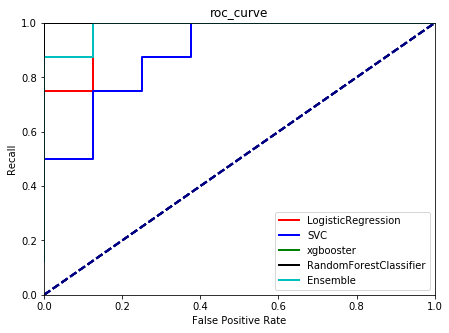

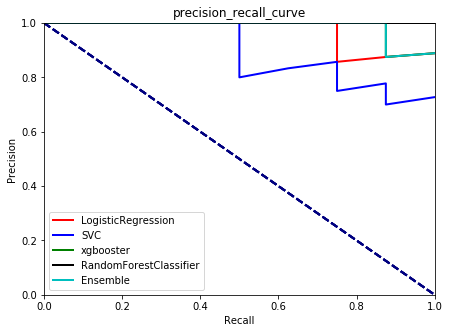

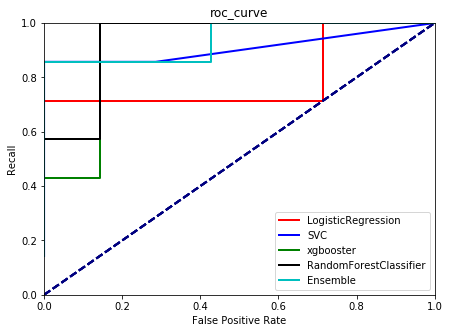

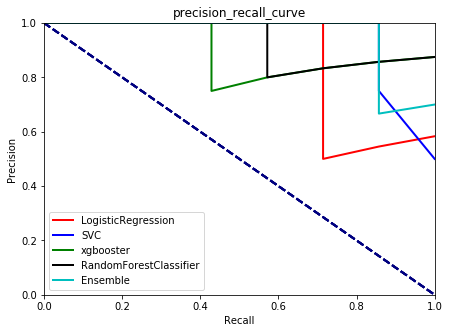

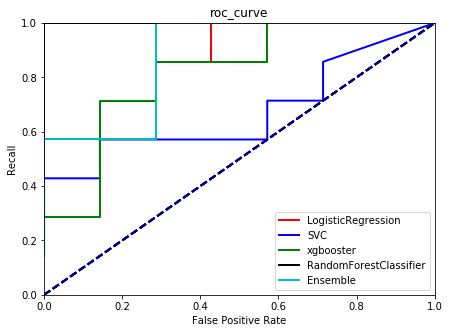

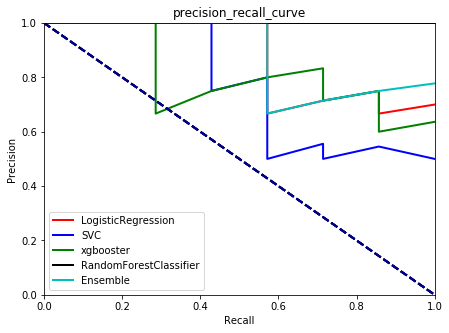

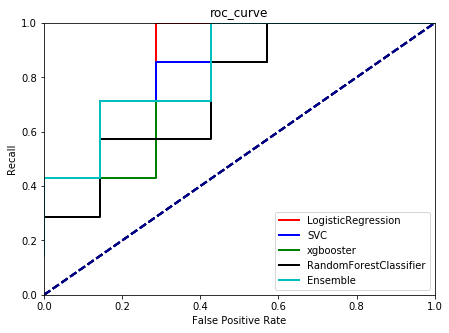

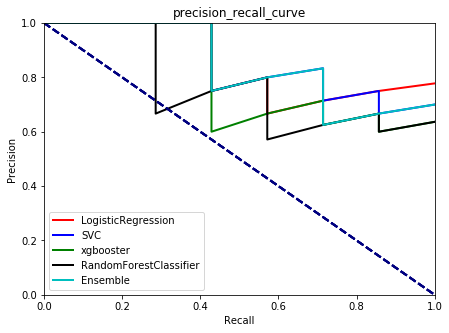

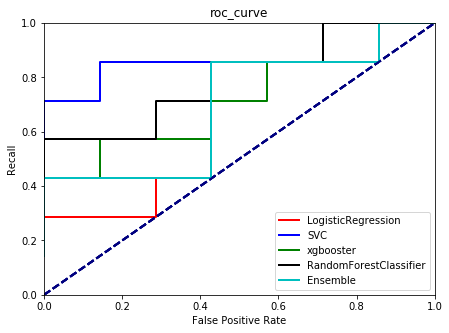

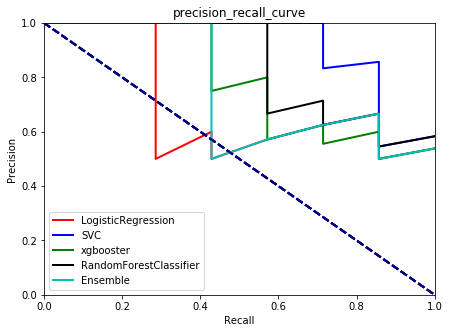

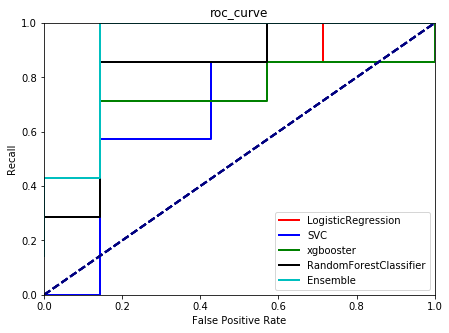

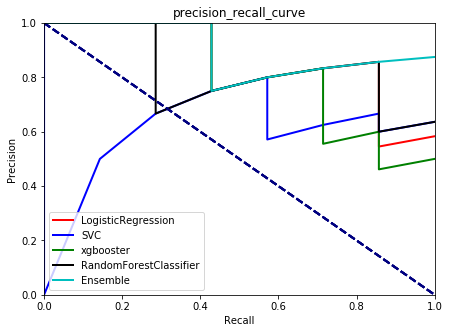

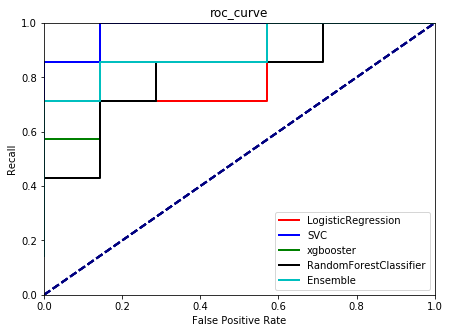

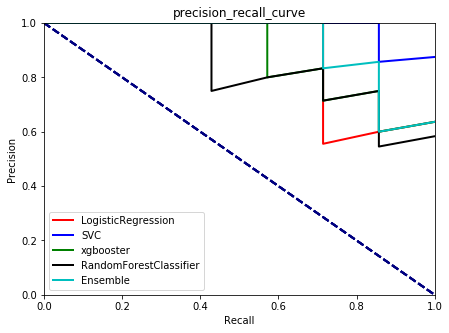

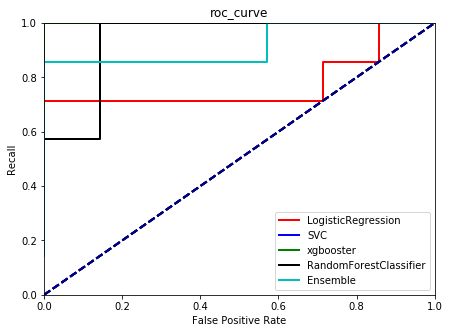

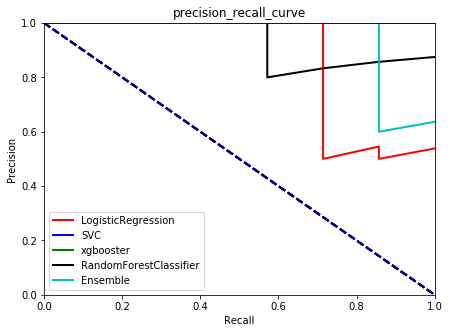

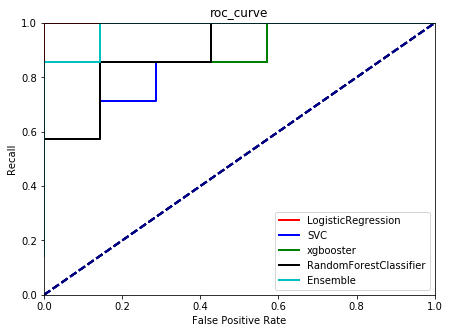

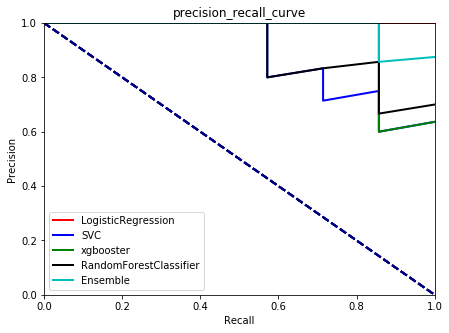

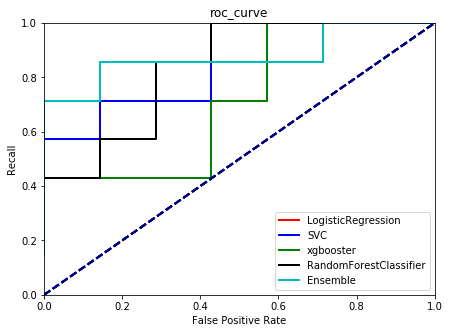

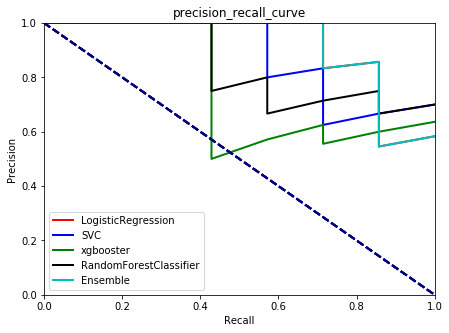

In [5]:
methods_cv = ['LogisticRegression','SVC','xgbooster','RandomForestClassifier']
if_hyperopt = True
if if_hyperopt:
    params_cv = get_hyperopt_params(methods_cv,wtf_lo=wtf_lo,wtf_hi=wtf_hi)
else:
    params_cv = get_search_params(methods=methods_cv)
tenfold_crossval_scores,model_combine_scores_cv,model_scores_cv,best_params_cv,pred_probs_cv,predicts_cv,pred_probs_all_fold = cross_val_ensemble(total_x,total_label,total_sample_weights,methods_cv,params_cv,fold=10,hyperopt=if_hyperopt,up_sampling=up_sampling)
logger.info('10-fold CV of ensemble method results:\n '+tenfold_crossval_scores.to_string())

In [6]:
predicts_dtype = ['i8']*predicts_cv.shape[1]
probs_dtype = ['i8','f']+['f']*(pred_probs_cv.shape[1]-2)
for i,col in enumerate(predicts_cv.columns):
    predicts_cv[col] = predicts_cv[col].astype(predicts_dtype[i])
    pred_probs_cv[col] = pred_probs_cv[col].astype(probs_dtype[i])

In [7]:
avg_score_columns = ['ensemble']+methods_cv
avg_scores = {}
for method in avg_score_columns:
    avg_scores[method] = scores(predicts_cv['label'],predicts_cv[method],pred_probs_cv[method])

In [8]:
avg_scores

{'ensemble': {'auc': 0.8954572505455267,
  'recall': 0.19718309859154928,
  'precision': 1.0,
  'accuracy': 0.5985915492957746,
  'f1': 0.32941176470588235},
 'LogisticRegression': {'auc': 0.8658996230906566,
  'recall': 0.6056338028169014,
  'precision': 0.8775510204081632,
  'accuracy': 0.7605633802816901,
  'f1': 0.7166666666666666},
 'SVC': {'auc': 0.859948422931958,
  'recall': 0.09859154929577464,
  'precision': 1.0,
  'accuracy': 0.5492957746478874,
  'f1': 0.17948717948717946},
 'xgbooster': {'auc': 0.8557825828208689,
  'recall': 0.23943661971830985,
  'precision': 1.0,
  'accuracy': 0.6197183098591549,
  'f1': 0.38636363636363635},
 'RandomForestClassifier': {'auc': 0.8783971434239238,
  'recall': 0.09859154929577464,
  'precision': 1.0,
  'accuracy': 0.5492957746478874,
  'f1': 0.17948717948717946}}

In [9]:
all_results,all_probs = methods_combination_results(methods_cv,pred_probs_all_fold,pd.Series(pred_probs_all_fold['label']))
all_probs = pd.DataFrame(all_probs)

LogisticRegression
[[2.23825019e-04 9.99776175e-01]
 [2.32188652e-01 7.67811348e-01]
 [1.23577355e-03 9.98764226e-01]
 [1.63273820e-01 8.36726180e-01]
 [4.37568483e-04 9.99562432e-01]
 [5.58198316e-01 4.41801684e-01]
 [3.60153782e-02 9.63984622e-01]
 [5.73914019e-01 4.26085981e-01]
 [9.97804481e-01 2.19551936e-03]
 [9.99997189e-01 2.81074793e-06]
 [9.49671136e-01 5.03288645e-02]
 [9.90901507e-01 9.09849305e-03]
 [6.96171539e-01 3.03828461e-01]
 [9.91144853e-01 8.85514742e-03]
 [4.86787371e-01 5.13212629e-01]
 [9.99802626e-01 1.97374467e-04]
 [3.45670491e-01 6.54329509e-01]
 [1.55339900e-03 9.98446601e-01]
 [9.86761460e-01 1.32385402e-02]
 [6.92586511e-01 3.07413489e-01]
 [9.81092113e-01 1.89078871e-02]
 [3.58073846e-03 9.96419262e-01]
 [4.21888748e-01 5.78111252e-01]
 [9.07472996e-01 9.25270036e-02]
 [9.80484115e-01 1.95158847e-02]
 [9.79140918e-01 2.08590815e-02]
 [9.99884318e-01 1.15681775e-04]
 [9.89865452e-01 1.01345482e-02]
 [8.57502920e-01 1.42497080e-01]
 [9.50691239e-01 4.93087

In [11]:
all_results

{'LogisticRegression': {'auc': 0.8658996230906565,
  'recall': 0.6056338028169014,
  'precision': 0.8775510204081632,
  'accuracy': 0.7605633802816901,
  'f1': 0.7166666666666666},
 'SVC': {'auc': 0.859948422931958,
  'recall': 0.056338028169014086,
  'precision': 1.0,
  'accuracy': 0.528169014084507,
  'f1': 0.10666666666666667},
 'xgbooster': {'auc': 0.8557825828208689,
  'recall': 0.23943661971830985,
  'precision': 1.0,
  'accuracy': 0.6197183098591549,
  'f1': 0.38636363636363635},
 'RandomForestClassifier': {'auc': 0.8783971434239238,
  'recall': 0.09859154929577464,
  'precision': 1.0,
  'accuracy': 0.5492957746478874,
  'f1': 0.17948717948717946},
 'LogisticRegression-SVC': {'auc': 0.8660979964292798,
  'recall': 0.14084507042253522,
  'precision': 1.0,
  'accuracy': 0.5704225352112676,
  'f1': 0.2469135802469136},
 'LogisticRegression-xgbooster': {'auc': 0.8807776234874033,
  'recall': 0.4084507042253521,
  'precision': 1.0,
  'accuracy': 0.704225352112676,
  'f1': 0.580000000

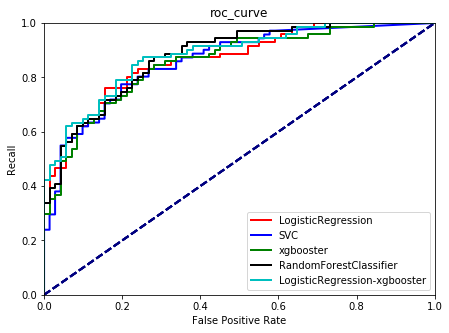

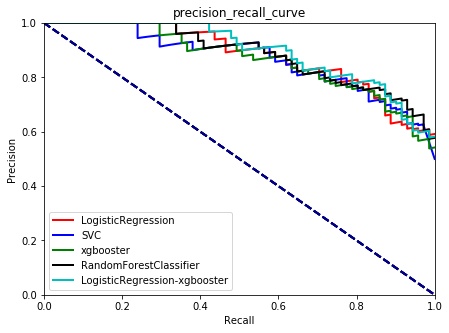

In [13]:
plot_methods = ['LogisticRegression','SVC','xgbooster','RandomForestClassifier','LogisticRegression-xgbooster']
plot_curves_cv(all_probs,pd.Series(pred_probs_all_fold['label']),methods=plot_methods,types='roc_curve')
plot_curves_cv(all_probs,pd.Series(pred_probs_all_fold['label']),methods=plot_methods,types='precision_recall_curve')

In [47]:
pred_probs_cv

label      ensemble  LogisticRegression           SVC
0        1  5.000298e-01        9.996123e-01  4.473418e-04
1        1  3.764628e-01        7.485533e-01  4.372159e-03
2        1  4.991784e-01        9.981980e-01  1.587592e-04
3        1  4.064842e-01        8.129286e-01  3.980178e-05
4        1  5.068581e-01        9.992835e-01  1.443271e-02
5        1  2.229032e-01        4.457916e-01  1.489294e-05
6        1  9.763176e-01        9.526358e-01  9.999993e-01
7        1  2.001875e-01        4.003698e-01  5.229626e-06
8        0  1.489019e-04        2.976032e-04  2.005767e-07
9        0  1.415878e-04        2.830756e-04  1.000000e-07
10       0  1.127784e-02        2.255474e-02  9.319957e-07
11       0  1.897958e-03        3.795732e-03  1.832508e-07
12       0  1.041114e-02        2.054041e-02  2.818741e-04
13       0  4.164260e-02        8.328212e-02  3.071885e-06
14       0  4.916274e-04        9.831548e-04  1.000000e-07
15       0  3.297624e-02        6.595224e-02  2.385441e-07
16       1  3.143414e-01        6.285333e-01  1.494120e-04
17       1  4.989815e-01        9.967031e-01  1.259902e-03
18       1  1.757684e-02        3.472345e-02  4.302307e-04
19       1  1.649800e-01        3.299598e-01  1.000000e-07
20       1  2.066431e-02        4.130870e-02  1.992246e-05
21       1  8.335842e-01        9.937752e-01  6.733932e-01
22       1  2.665108e-01        5.323452e-01  6.763581e-04
23       0  4.056808e-02        8.113606e-02  1.000000e-07
24       0  1.530976e-03        3.061751e-03  1.999969e-07
25       0  2.401454e-04        4.801908e-04  1.000000e-07
26       0  1.908225e-01        3.816450e-01  1.000000e-07
27       0  1.254497e-01        2.508334e-01  6.611187e-05
28       0  5.437102e-02        1.087419e-01  1.000000e-07
29       0  1.538660e-03        3.077221e-03  1.000000e-07
..     ...           ...                 ...           ...
112      0  3.611363e-02        7.222716e-02  1.000000e-07
113      0  2.139417e-03        4.278734e-03  1.000000e-07
114      1  4.336657e-01        8.670999e-01  2.314124e-04
115      1  6.348732e-01        9.279132e-01  3.418331e-01
116      1  1.403445e-01        2.806889e-01  2.246324e-07
117      1  4.996035e-01        9.988902e-01  3.168876e-04
118      1  1.403356e-01        2.806377e-01  3.344525e-05
119      1  2.630695e-01        5.261379e-01  1.096014e-06
120      1  2.899969e-01        5.799864e-01  7.423440e-06
121      0  2.220092e-06        4.340183e-06  1.000000e-07
122      0  9.244603e-08        8.489206e-08  1.000000e-07
123      0  1.854614e-01        3.707723e-01  1.506062e-04
124      0  1.823205e-01        3.646353e-01  5.551056e-06
125      0  2.645769e-02        5.289628e-02  1.909788e-05
126      0  1.198589e-01        2.397092e-01  8.617502e-06
127      0  6.071066e-04        1.213138e-03  1.075094e-06
128      1  3.059224e-01        6.114041e-01  4.405785e-04
129      1  2.467983e-01        4.934027e-01  1.938664e-04
130      1  4.992151e-01        9.958639e-01  2.566330e-03
131      1  9.450069e-01        9.518923e-01  9.381216e-01
132      1  2.797469e-01        5.594828e-01  1.095911e-05
133      1  9.853444e-03        1.970227e-02  4.623506e-06
134      1  4.826930e-01        9.623209e-01  3.065220e-03
135      0  7.156321e-02        1.431263e-01  1.163486e-07
136      0  7.471799e-03        1.483604e-02  1.075540e-04
137      0  5.128826e-02        1.025647e-01  1.179001e-05
138      0  3.255530e-06        6.411059e-06  1.000000e-07
139      0  4.214643e-02        8.429276e-02  1.000000e-07
140      0  5.006876e-06        9.913752e-06  1.000000e-07
141      0  9.290780e-04        1.857847e-03  3.087796e-07

[142 rows x 4 columns]

In [34]:
best_params_cv

[{'LogisticRegression': {'C': 15.743449035874542,
   'class_weight': None,
   'dual': False,
   'fit_intercept': True,
   'intercept_scaling': 1,
   'max_iter': 100,
   'multi_class': 'ovr',
   'n_jobs': 1,
   'penalty': 'l2',
   'random_state': None,
   'solver': 'liblinear',
   'tol': 0.0001,
   'verbose': 0,
   'warm_start': False,
   'weight_factor': 0.252391283050952},
  'xgbooster': {'gamma': 0.02659338414319988,
   'learning_rate': 0.1,
   'max_depth': 16,
   'n_estimators': 698,
   'reg_lambda': 26.726942600583108,
   'n_jobs': -1,
   'weight_factor': 0.21727433063862,
   'objective': 'binary:logistic'}},
 {'LogisticRegression': {'C': 19.026515950951342,
   'class_weight': None,
   'dual': False,
   'fit_intercept': True,
   'intercept_scaling': 1,
   'max_iter': 100,
   'multi_class': 'ovr',
   'n_jobs': 1,
   'penalty': 'l2',
   'random_state': None,
   'solver': 'liblinear',
   'tol': 0.0001,
   'verbose': 0,
   'warm_start': False,
   'weight_factor': 0.29965791803926356},


In [14]:
tenfold_crossval_scores

logloss        f1    recall  precision  auc_score
0  0.822794  0.400000  0.250000        1.0   0.765625
1  0.670506  0.250000  0.142857        1.0   0.877551
2  0.803313  0.444444  0.285714        1.0   0.836735
3  0.858892  0.250000  0.142857        1.0   0.979592
4  1.063948  0.444444  0.285714        1.0   0.591837
5  1.040191  0.000000  0.000000        0.0   0.734694
6  0.794498  0.000000  0.000000        0.0   0.836735
7  0.893945  0.000000  0.000000        0.0   0.693878
8  0.998143  0.000000  0.000000        0.0   0.755102
9  0.832760  0.600000  0.428571        1.0   0.816327

In [35]:
model_combine_scores_cv

[{'LogisticRegression': {'auc': 0.765625,
   'recall': 0.625,
   'precision': 0.7142857142857143,
   'accuracy': 0.6875,
   'f1': 0.6666666666666666},
  'xgbooster': {'auc': 0.984375,
   'recall': 0.25,
   'precision': 1.0,
   'accuracy': 0.625,
   'f1': 0.4},
  'LogisticRegression-xgbooster': {'auc': 0.828125,
   'recall': 0.375,
   'precision': 1.0,
   'accuracy': 0.6875,
   'f1': 0.5454545454545454}},
 {'LogisticRegression': {'auc': 0.9387755102040816,
   'recall': 0.5714285714285714,
   'precision': 1.0,
   'accuracy': 0.7857142857142857,
   'f1': 0.7272727272727273},
  'xgbooster': {'auc': 1.0,
   'recall': 0.14285714285714285,
   'precision': 1.0,
   'accuracy': 0.5714285714285714,
   'f1': 0.25},
  'LogisticRegression-xgbooster': {'auc': 0.9591836734693878,
   'recall': 0.5714285714285714,
   'precision': 1.0,
   'accuracy': 0.7857142857142857,
   'f1': 0.7272727272727273}},
 {'LogisticRegression': {'auc': 0.8163265306122449,
   'recall': 0.5714285714285714,
   'precision': 0.8,

In [36]:
log_xgb_cores = [x['LogisticRegression-xgbooster'] for x in model_combine_scores_cv]

In [37]:
log_xgb_cores

[{'auc': 0.828125,
  'recall': 0.375,
  'precision': 1.0,
  'accuracy': 0.6875,
  'f1': 0.5454545454545454},
 {'auc': 0.9591836734693878,
  'recall': 0.5714285714285714,
  'precision': 1.0,
  'accuracy': 0.7857142857142857,
  'f1': 0.7272727272727273},
 {'auc': 0.8367346938775511,
  'recall': 0.2857142857142857,
  'precision': 1.0,
  'accuracy': 0.6428571428571429,
  'f1': 0.4444444444444445},
 {'auc': 0.7755102040816326,
  'recall': 0.2857142857142857,
  'precision': 1.0,
  'accuracy': 0.6428571428571429,
  'f1': 0.4444444444444445},
 {'auc': 0.8367346938775511,
  'recall': 0.2857142857142857,
  'precision': 1.0,
  'accuracy': 0.6428571428571429,
  'f1': 0.4444444444444445},
 {'auc': 0.7346938775510203,
  'recall': 0.14285714285714285,
  'precision': 1.0,
  'accuracy': 0.5714285714285714,
  'f1': 0.25},
 {'auc': 0.9591836734693878,
  'recall': 0.2857142857142857,
  'precision': 1.0,
  'accuracy': 0.6428571428571429,
  'f1': 0.4444444444444445},
 {'auc': 0.673469387755102,
  'recall': 

In [10]:
best_params_cv

[{'LogisticRegression': {'C': 9.999269942183094,
   'class_weight': None,
   'dual': False,
   'fit_intercept': True,
   'intercept_scaling': 1,
   'max_iter': 100,
   'multi_class': 'ovr',
   'n_jobs': 1,
   'penalty': 'l2',
   'random_state': None,
   'solver': 'liblinear',
   'tol': 0.0001,
   'verbose': 0,
   'warm_start': False,
   'weight_factor': 0.2861048444772631},
  'RandomForestClassifier': {'bootstrap': True,
   'class_weight': None,
   'criterion': 'gini',
   'max_depth': 18,
   'max_features': 'auto',
   'max_leaf_nodes': None,
   'min_impurity_decrease': 0.0,
   'min_impurity_split': None,
   'min_samples_leaf': 2,
   'min_samples_split': 6,
   'min_weight_fraction_leaf': 0.0,
   'n_estimators': 469,
   'n_jobs': -1,
   'oob_score': False,
   'random_state': None,
   'verbose': 0,
   'warm_start': False,
   'weight_factor': 0.2000711510392489},
  'xgbooster': {'gamma': 0.032663521569040545,
   'learning_rate': 0.1,
   'max_depth': 17,
   'n_estimators': 1900,
   'reg_lam